In [2]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib as mpl
import os
import matplotlib.patches as mpatches
from scipy.stats import wilcoxon
import itertools
import numpy as np

# Path to our JSONL file
methods_fn=['svm', 'rocchio', 'pichunter','poly', 'poly_msed'] #, 
res_path='../out_results/clip'
jsonl_files=[]
for m in methods_fn:
    filename=f'{res_path}/exps_res_{m}.jsonl'
    jsonl_files.append(filename)




In [3]:
def get_results_df(jsonl_f):
    data = []

    # Read JSONL file line by line and parse each line as JSON
    with open(jsonl_f, 'r') as f:
        for line in f:
            line_data = json.loads(line.strip())
            data.append(line_data)
    # Convert list of dictionaries to DataFrame
    df_tmp = pd.DataFrame(data)

    print(f"{jsonl_f} shape, {df_tmp.shape}")
    return df_tmp

In [4]:
outfilename = f'{res_path}/df_all_results_paper.csv'

if os.path.isfile(outfilename) and os.path.getsize(outfilename) > 0:
    print(f"opening outfile: {outfilename}")
    df=pd.read_csv(outfilename)
    original_df = df.copy()
    print(f"df shape, {df.shape} \n {df.columns}")
    print(f"df loaded")
else:
    dfs=[]
    for jsonl_file in jsonl_files:
        print(f"jsonl_file: {jsonl_file}")
        dfs.append(get_results_df(jsonl_file))
        
    df= pd.concat(dfs, ignore_index=True)
    original_df = df.copy()
    print(f"concatenation done, df shape, {df.shape} \n {df.columns}")
    df.to_csv(outfilename, index=False)
    print(f"df saved to {outfilename}")

###
df['to_sort']=df['dataset']+df['seed'].astype(str)+df['iteration'].astype(str)
print(f"dropping columns")
columns_to_drop = ['n_pos_at_iter','action_step', 'n_actions', 'n_pos_action', 'n_neg_action', 'actions', 'dataset','seed','indexes_positive_initial_images', 'initial_query', 'exp_id']
df = df.drop(columns=columns_to_drop)
initial_df = df.copy()
df.head()

opening outfile: ../out_results/clip/df_all_results_paper.csv
df shape, (950400, 28) 
 Index(['iteration', 'n_pos_at_iter', 'recall', 'ndcg', 'map', 'action_step',
       'n_actions', 'n_pos_action', 'n_neg_action', 'actions', 'dataset',
       'seed', 'max_iter', 'n_display', 'k_pos', 'k_neg',
       'indexes_positive_initial_images', 'method', 'fun_name',
       'data_preprocessing', 'initial_query', 'use_batch', 'gamma', 'alpha',
       'beta', 'exp_id', 'temperature', 'norm_multiplier'],
      dtype='object')
df loaded
dropping columns


iteration  recall      ndcg       map  max_iter  n_display  k_pos  k_neg  \
0          0     0.1  0.228603  0.321587        10         50     -1      0   
1          1     1.0  1.000000  1.000000        10         50     -1      0   
2          2     1.0  1.000000  1.000000        10         50     -1      0   
3          3     1.0  1.000000  1.000000        10         50     -1      0   
4          4     1.0  1.000000  1.000000        10         50     -1      0   

  method fun_name data_preprocessing  use_batch  gamma  alpha  beta  \
0    SVM               L2_normalized       True    0.0    0.0   1.0   
1    SVM               L2_normalized       True    0.0    0.0   1.0   
2    SVM               L2_normalized       True    0.0    0.0   1.0   
3    SVM               L2_normalized       True    0.0    0.0   1.0   
4    SVM               L2_normalized       True    0.0    0.0   1.0   

   temperature  norm_multiplier    to_sort  
0          NaN              NaN  df_160800  
1          NaN              NaN  df_160801  
2          NaN              NaN  df_160802  
3          NaN              NaN  df_160803  
4          NaN              NaN  df_160804

In [5]:
print(df['method'].unique())

['SVM' 'Rocchio' 'Pichunter' 'Polyquery' 'Polyquery_msed_logscale']


## Useful functions


In [6]:

def select_and_save_method_df(df_copy, methods, data_preprocessing=[], out_res_path=res_path):
    condition1=False
    condition2=False
    for method in methods:
        condition1 = condition1 | (df_copy['method'] == method)
    if len(data_preprocessing)==0:
        condition2=True
    else:
        for pre in data_preprocessing:
            condition2 = condition2 |(df_copy['data_preprocessing'] == pre)
    df_copy=df_copy[condition1 & condition2]
    print(df_copy.shape) 
    outfile = f"{out_res_path}/df_{method}.csv"
    df_copy.to_csv(outfile, index=False)

    return df_copy

def plot_and_statistical_test_varying_fun(df_copy, prefixplot,
                                          use_batch,max_iter=10,
                                          k_pos_neg_list = [(-1,0),(-1,-1), (3,0), (3,3), (5,0), (5,5)],
                                          out_res_path=res_path,
                                          figsize=(10, 6),
                                          print_fun_name=False,
                                          print_temperature=False,
                                          print_data_preprocessing=False,
                                          print_k_pos_k_neg=False,
                                          use_wilcoxon=False,
                                          ):
                                          
    df_copy=df_copy[df_copy['use_batch']==use_batch]
    plt.rcParams.update({'font.size': 18})
    hatches = [ 'xx', '||', '\\\\', '--', '++', '**', 'oo', 'xx', '//', '..', 'xx']
    for k_pos, k_neg in k_pos_neg_list:
        print(f"^^^^  k_pos={k_pos}, k_neg={k_neg}, use_batch={use_batch} ^^^")
        df_temp = df_copy.copy()
        df_temp=df_temp[(df_temp['k_pos'] == k_pos) & (df_temp['k_neg'] == k_neg)]
        new_names=df_temp['method'] 
        if print_data_preprocessing:
            #if df_temp['data_preprocessing'] is a string diffrent from  ' ' then o '  ('+ df_temp['data_preprocessing']+'  )' else ' '
            new_names+= df_temp['data_preprocessing'].apply(lambda x: '  ('+x+'  )' if x!=' ' else ' ')  
        if print_fun_name:
           new_names+= df_temp['fun_name'].apply(lambda x: ' - '+x if x!=' ' else ' ')  
        if print_temperature:
            new_names+= ' - '+ df_temp['temperature'].astype(str)
        if print_k_pos_k_neg:
            new_names+= " with $k^+$=" + df_temp['k_pos'].astype(str) + " and $k^-$=" + df_temp['k_neg'].astype(str)

        
        df_temp['Method']=new_names
        methods = df_temp['Method'].unique()
        #reorder df_temp by method
        df_temp['Method'] = pd.Categorical(df_temp['Method'], methods)
        # Count the number of points for each Method
        method_counts = df_temp.groupby('Method').size().reset_index(name='Count')

        # Display the counts
        print(method_counts)
        
        plt.figure(figsize=figsize)
        
        ax = sns.boxplot(x='iteration', y='recall', hue='Method', data=df_temp)
        number_iterations=len(df_temp['iteration'].unique())
        number_of_methods=len(methods)
       
        # Get unique methods to map hatch patterns to them
        
        colors = sns.color_palette('colorblind', len(methods))
        hatch_map = {method: (hatches[i % len(hatches)], colors[i]) for i, method in enumerate(methods)}

      
        # main_box_patches = [patch for patch in ax.patches if isinstance(patch, mpl.patches.PathPatch)]
        # print(main_box_patches)

       # print('npatches',len(main_box_patches))
        # print(f"number_iterations:{number_iterations}, number_of_methods:{number_of_methods}")
     
        for i, patch in enumerate(ax.patches):
            method_index  = (i // number_iterations) # Determine the method for the current patch
            iteration_index= i % number_iterations
            # print(f"i {i} -> method_index:{method_index},      iteration_index:{iteration_index},    patch:{patch}")
            if(i>=number_iterations*number_of_methods):
                method = methods[iteration_index]
            else:
                method = methods[method_index]
            hatch, color = hatch_map[method]
            face_color_with_alpha = color + (0.7,)  # Adding alpha value (0.7)
            edge_color_with_alpha = [max(0, c * 0.9) for c in color]
            patch.set_hatch(hatch)
            patch.set_edgecolor(edge_color_with_alpha) #make it a little bit darker then color
            patch.set_linewidth(0.5)
            patch.set_facecolor(face_color_with_alpha)  # Ensure face color is set to correct color
            #if iteration_index>number_iterations:
                #patch_legend = mpatches.Patch(facecolor=face_color_with_alpha, edgecolor=edge_color_with_alpha, hatch=hatch, label=method)
                #handles.append(patch_legend)
            #     handles.append(patch_legend)

        #handles, labels = ax.get_legend_handles_labels()
        plt.legend( loc='lower right')  
        #plt.title(f"Recall by iteration for each method (k_pos={k_pos}, k_neg={k_neg})")
        save_path = f"{out_res_path}/plots/recall_{prefixplot}_usebatch_{use_batch}_k_{k_pos}_{k_neg}.png"
        plt.savefig(save_path)
        plt.show()
        
        print("*****")
        print(f"**** Performing statistical tests for k_pos={k_pos}, k_neg={k_neg}, use_batch={use_batch} ***")
        df_temp.sort_values(by=['to_sort'], inplace=True)    
        for it in range(1, max_iter+1):
            #select df_temp['iteration']==it
            df_temp_it = df_temp[df_temp['iteration']==it]
            # Perform ANOVA
        
            anova_result = stats.f_oneway(
                *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
            )

            if anova_result.pvalue < 0.05:
                print(f"\t k_pos={k_pos}, k_neg={k_neg}, it={it} There are statistically significant differences between the methods (ANOVA result: F={anova_result.statistic}, p={anova_result.pvalue}).") 
                
                if use_wilcoxon:
                    wilcoxon_results = {}

                    # Get unique methods
                    methods = df_temp_it['Method'].unique()

                    # Perform pairwise Wilcoxon tests
                    for method1, method2 in itertools.combinations(methods, 2):
                        group1 = df_temp_it[df_temp_it['Method'] == method1]['recall']
                        group2 = df_temp_it[df_temp_it['Method'] == method2]['recall']
                        if len(group1) != len(group2):
                                    print(f"Skipping Wilcoxon test for {method1} vs {method2} due to unequal sample sizes.")
                                    continue
                                
                        stat, pvalue = wilcoxon(group1, group2)
                        wilcoxon_results[(method1, method2)] = pvalue
                        if pvalue<0.05:
                            differences = np.array(group1) - np.array(group2)
                            abs_diff = np.abs(differences)
                            ranks = np.argsort(np.argsort(abs_diff)) + 1
                            signed_ranks = ranks * np.sign(differences)

                            # Sum of ranks for positive and negative differences
                            W_plus = np.sum(signed_ranks[signed_ranks > 0])
                            W_minus = np.sum(-signed_ranks[signed_ranks < 0])
                            print(f"\t\t\t! Wilcoxon test between {method1} and {method2}: \t stat={stat}, p-value = {pvalue}, W+ minus W-: {W_plus-W_minus}")
                        else: 
                            print(f"\t\t\t Wilcoxon test between {method1} and {method2} has pvalue>0.05")
                else:
                    # Perform pairwise t-tests using Tukey's HSD (Honestly Significant Difference)
                    tukey_result = pairwise_tukeyhsd(
                        endog=df_temp_it['recall'],
                        groups=df_temp_it['Method'],
                        alpha=0.05
                    ) #meandiff is mean group 2 - mean group1

                    #diff=df_temp_it[df_temp_it['method_fun']== "Pichunter - l1_normalized_cosine"]['recall'].mean()-df_temp_it[df_temp_it['method_fun']== "Pichunter - softmin"]['recall'].mean()
                    print(tukey_result)

                    # # Plot the result
                    # tukey_result.plot_simultaneous()
                    # plt.title('Tukey HSD Pairwise Comparisons')
                    # plt.show()
            else:
                print(f" \t k_pos={k_pos}, k_neg={k_neg},it={it}, There are NO statistically significant differences between the methods. (ANOVA result: F={anova_result.statistic}, p={anova_result.pvalue})")

def plot_and_statistical_test_varying_k(df_copy, prefixplot,
                                          use_batch,max_iter=10,
                                          k_pos_neg_list = [(-1,0),(-1,-1), (3,0), (3,3), (5,0), (5,5)],
                                          out_res_path=res_path,
                                          figsize=(10, 6),
                                          print_fun_name=False,
                                          print_temperature=False,
                                          print_data_preprocessing=False,
                                          print_k_pos_k_neg=True,
                                          use_wilcoxon=False,
                                          ):
                                          
    df_copy=df_copy[df_copy['use_batch']==use_batch]
    plt.rcParams.update({'font.size': 18})
    hatches = [ 'xx', '||', '\\\\', '--', '++', '**', 'oo', 'xx', '//', '..', 'xx']
    k_pos_list=set([k_pos_neg[0] for k_pos_neg in k_pos_neg_list])
    for k_pos in k_pos_list:
        print(f"^^^^  k_pos={k_pos}, use_batch={use_batch} ^^^")
        df_temp = df_copy.copy()
        df_temp=df_temp[(df_temp['k_pos'] == k_pos)]
        new_names=df_temp['method'] 
        if print_data_preprocessing:
            new_names+= ' - '+ df_temp['data_preprocessing']
        if print_fun_name:
           new_names+= df_temp['fun_name'].apply(lambda x: ' - '+x if x!=' ' else ' ')  
        if print_temperature:
            new_names+= ' - '+ df_temp['temperature'].astype(str)
        if print_k_pos_k_neg:
            new_names+= " with $k^+$=" + df_temp['k_pos'].astype(str) + " and $k^-$=" + df_temp['k_neg'].astype(str)

        df_temp['Method']=new_names
        methods = df_temp['Method'].unique()
        #reorder df_temp by method
        df_temp['Method'] = pd.Categorical(df_temp['Method'], methods)
        # Count the number of points for each Method
        method_counts = df_temp.groupby('Method').size().reset_index(name='Count')

        # Display the counts
        print(method_counts)
        
        plt.figure(figsize=figsize)
        
       
        ax = sns.boxplot(x='iteration', y='recall', hue='Method', data=df_temp)
        number_iterations=len(df_temp['iteration'].unique())
        number_of_methods=len(methods)
       
        # Get unique methods to map hatch patterns to them
        
        colors = sns.color_palette('colorblind', len(methods))
        hatch_map = {method: (hatches[i % len(hatches)], colors[i]) for i, method in enumerate(methods)}

      
        # main_box_patches = [patch for patch in ax.patches if isinstance(patch, mpl.patches.PathPatch)]
        # print(main_box_patches)

       # print('npatches',len(main_box_patches))
        # print(f"number_iterations:{number_iterations}, number_of_methods:{number_of_methods}")
     
        for i, patch in enumerate(ax.patches):
            method_index  = (i // number_iterations) # Determine the method for the current patch
            iteration_index= i % number_iterations
            # print(f"i {i} -> method_index:{method_index},      iteration_index:{iteration_index},    patch:{patch}")
            if(i>=number_iterations*number_of_methods):
                method = methods[iteration_index]
            else:
                method = methods[method_index]
            hatch, color = hatch_map[method]
            face_color_with_alpha = color + (0.7,)  # Adding alpha value (0.7)
            edge_color_with_alpha = [max(0, c * 0.9) for c in color]
            patch.set_hatch(hatch)
            patch.set_edgecolor(edge_color_with_alpha) #make it a little bit darker then color
            patch.set_linewidth(0.5)
            patch.set_facecolor(face_color_with_alpha)  # Ensure face color is set to correct color
            #if iteration_index>number_iterations:
                #patch_legend = mpatches.Patch(facecolor=face_color_with_alpha, edgecolor=edge_color_with_alpha, hatch=hatch, label=method)
                #handles.append(patch_legend)
            #     handles.append(patch_legend)

        #handles, labels = ax.get_legend_handles_labels()
        plt.legend( loc='lower right')  
        #plt.title(f"Recall by iteration for each method (k_pos={k_pos}, k_neg={k_neg})")
        save_path = f"{out_res_path}/plots/recall_{prefixplot}_usebatch_{use_batch}_k_{k_pos}.png"
        plt.savefig(save_path)
        plt.show()
        print("*****")
        print(f"**** Performing statistical tests for k_pos={k_pos},, use_batch={use_batch} ***")
        
        df_temp.sort_values(by=['to_sort'], inplace=True)   
        for it in range(1, max_iter+1):
            #select df_temp['iteration']==it
            df_temp_it = df_temp[df_temp['iteration']==it]
            # Perform ANOVA
        
            anova_result = stats.f_oneway(
                *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
            )

            if anova_result.pvalue < 0.05:
                print(f"\t k_pos={k_pos}, it={it} There are statistically significant differences between the methods (ANOVA result: F={anova_result.statistic}, p={anova_result.pvalue}).") 
                if use_wilcoxon:
                    wilcoxon_results = {}

                    # Get unique methods
                    methods = df_temp_it['Method'].unique()

                    # Perform pairwise Wilcoxon tests
                    for method1, method2 in itertools.combinations(methods, 2):
                        group1 = df_temp_it[df_temp_it['Method'] == method1]['recall']
                        group2 = df_temp_it[df_temp_it['Method'] == method2]['recall']
                        if len(group1) != len(group2):
                                    print(f"Skipping Wilcoxon test for {method1} vs {method2} due to unequal sample sizes.")
                                    continue
                                
                        stat, pvalue = wilcoxon(group1, group2)
                        wilcoxon_results[(method1, method2)] = pvalue
                        if pvalue<0.05:
                            differences = np.array(group1) - np.array(group2)
                            abs_diff = np.abs(differences)
                            ranks = np.argsort(np.argsort(abs_diff)) + 1
                            signed_ranks = ranks * np.sign(differences)

                            # Sum of ranks for positive and negative differences
                            W_plus = np.sum(signed_ranks[signed_ranks > 0])
                            W_minus = np.sum(-signed_ranks[signed_ranks < 0])
                            print(f"\t\t\t! Wilcoxon test between {method1} and {method2}: \t stat={stat}, p-value = {pvalue}, W+ minus W-: {W_plus-W_minus}")
                        else: 
                            print(f" \t\t\tWilcoxon test between {method1} and {method2} has pvalue>0.05")
                else:
                    # Perform pairwise t-tests using Tukey's HSD (Honestly Significant Difference)
                    tukey_result = pairwise_tukeyhsd(
                        endog=df_temp_it['recall'],
                        groups=df_temp_it['Method'],
                        alpha=0.05
                    ) #meandiff is mean group 2 - mean group1

                    #diff=df_temp_it[df_temp_it['method_fun']== "Pichunter - l1_normalized_cosine"]['recall'].mean()-df_temp_it[df_temp_it['method_fun']== "Pichunter - softmin"]['recall'].mean()
                    print(tukey_result)

                    # # Plot the result
                    # tukey_result.plot_simultaneous()
                    # plt.title('Tukey HSD Pairwise Comparisons')
                    # plt.show()
            else:
                print(f" \t k_pos={k_pos}, it={it}, There are NO statistically significant differences between the methods. (ANOVA result: F={anova_result.statistic}, p={anova_result.pvalue})")


def plot_and_statistical_test_varying_update(df_copy, prefixplot,max_iter=10,
                                          k_pos_neg_list = [(-1,0),(-1,-1), (3,0), (3,3), (5,0), (5,5)],
                                          out_res_path=res_path,
                                          figsize=(10, 6),
                                          print_fun_name=False,
                                          print_temperature=False,
                                          print_data_preprocessing=False,
                                          print_k_pos_k_neg=False,
                                          use_wilcoxon=False,
                                          ):
                                          
   
    plt.rcParams.update({'font.size': 18})
    hatches = [ 'xx', '||', '\\\\', '--', '++', '**', 'oo', 'xx', '//', '..', 'xx']
   
    for k_pos, k_neg in k_pos_neg_list:
        print(f"^^^^  k_pos={k_pos}, k_neg={k_neg} ^^^")
        df_temp = df_copy.copy()
        df_temp=df_temp[(df_temp['k_pos'] == k_pos) & (df_temp['k_neg'] == k_neg)]
        new_names=df_temp['method']+ ' - '+ df_temp['use_batch'].apply(lambda x: ' Batch' if x== True else ' Incremental ' ) 
        if print_data_preprocessing:
            new_names+= ' - '+ df_temp['data_preprocessing']
        if print_fun_name:
           new_names+= df_temp['fun_name'].apply(lambda x: ' - '+x if x!=' ' else ' ')  
        if print_temperature:
            new_names+= ' - '+ df_temp['temperature'].astype(str)
        if print_k_pos_k_neg:
            new_names+= " with $k^+$=" + df_temp['k_pos'].astype(str) + " and $k^-$=" + df_temp['k_neg'].astype(str)

        df_temp['Method']=new_names
        methods = df_temp['Method'].unique()
        #reorder df_temp by method
        df_temp['Method'] = pd.Categorical(df_temp['Method'], methods)
        # Count the number of points for each Method
        method_counts = df_temp.groupby('Method').size().reset_index(name='Count')

        # Display the counts
        print(method_counts)
        
        plt.figure(figsize=figsize)
        
       
        ax = sns.boxplot(x='iteration', y='recall', hue='Method', data=df_temp)
        number_iterations=len(df_temp['iteration'].unique())
        number_of_methods=len(methods)
       
        # Get unique methods to map hatch patterns to them
        
        colors = sns.color_palette('colorblind', len(methods))
        hatch_map = {method: (hatches[i % len(hatches)], colors[i]) for i, method in enumerate(methods)}

      
        # main_box_patches = [patch for patch in ax.patches if isinstance(patch, mpl.patches.PathPatch)]
        # print(main_box_patches)

       # print('npatches',len(main_box_patches))
        # print(f"number_iterations:{number_iterations}, number_of_methods:{number_of_methods}")
     
        for i, patch in enumerate(ax.patches):
            method_index  = (i // number_iterations) # Determine the method for the current patch
            iteration_index= i % number_iterations
            # print(f"i {i} -> method_index:{method_index},      iteration_index:{iteration_index},    patch:{patch}")
            if(i>=number_iterations*number_of_methods):
                method = methods[iteration_index]
            else:
                method = methods[method_index]
            hatch, color = hatch_map[method]
            face_color_with_alpha = color + (0.7,)  # Adding alpha value (0.7)
            edge_color_with_alpha = [max(0, c * 0.9) for c in color]
            patch.set_hatch(hatch)
            patch.set_edgecolor(edge_color_with_alpha) #make it a little bit darker then color
            patch.set_linewidth(0.5)
            patch.set_facecolor(face_color_with_alpha)  # Ensure face color is set to correct color
            #if iteration_index>number_iterations:
                #patch_legend = mpatches.Patch(facecolor=face_color_with_alpha, edgecolor=edge_color_with_alpha, hatch=hatch, label=method)
                #handles.append(patch_legend)
            #     handles.append(patch_legend)

        #handles, labels = ax.get_legend_handles_labels()
        plt.legend( loc='lower right')  
        #plt.title(f"Recall by iteration for each method (k_pos={k_pos}, k_neg={k_neg})")
        save_path = f"{out_res_path}/plots/recall_{prefixplot}_batchVSincrementalkpos_{k_pos}_kneg_{k_neg}.png"
        plt.savefig(save_path)
        plt.show()
        print("*****")
        print(f"**** Performing statistical tests for k_pos={k_pos},, k_neg={k_neg} ***")
        df_temp.sort_values(by=['to_sort'], inplace=True)   
        for it in range(1, max_iter+1):
            #select df_temp['iteration']==it
            df_temp_it = df_temp[df_temp['iteration']==it]
            # Perform ANOVA
        
            anova_result = stats.f_oneway(
                *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
            )

            if anova_result.pvalue < 0.05:
                print(f"\t k_pos={k_pos}, k_neg={k_neg}, it={it} There are statistically significant differences between the methods (ANOVA result: F={anova_result.statistic}, p={anova_result.pvalue}).") 
                if use_wilcoxon:
                    wilcoxon_results = {}

                    # Get unique methods
                    methods = df_temp_it['Method'].unique()

                    # Perform pairwise Wilcoxon tests
                    for method1, method2 in itertools.combinations(methods, 2):
                        group1 = df_temp_it[df_temp_it['Method'] == method1]['recall']
                        group2 = df_temp_it[df_temp_it['Method'] == method2]['recall']
                        if len(group1) != len(group2):
                                    print(f"Skipping Wilcoxon test for {method1} vs {method2} due to unequal sample sizes.")
                                    continue
                                
                        stat, pvalue = wilcoxon(group1, group2)
                        wilcoxon_results[(method1, method2)] = pvalue
                        if pvalue<0.05:
                            differences = np.array(group1) - np.array(group2)
                            abs_diff = np.abs(differences)
                            ranks = np.argsort(np.argsort(abs_diff)) + 1
                            signed_ranks = ranks * np.sign(differences)

                            # Sum of ranks for positive and negative differences
                            W_plus = np.sum(signed_ranks[signed_ranks > 0])
                            W_minus = np.sum(-signed_ranks[signed_ranks < 0])
                            print(f"\t\t\t! Wilcoxon test between {method1} and {method2}: \t stat={stat}, p-value = {pvalue}, W+ minus W-: {W_plus-W_minus}")
                        else: 
                            print(f"\t\t\t Wilcoxon test between {method1} and {method2} has pvalue>0.05")
                else:
                    # Perform pairwise t-tests using Tukey's HSD (Honestly Significant Difference)
                    tukey_result = pairwise_tukeyhsd(
                        endog=df_temp_it['recall'],
                        groups=df_temp_it['Method'],
                        alpha=0.05
                    ) #meandiff is mean group 2 - mean group1

                    #diff=df_temp_it[df_temp_it['method_fun']== "Pichunter - l1_normalized_cosine"]['recall'].mean()-df_temp_it[df_temp_it['method_fun']== "Pichunter - softmin"]['recall'].mean()
                    print(tukey_result)

                    # # Plot the result
                    # tukey_result.plot_simultaneous()
                    # plt.title('Tukey HSD Pairwise Comparisons')
                    # plt.show()
            else:
                print(f" \t k_pos={k_pos}, k_neg={k_neg} it={it}, There are NO statistically significant differences between the methods. (ANOVA result: F={anova_result.statistic}, p={anova_result.pvalue})")



# PicHunter


In [7]:
methods = ['Pichunter']
df_method=select_and_save_method_df(df.copy(), methods)
print('old method name',df_method['method'].unique())
print(df_method['fun_name'].unique())
print(df_method['temperature'].unique())
print(df_method['norm_multiplier'].unique())
print(df_method['data_preprocessing'].unique())
print(df_method['use_batch'].unique())
df_method['method']='PicHunter*'
print('new method name',df_method['method'].unique())

df_Pic=df_method.copy()
#note that this contains also results for Pichunter. So result for Picunter with k_pos=kp, k_neg=kn are the same of PicHunter* with k_pos=kp, k_neg=0 (PicHunter do not use explicitely the negative). We duplicate the dataframe to have also PicHunter results
#df_Pic.loc[df_Pic['k_neg']==0,'method']='PicHunter/PicHunter*'









(422400, 18)
old method name ['Pichunter']
['softmin']
[  8.210553   82.10553   821.0553      0.8210553]
[  1.   10.  100.    0.1]
['L2_normalized']
[ True False]
new method name ['PicHunter*']


## Observation from Experiments:


- fun_name='softmin' (batch/incremental):  temperature 1 always worse, no statistical difference for the temperature \eta, 10\eta, 100\eta, but boxplots for 10\eta are more compact in some cases -->so we select temperature=10\eta= 82.10553
- fun_name='softmax_cosine':temperature 1 always worse, \eta sometimes statistically worse , while 10\eta and 100\eta have no stat diff 
- l1_normalized_cosine: there is an error with negatives - skipping (we should fix the code and re-run), however, interestingly it seems that has the same performace of softmax_cosine if we use the temperature to rescale the cosine distance before the l1 normalization 
- in any case fun_name='softmin' is the one perdorming the best

--->Take away : we use softmin with temperature 10\eta (df_Pic)

PicHunter vs PicHunter* when including negatives: not stat diff in the iterative update if we consider all positive,  but when selecting a small number of positive/negative we have that PicHunter* is better than PicHunter for  all the  iterarion except the first (where PicHunter is statistically better) 

 -----INCREMENTAL UPDATE  -----

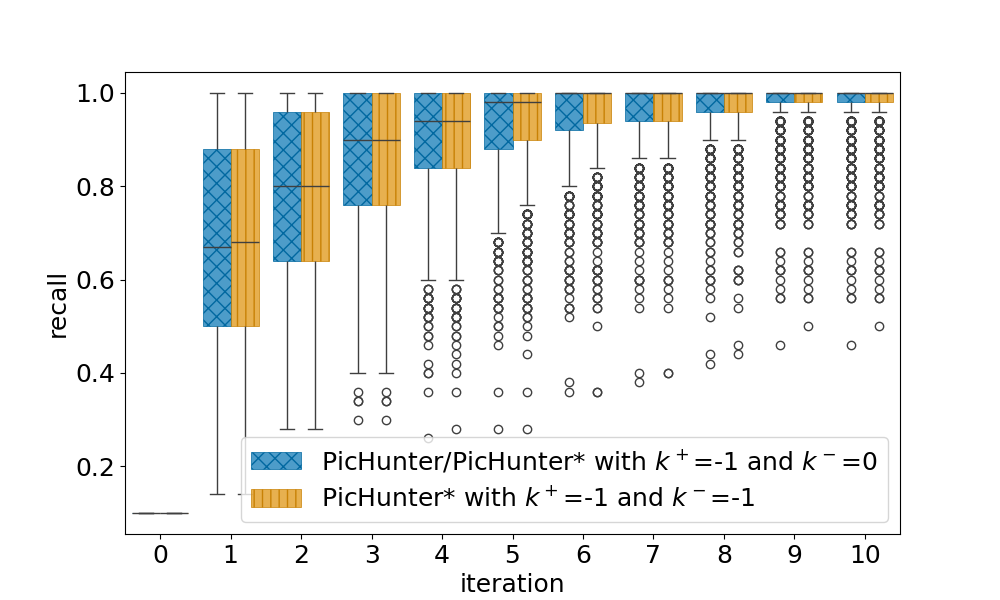
 
  
   -----BATCH UPDATE -----
   
 
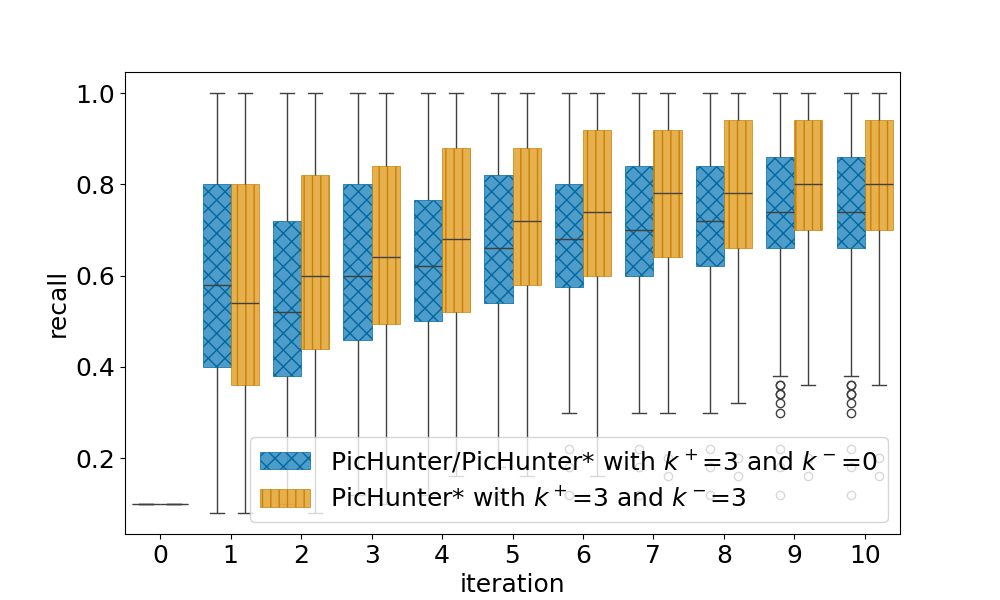


^^^^^^^^^^^^^^^^^
USE BATCH------> False
^^^^^^^^^^^^^^^^^
^^^^  k_pos=-1, k_neg=0, use_batch=False ^^^
                            Method  Count
0            PicHunter* - 8.210553   8800
1   PicHunter* - 82.10553000000002   8800
2   PicHunter* - 821.0553000000001   8800
3  PicHunter* - 0.8210553000000002   8800


/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=-1, k_neg=0, use_batch=False ***
 	 k_pos=-1, k_neg=0,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.017945559156811782, p=0.9967301482752352)
	 k_pos=-1, k_neg=0, it=2 There are statistically significant differences between the methods (ANOVA result: F=94.12035552808452, p=2.2672535678266526e-58).
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.1306    0.0  0.1056 0.1556   True
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.1345    0.0  0.1095 0.1595   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.1348    0.0  0.1098 0.1598  

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


	 k_pos=-1, k_neg=0, it=3 There are statistically significant differences between the methods (ANOVA result: F=116.47043144977029, p=1.4020771756843754e-71).
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.1198    0.0  0.0991 0.1406   True
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.1245    0.0  0.1037 0.1453   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.1256    0.0  0.1048 0.1464   True
          PicHunter* - 8.210553 PicHunter* - 82.10553000000002   0.0047 0.9395 -0.0161 0.0254  False
          PicHunter* - 8.210553 PicHunter* - 821.0553000000001   0.0057  0.894 -0.0151 0.0265  False
 PicHunter* - 82.10553000000002 Pi

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


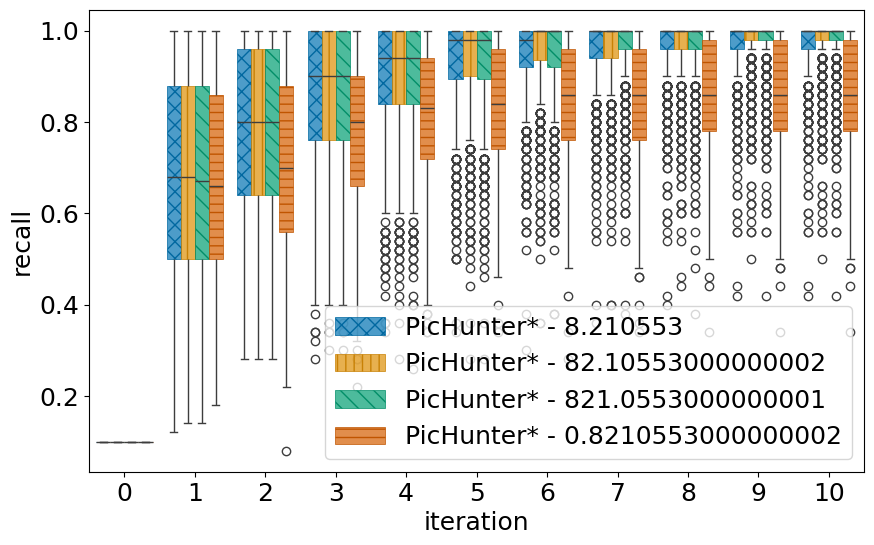

*****
**** Performing statistical tests for k_pos=-1, k_neg=-1, use_batch=False ***
 	 k_pos=-1, k_neg=-1,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.22750718444233012, p=0.8772992132852583)
	 k_pos=-1, k_neg=-1, it=2 There are statistically significant differences between the methods (ANOVA result: F=33.24476021307583, p=3.741972700863722e-21).


/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.0771    0.0  0.0526 0.1016   True
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.0777    0.0  0.0533 0.1022   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.0779    0.0  0.0534 0.1023   True
          PicHunter* - 8.210553 PicHunter* - 82.10553000000002   0.0006 0.9999 -0.0238 0.0251  False
          PicHunter* - 8.210553 PicHunter* - 821.0553000000001   0.0008 0.9998 -0.0237 0.0252  False
 PicHunter* - 82.10553000000002 PicHunter* - 821.0553000000001   0.0001    1.0 -0.0243 0.0246  False
-------------------------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


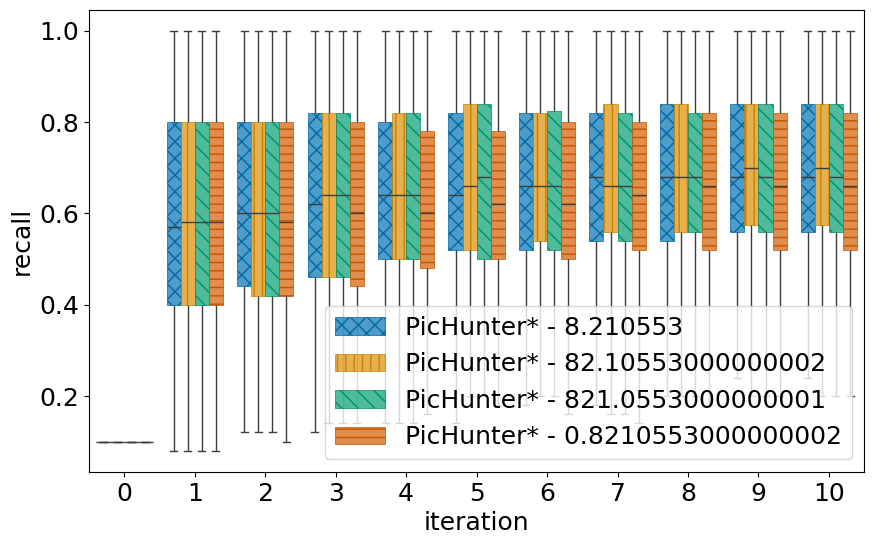

*****
**** Performing statistical tests for k_pos=3, k_neg=0, use_batch=False ***
 	 k_pos=3, k_neg=0,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.002366741649394063, p=0.9998411807624161)
 	 k_pos=3, k_neg=0,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.316234610373648, p=0.8136594981006491)
 	 k_pos=3, k_neg=0,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=1.2157476499681563, p=0.3023469948913885)
 	 k_pos=3, k_neg=0,it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=1.8019488612701335, p=0.14461126228290777)
 	 k_pos=3, k_neg=0,it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=2.1395674098473836, p=0.09314646986602575)
	 k_pos=3, k_neg=0, it=6 There are statistically significant differences between the methods (ANOVA result: F=2.6848505278092882, 

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.0165 0.3536 -0.0093 0.0422  False
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.0259 0.0481  0.0001 0.0516   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.0231 0.0965 -0.0026 0.0488  False
          PicHunter* - 8.210553 PicHunter* - 82.10553000000002   0.0094 0.7833 -0.0163 0.0351  False
          PicHunter* - 8.210553 PicHunter* - 821.0553000000001   0.0066 0.9112 -0.0191 0.0323  False
 PicHunter* - 82.10553000000002 PicHunter* - 821.0553000000001  -0.0028 0.9925 -0.0285 0.0229  False
-------------------------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=3, k_neg=3, use_batch=False ***
 	 k_pos=3, k_neg=3,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00154278366097767, p=0.9999163517955793)
 	 k_pos=3, k_neg=3,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.5005426460401564, p=0.6819218416938135)
 	 k_pos=3, k_neg=3,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=1.028742068217154, p=0.3786717162838044)
 	 k_pos=3, k_neg=3,it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=1.985188728634599, p=0.11402091879102906)
	 k_pos=3, k_neg=3, it=5 There are statistically significant differences between the methods (ANOVA result: F=3.2590343166276403, p=0.020685303376191885).


/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.0277 0.0593 -0.0007 0.0561  False
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002    0.028 0.0556 -0.0004 0.0564  False
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.0289  0.044  0.0005 0.0574   True
          PicHunter* - 8.210553 PicHunter* - 82.10553000000002   0.0003    1.0 -0.0281 0.0287  False
          PicHunter* - 8.210553 PicHunter* - 821.0553000000001   0.0012 0.9995 -0.0272 0.0297  False
 PicHunter* - 82.10553000000002 PicHunter* - 821.0553000000001    0.001 0.9998 -0.0274 0.0294  False
-------------------------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


                            Method  Count
0            PicHunter* - 8.210553   8800
1   PicHunter* - 82.10553000000002   8800
2   PicHunter* - 821.0553000000001   8800
3  PicHunter* - 0.8210553000000002   8800


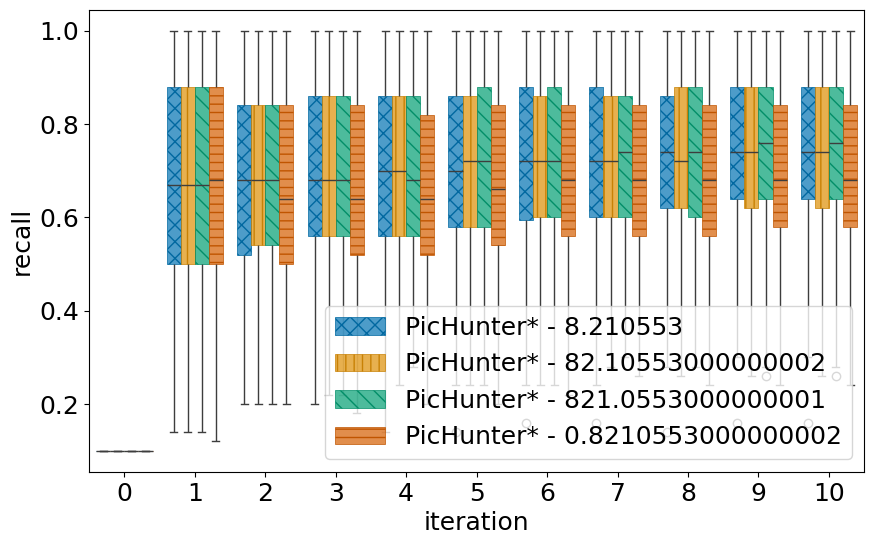

*****
**** Performing statistical tests for k_pos=5, k_neg=0, use_batch=False ***
 	 k_pos=5, k_neg=0,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.017945559156811782, p=0.9967301482752352)
 	 k_pos=5, k_neg=0,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=2.0948243578890735, p=0.09878543352012788)
	 k_pos=5, k_neg=0, it=3 There are statistically significant differences between the methods (ANOVA result: F=3.1583272264072293, p=0.02373426789164384).


/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.0228 0.0968 -0.0026 0.0483  False
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.0253 0.0523 -0.0002 0.0508  False
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.0261 0.0421  0.0006 0.0516   True
          PicHunter* - 8.210553 PicHunter* - 82.10553000000002   0.0025 0.9947  -0.023 0.0279  False
          PicHunter* - 8.210553 PicHunter* - 821.0553000000001   0.0033 0.9878 -0.0222 0.0287  False
 PicHunter* - 82.10553000000002 PicHunter* - 821.0553000000001   0.0008 0.9998 -0.0247 0.0263  False
-------------------------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=5, k_neg=5, use_batch=False ***
 	 k_pos=5, k_neg=5,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.019290521727019207, p=0.9963601454871114)
 	 k_pos=5, k_neg=5,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=2.2515417592945295, p=0.08035906985697912)
	 k_pos=5, k_neg=5, it=3 There are statistically significant differences between the methods (ANOVA result: F=3.564853431497393, p=0.01359842780330178).


/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.0236 0.1027  -0.003 0.0501  False
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.0296 0.0218  0.0031 0.0562   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.0281 0.0329  0.0016 0.0547   True
          PicHunter* - 8.210553 PicHunter* - 82.10553000000002    0.006 0.9366 -0.0205 0.0326  False
          PicHunter* - 8.210553 PicHunter* - 821.0553000000001   0.0046  0.971  -0.022 0.0311  False
 PicHunter* - 82.10553000000002 PicHunter* - 821.0553000000001  -0.0015  0.999  -0.028 0.0251  False
-------------------------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


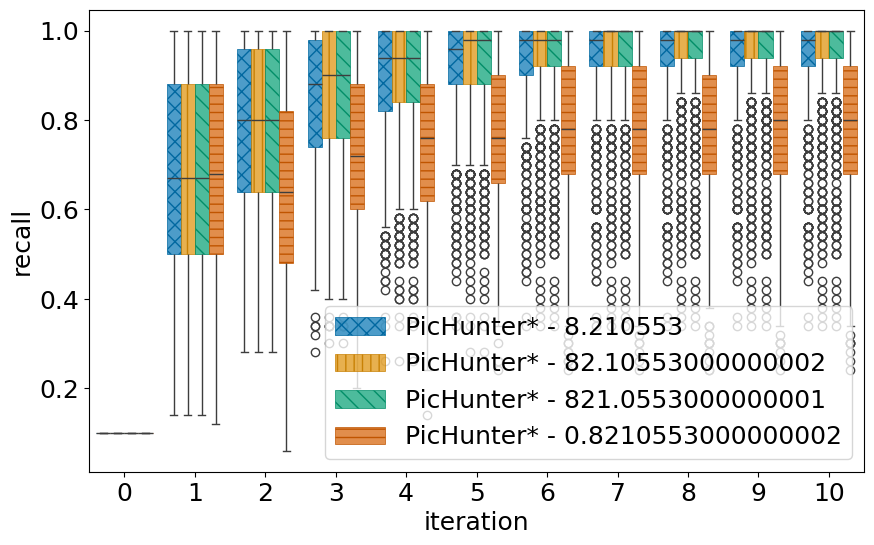

*****
**** Performing statistical tests for k_pos=-1, k_neg=0, use_batch=True ***
 	 k_pos=-1, k_neg=0,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.017945559156811782, p=0.9967301482752352)
	 k_pos=-1, k_neg=0, it=2 There are statistically significant differences between the methods (ANOVA result: F=94.12035552808452, p=2.2672535678266526e-58).
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.1306    0.0  0.1056 0.1556   True
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.1345    0.0  0.1095 0.1595   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.1348    0.0  0.1098 0.1598   

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


	 k_pos=-1, k_neg=0, it=3 There are statistically significant differences between the methods (ANOVA result: F=113.5270265529683, p=7.454673817403715e-70).
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.1198    0.0  0.0988 0.1408   True
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002    0.124    0.0   0.103  0.145   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.1251    0.0  0.1041 0.1461   True
          PicHunter* - 8.210553 PicHunter* - 82.10553000000002   0.0042 0.9557 -0.0168 0.0252  False
          PicHunter* - 8.210553 PicHunter* - 821.0553000000001   0.0053 0.9159 -0.0157 0.0263  False
 PicHunter* - 82.10553000000002 PicH

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


                            Method  Count
0            PicHunter* - 8.210553   8800
1   PicHunter* - 82.10553000000002   8800
2   PicHunter* - 821.0553000000001   8800
3  PicHunter* - 0.8210553000000002   8800


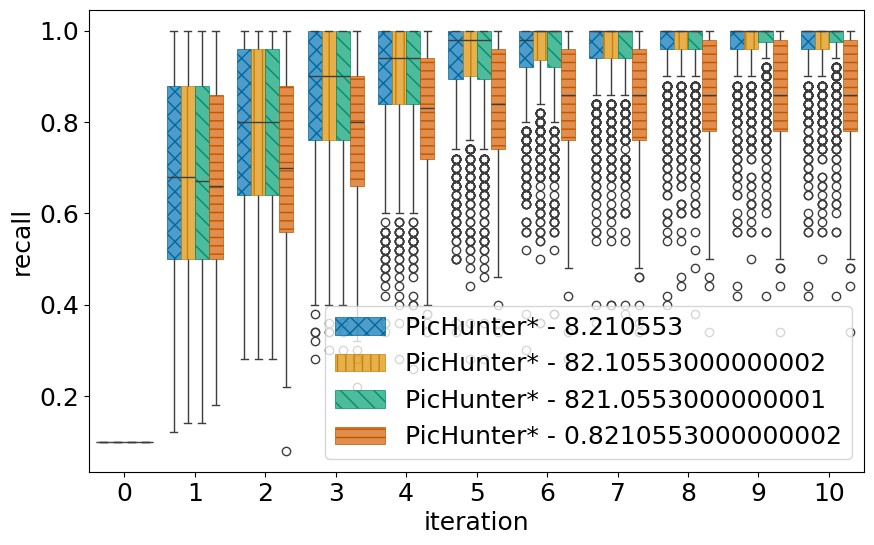

*****
**** Performing statistical tests for k_pos=-1, k_neg=-1, use_batch=True ***
 	 k_pos=-1, k_neg=-1,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.22750718444233012, p=0.8772992132852583)
	 k_pos=-1, k_neg=-1, it=2 There are statistically significant differences between the methods (ANOVA result: F=33.24476021307583, p=3.741972700863722e-21).
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.0771    0.0  0.0526 0.1016   True
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.0777    0.0  0.0533 0.1022   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.0779    0.0  0.0534 0.1023  

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


	 k_pos=-1, k_neg=-1, it=3 There are statistically significant differences between the methods (ANOVA result: F=43.82159490733231, p=9.55554914557023e-28).
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.0725    0.0  0.0522 0.0928   True
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.0742    0.0  0.0539 0.0945   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001    0.075    0.0  0.0547 0.0953   True
          PicHunter* - 8.210553 PicHunter* - 82.10553000000002   0.0017 0.9965 -0.0186  0.022  False
          PicHunter* - 8.210553 PicHunter* - 821.0553000000001   0.0025  0.989 -0.0178 0.0228  False
 PicHunter* - 82.10553000000002 PicH

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


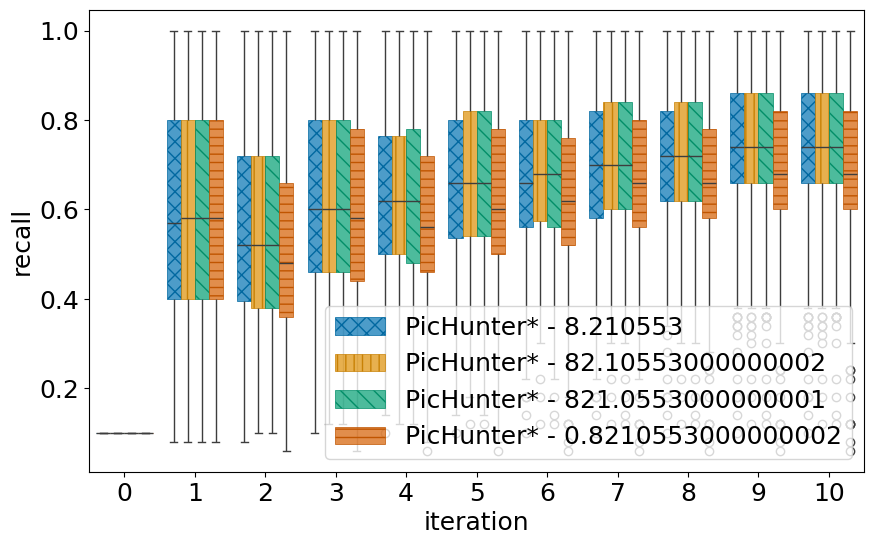

*****
**** Performing statistical tests for k_pos=3, k_neg=0, use_batch=True ***
 	 k_pos=3, k_neg=0,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.002366741649394063, p=0.9998411807624161)
	 k_pos=3, k_neg=0, it=2 There are statistically significant differences between the methods (ANOVA result: F=3.1187353451170194, p=0.02505019484845493).
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.0282 0.0671 -0.0013 0.0577  False
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.0289 0.0567 -0.0006 0.0584  False
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.0288 0.0583 -0.0007 0.0583  False


/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


 	 k_pos=3, k_neg=0,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=1.5339609636880236, p=0.20360280741342074)
	 k_pos=3, k_neg=0, it=4 There are statistically significant differences between the methods (ANOVA result: F=6.872348741107282, p=0.0001302871639581128).
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.0338 0.0042   0.008 0.0597   True
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.0388 0.0007  0.0129 0.0646   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.0383 0.0008  0.0125 0.0642   True
          PicHunter* - 8.210553 PicHunter* - 82.10553000000002   0.0049 0.9613 -0

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


                            Method  Count
0            PicHunter* - 8.210553   8800
1   PicHunter* - 82.10553000000002   8800
2   PicHunter* - 821.0553000000001   8800
3  PicHunter* - 0.8210553000000002   8800


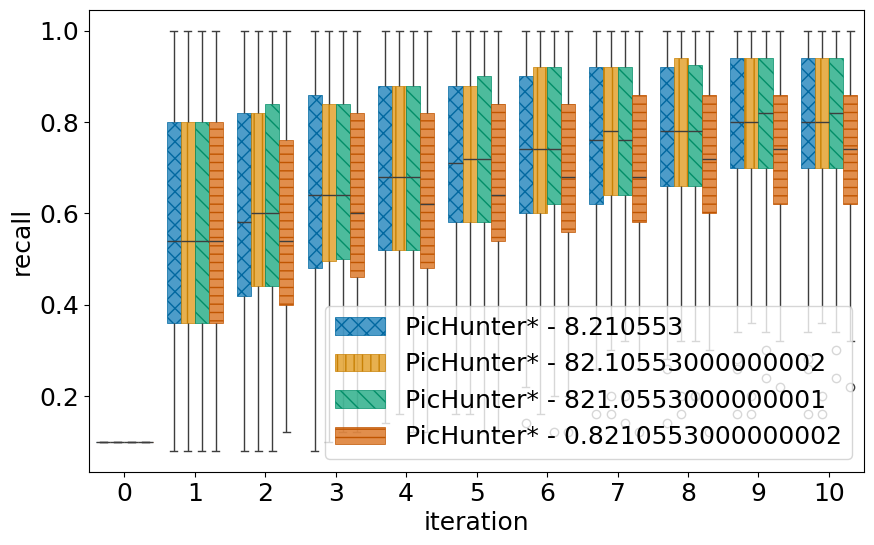

*****
**** Performing statistical tests for k_pos=3, k_neg=3, use_batch=True ***
 	 k_pos=3, k_neg=3,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00154278366097767, p=0.9999163517955793)
	 k_pos=3, k_neg=3, it=2 There are statistically significant differences between the methods (ANOVA result: F=4.63502093235952, p=0.0030773462687216043).


/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.0314   0.04   0.001 0.0619   True
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.0379 0.0076  0.0074 0.0683   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.0374 0.0086   0.007 0.0679   True
          PicHunter* - 8.210553 PicHunter* - 82.10553000000002   0.0065  0.948  -0.024 0.0369  False
          PicHunter* - 8.210553 PicHunter* - 821.0553000000001    0.006 0.9575 -0.0244 0.0364  False
 PicHunter* - 82.10553000000002 PicHunter* - 821.0553000000001  -0.0005    1.0 -0.0309   0.03  False
-------------------------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


                            Method  Count
0            PicHunter* - 8.210553   8800
1   PicHunter* - 82.10553000000002   8800
2   PicHunter* - 821.0553000000001   8800
3  PicHunter* - 0.8210553000000002   8800


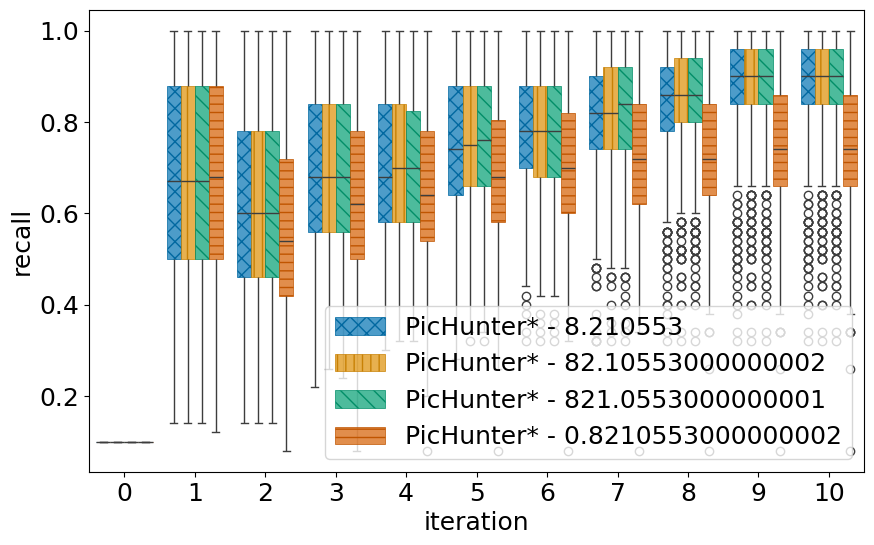

*****
**** Performing statistical tests for k_pos=5, k_neg=0, use_batch=True ***
 	 k_pos=5, k_neg=0,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.017945559156811782, p=0.9967301482752352)
	 k_pos=5, k_neg=0, it=2 There are statistically significant differences between the methods (ANOVA result: F=8.834334637151427, p=7.87245481786912e-06).


/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.0433 0.0003  0.0159 0.0707   True
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002   0.0449 0.0002  0.0175 0.0723   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.0461 0.0001  0.0187 0.0735   True
          PicHunter* - 8.210553 PicHunter* - 82.10553000000002   0.0016 0.9988 -0.0258  0.029  False
          PicHunter* - 8.210553 PicHunter* - 821.0553000000001   0.0028 0.9935 -0.0246 0.0302  False
 PicHunter* - 82.10553000000002 PicHunter* - 821.0553000000001   0.0012 0.9995 -0.0262 0.0286  False
-------------------------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


                            Method  Count
0            PicHunter* - 8.210553   8800
1   PicHunter* - 82.10553000000002   8800
2   PicHunter* - 821.0553000000001   8800
3  PicHunter* - 0.8210553000000002   8800


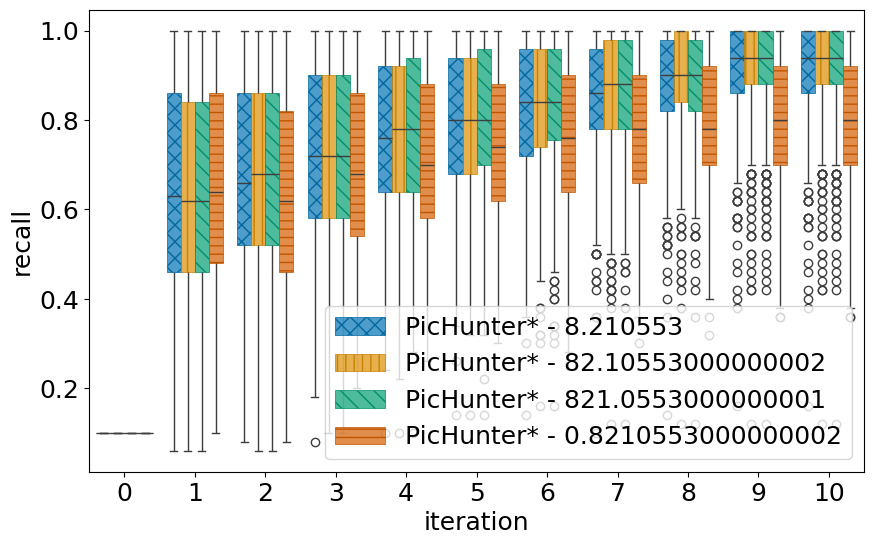

*****
**** Performing statistical tests for k_pos=5, k_neg=5, use_batch=True ***
 	 k_pos=5, k_neg=5,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.019290521727019207, p=0.9963601454871114)
	 k_pos=5, k_neg=5, it=2 There are statistically significant differences between the methods (ANOVA result: F=7.005318211487172, p=0.00010780111873376814).


/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
             group1                         group2             meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------------------------------------
PicHunter* - 0.8210553000000002          PicHunter* - 8.210553   0.0381 0.0023  0.0104 0.0659   True
PicHunter* - 0.8210553000000002 PicHunter* - 82.10553000000002    0.041 0.0008  0.0133 0.0687   True
PicHunter* - 0.8210553000000002 PicHunter* - 821.0553000000001   0.0416 0.0007  0.0139 0.0693   True
          PicHunter* - 8.210553 PicHunter* - 82.10553000000002   0.0029 0.9935 -0.0249 0.0306  False
          PicHunter* - 8.210553 PicHunter* - 821.0553000000001   0.0035 0.9887 -0.0243 0.0312  False
 PicHunter* - 82.10553000000002 PicHunter* - 821.0553000000001   0.0006 0.9999 -0.0271 0.0283  False
-------------------------------------------------------------------------------------------

In [8]:
#test temperature
use_batch = False
print("^^^^^^^^^^^^^^^^^")
print ("USE BATCH------>", use_batch)  
print("^^^^^^^^^^^^^^^^^")

prefixplot='PicHunter*'

##testing fun_name
fun_name='softmin'
df_temp=df_method[(df_method['fun_name']==fun_name ) & (df_method['method']==prefixplot)]
#df_temp=df_method[(df_method['fun_name']==fun_name ) & (df_method['method']==prefixplot)]
# df_temp=df_method[ (df_method['method']==prefixplot) & ((abs(df_method['temperature']- 821.0553 )<1)| (abs(df_method['temperature']-23.878746)<1))]
plot_and_statistical_test_varying_fun(df_temp, prefixplot,use_batch,print_fun_name=False,print_temperature=True,print_data_preprocessing=False, print_k_pos_k_neg=False, use_wilcoxon=False)

#test temperature
use_batch = True
print("^^^^^^^^^^^^^^^^^")
print ("USE BATCH------>", use_batch)  
print("^^^^^^^^^^^^^^^^^")

prefixplot='PicHunter*'

##testing fun_name
fun_name='softmin'
df_temp=df_method[(df_method['fun_name']==fun_name ) & (df_method['method']==prefixplot)]
#df_temp=df_method[(df_method['fun_name']==fun_name ) & (df_method['method']==prefixplot)]
# df_temp=df_method[ (df_method['method']==prefixplot) & ((abs(df_method['temperature']- 821.0553 )<1)| (abs(df_method['temperature']-23.878746)<1))]
plot_and_statistical_test_varying_fun(df_temp, prefixplot,use_batch,print_fun_name=False,print_temperature=True,print_data_preprocessing=False, print_k_pos_k_neg=False, use_wilcoxon=False)

^^^^^^^^^^^^^^^^^
USE BATCH------> False
^^^^^^^^^^^^^^^^^
^^^^  k_pos=3, use_batch=False ^^^
                                          Method  Count
0  PicHunter/PicHunter* with $k^+$=3 and $k^-$=0   8800
1            PicHunter* with $k^+$=3 and $k^-$=3   8800


/tmp/ipykernel_776128/3096688082.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


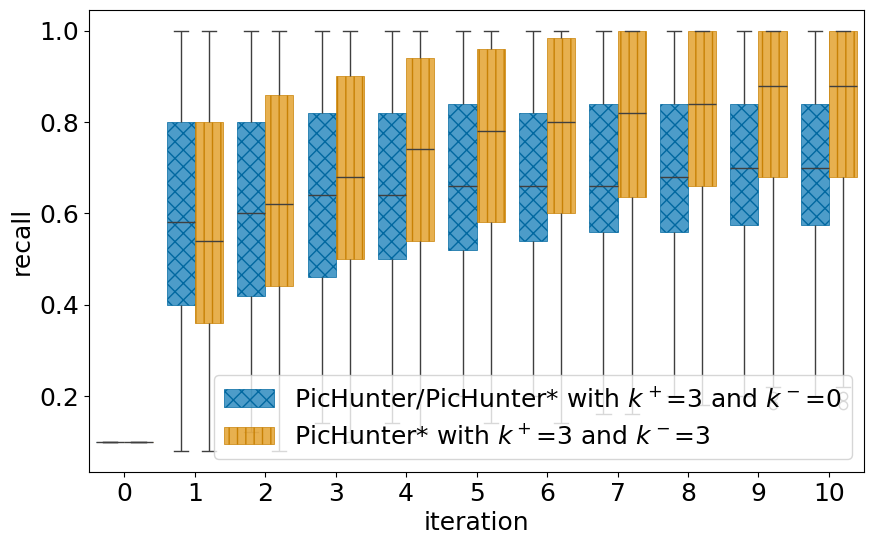

*****
**** Performing statistical tests for k_pos=3,, use_batch=False ***
	 k_pos=3, it=1 There are statistically significant differences between the methods (ANOVA result: F=4.509460589240505, p=0.0338611466196967).
                                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                                 
               group1                                   group2                    meandiff p-adj  lower  upper reject
---------------------------------------------------------------------------------------------------------------------
PicHunter* with $k^+$=3 and $k^-$=3 PicHunter/PicHunter* with $k^+$=3 and $k^-$=0    0.027 0.0339 0.0021 0.052   True
---------------------------------------------------------------------------------------------------------------------
 	 k_pos=3, it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=2.467959333185489, p=0.11638665375690879)
	 k_pos=3, it=3 There are statistically sign

/tmp/ipykernel_776128/3096688082.py:260: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                                   
               group1                                   group2                    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------------
PicHunter* with $k^+$=3 and $k^-$=3 PicHunter/PicHunter* with $k^+$=3 and $k^-$=0  -0.0384 0.0009 -0.0611 -0.0157   True
------------------------------------------------------------------------------------------------------------------------
	 k_pos=3, it=4 There are statistically significant differences between the methods (ANOVA result: F=27.493723446343576, p=1.7864850644207463e-07).
                                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                                 
               group1                                   group2                    meandiff p-adj lower  upper  reject
-----------

/tmp/ipykernel_776128/3096688082.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


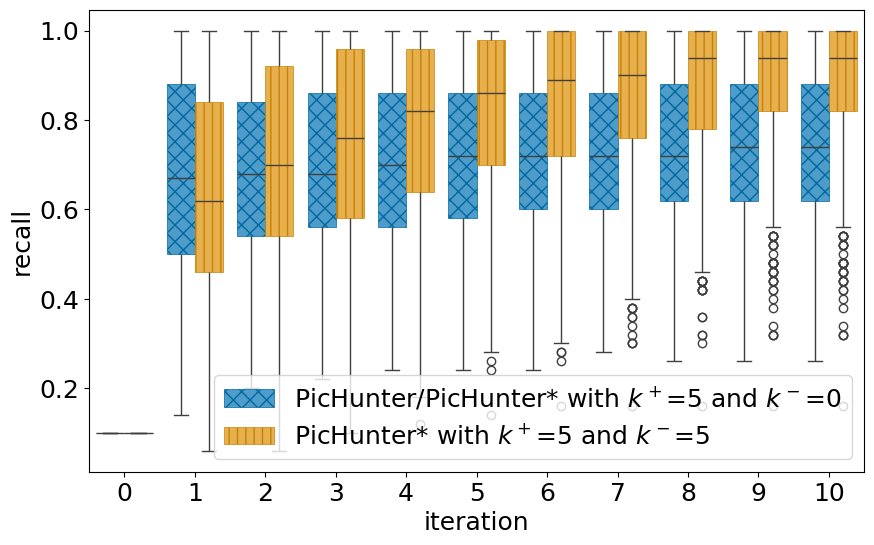

*****
**** Performing statistical tests for k_pos=5,, use_batch=False ***
	 k_pos=5, it=1 There are statistically significant differences between the methods (ANOVA result: F=8.580524945776768, p=0.0034459449703343912).
                                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                                  
               group1                                   group2                    meandiff p-adj  lower  upper  reject
----------------------------------------------------------------------------------------------------------------------
PicHunter* with $k^+$=5 and $k^-$=5 PicHunter/PicHunter* with $k^+$=5 and $k^-$=0    0.033 0.0034 0.0109 0.0551   True
----------------------------------------------------------------------------------------------------------------------
	 k_pos=5, it=2 There are statistically significant differences between the methods (ANOVA result: F=4.311619739569824, p=0.03801241000447572).


/tmp/ipykernel_776128/3096688082.py:260: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                                  
               group1                                   group2                    meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------------------------------------------------------
PicHunter* with $k^+$=5 and $k^-$=5 PicHunter/PicHunter* with $k^+$=5 and $k^-$=0   -0.022 0.038 -0.0427 -0.0012   True
-----------------------------------------------------------------------------------------------------------------------
	 k_pos=5, it=3 There are statistically significant differences between the methods (ANOVA result: F=28.14179644255115, p=1.2853417476631044e-07).
                                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                                  
               group1                                   group2                    meandiff p-adj lower   upper  reject
---------------

/tmp/ipykernel_776128/3096688082.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=-1,, use_batch=False ***
 	 k_pos=-1, it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=5.269173832781558e-06, p=0.9981687695402217)
 	 k_pos=-1, it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0007264058207307607, p=0.9785014501382576)
 	 k_pos=-1, it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0008487409673491268, p=0.9767620275836698)
 	 k_pos=-1, it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.01690419318588485, p=0.8965700312511155)
 	 k_pos=-1, it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.036191672890506524, p=0.8491443758602168)
 	 k_pos=-1, it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0001041412097454891, p=0.9918590350595204)
 	 k_pos=-

/tmp/ipykernel_776128/3096688082.py:260: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


In [9]:
use_batch = False
print("^^^^^^^^^^^^^^^^^")
print ("USE BATCH------>", use_batch)  
print("^^^^^^^^^^^^^^^^^")

# prefixplot='PicHunter*'

##testing fun_name
#fun_name='l1_normalized_cosine'
#df_temp=df_method[(df_method['fun_name']==fun_name ) & (df_method['method']==prefixplot) & (df_method['temperature']!=1)]
#df_temp=df_method[(df_method['fun_name']==fun_name ) & (df_method['method']==prefixplot)]
# df_temp=df_method[ (df_method['method']==prefixplot) & ((abs(df_method['temperature']- 821.0553 )<1)| (abs(df_method['temperature']-23.878746)<1))]
# plot_and_statistical_test_varying_fun(df_temp, prefixplot,use_batch,print_fun_name=True,print_temperature=True,print_data_preprocessing=False,
#                                            print_k_pos_k_neg=False)

##### --->Take away : we use softmin with temperature 100\eta

##testing fun_name
df_Pic=df_method.copy()

df_Pic.loc[df_Pic['k_neg']==0,'method']='PicHunter/PicHunter*'
df_Pic=df_Pic[(abs(df_Pic['temperature']- 82.1553 )<1) & (df_Pic['fun_name']=='softmin')]
df_Pic.loc[:,'fun_name']=' '
plot_and_statistical_test_varying_k(df_Pic, prefixplot,use_batch,print_fun_name=False,print_temperature=False,print_data_preprocessing=False,
                                           print_k_pos_k_neg=True)
# use_batch = True
# print("^^^^^^^^^^^^^^^^^")
# print ("USE BATCH------>", use_batch)  
# print("^^^^^^^^^^^^^^^^^")
# plot_and_statistical_test_varying_k(df_Pic, prefixplot,use_batch,print_fun_name=False,print_temperature=False,print_data_preprocessing=False,
#                                            print_k_pos_k_neg=True)


In [10]:
#comparing batch update with incremental update
df_Pic=df_method.copy()
df_Pic=df_Pic[(abs(df_Pic['temperature']- 82.1553 )<1) & (df_Pic['fun_name']=='softmin')]
df_Pic.loc[:,'fun_name']=' '

print('Pichunter*')
print(df_Pic['method'].unique())
print(df_Pic['k_pos'].unique())
print(df_Pic['k_neg'].unique())
print(df_Pic['use_batch'].unique())
print('******')
#now we create add the Pichunter method to the df_Pic dataframe . 
df_pic_no_neg=df_Pic[df_Pic['k_neg']==0].copy()
df_pic_no_neg.loc[:,'method']='PicHunter'
print('Pichunter k_neg=0')
print(df_pic_no_neg['method'].unique())
print(df_pic_no_neg['k_pos'].unique())
print(df_pic_no_neg['k_neg'].unique())
print(df_pic_no_neg['use_batch'].unique())
print('******')
#for all rows df_pic_no_neg I duplicate it to have one as it is (with k_neg=0) and one where I set k_neg=K_pos #this is the treditional Pichunte method that do not use negative
#pichunter ussing k_pos=k1 and k_neg=k2 has teh same results than using k_pos=k1 and k_neg=0 since negative examples are not explicitely used in traditional PicHunter
df_pic_no_neg2=df_pic_no_neg.copy()
df_pic_no_neg2.loc[:,'k_neg']=df_pic_no_neg2['k_pos']
print('Pichunter k_neg=k_pos but not used (same results as k_neg=0)')
print(df_pic_no_neg2['method'].unique())
print(df_pic_no_neg2['k_pos'].unique())
print(df_pic_no_neg2['k_neg'].unique())
print(df_pic_no_neg2['use_batch'].unique())
print('******')
df_Pic=pd.concat([df_Pic,df_pic_no_neg,df_pic_no_neg2], ignore_index=True)

print('Final dataframe ')
print(df_Pic['method'].unique())
print(df_Pic['k_pos'].unique())
print(df_Pic['k_neg'].unique())
print(df_Pic['use_batch'].unique())

Pichunter*
['PicHunter*']
[-1  3  5]
[ 0 -1  3  5]
[ True False]
******
Pichunter k_neg=0
['PicHunter']
[-1  3  5]
[0]
[ True False]
******
Pichunter k_neg=k_pos but not used (same results as k_neg=0)
['PicHunter']
[-1  3  5]
[-1  3  5]
[ True False]
******
Final dataframe 
['PicHunter*' 'PicHunter']
[-1  3  5]
[ 0 -1  3  5]
[ True False]


^^^^  k_pos=-1, k_neg=0 ^^^
                      Method  Count
0         PicHunter -  Batch   8800
1  PicHunter -  Incremental    8800


/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=-1,, k_neg=0 ***
 	 k_pos=-1, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=-1, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=-1, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.024860111584171396, p=0.874736054738004)
 	 k_pos=-1, k_neg=0 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.3453785670356353, p=0.5568239756238063)
 	 k_pos=-1, k_neg=0 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=1.6063933347481403, p=0.20518419007078434)
	 k_pos=-1, k_neg=0, it=6 There are statistically significant differences between the methods (ANOVA result: F=5.0826696128157485, p=0.024301060225371405).
               Multiple Comparison of Means -

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
      group1                 group2          meandiff p-adj  lower  upper  reject
---------------------------------------------------------------------------------
PicHunter -  Batch PicHunter -  Incremental    0.0177 0.0004 0.0079 0.0274   True
---------------------------------------------------------------------------------
	 k_pos=-1, k_neg=0, it=8 There are statistically significant differences between the methods (ANOVA result: F=21.306417563234195, p=4.227087318551548e-06).
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1                 group2          meandiff p-adj lower upper  reject
-------------------------------------------------------------------------------
PicHunter -  Batch PicHunter -  Incremental    0.0226   0.0 0.013 0.0322   True
-------------------------------------------------------------------------------
	 k_pos=-1, k_neg=0, it=9 There a

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


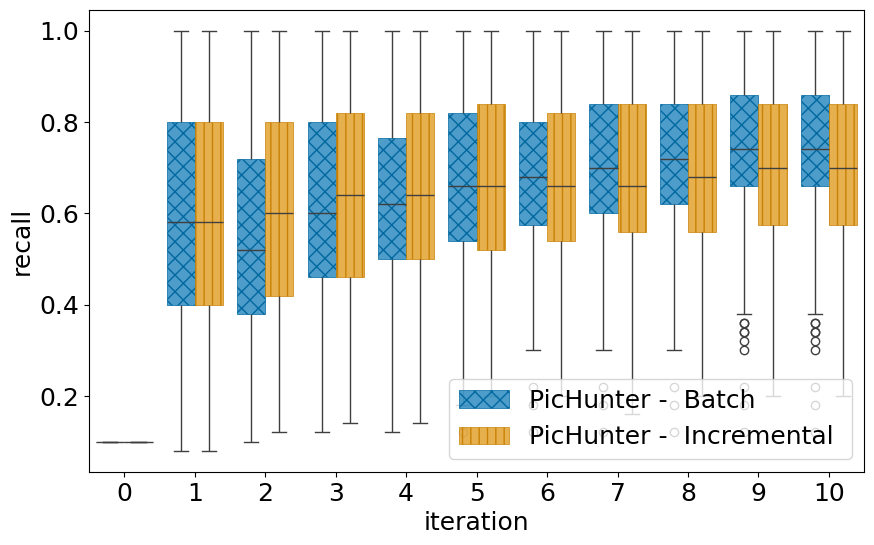

*****
**** Performing statistical tests for k_pos=3,, k_neg=0 ***
 	 k_pos=3, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
	 k_pos=3, k_neg=0, it=2 There are statistically significant differences between the methods (ANOVA result: F=24.79801608148251, p=7.055592281886067e-07).
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1                 group2          meandiff p-adj lower upper  reject
-------------------------------------------------------------------------------
PicHunter -  Batch PicHunter -  Incremental    0.0577   0.0 0.035 0.0804   True
-------------------------------------------------------------------------------
 	 k_pos=3, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=1.719835764361562, p=0.18990257838942048)
 	 k_pos=3, k_neg=0 it=4, There are NO statistically significant differences between the method

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
      group1                 group2          meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------------------
PicHunter -  Batch PicHunter -  Incremental   -0.0304 0.0007 -0.0481 -0.0128   True
-----------------------------------------------------------------------------------
	 k_pos=3, k_neg=0, it=8 There are statistically significant differences between the methods (ANOVA result: F=16.979766912680002, p=3.971604627727788e-05).
               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
      group1                 group2          meandiff p-adj  lower   upper  reject
----------------------------------------------------------------------------------
PicHunter -  Batch PicHunter -  Incremental   -0.0359   0.0 -0.0531 -0.0188   True
----------------------------------------------------------------------------------
	 k_pos=3

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=5,, k_neg=0 ***
 	 k_pos=5, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
	 k_pos=5, k_neg=0, it=2 There are statistically significant differences between the methods (ANOVA result: F=29.262546398677486, p=7.279845351814054e-08).
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1                 group2          meandiff p-adj lower upper reject
------------------------------------------------------------------------------
PicHunter -  Batch PicHunter -  Incremental    0.0565   0.0 0.036 0.077   True
------------------------------------------------------------------------------
 	 k_pos=5, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.010392384587573392, p=0.9188146720020199)
 	 k_pos=5, k_neg=0 it=4, There are NO statistically significant differences between the methods.

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
      group1                 group2          meandiff p-adj  lower   upper  reject
----------------------------------------------------------------------------------
PicHunter -  Batch PicHunter -  Incremental   -0.0403   0.0 -0.0568 -0.0237   True
----------------------------------------------------------------------------------
	 k_pos=5, k_neg=0, it=6 There are statistically significant differences between the methods (ANOVA result: F=47.23909197321325, p=8.977639645704081e-12).
               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
      group1                 group2          meandiff p-adj  lower   upper  reject
----------------------------------------------------------------------------------
PicHunter -  Batch PicHunter -  Incremental   -0.0547   0.0 -0.0703 -0.0391   True
----------------------------------------------------------------------------------
	 k_pos=5, k_ne

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


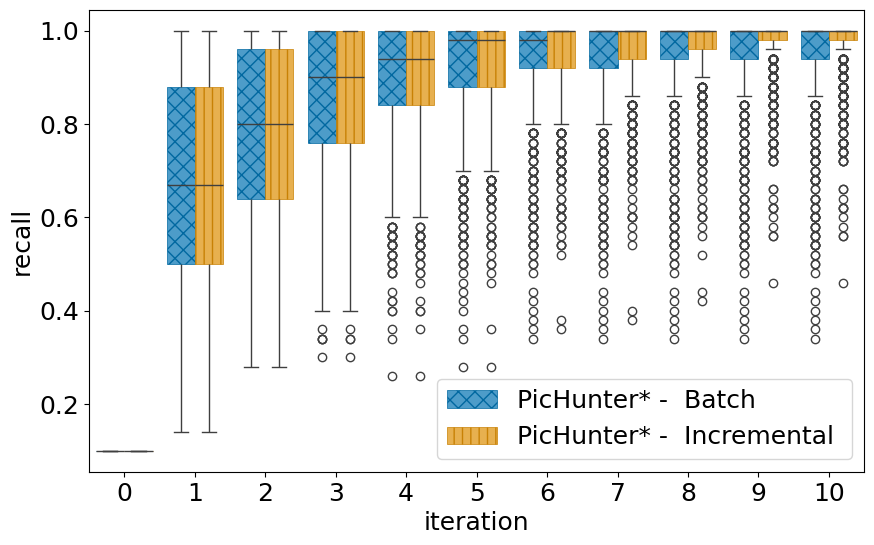

*****
**** Performing statistical tests for k_pos=-1,, k_neg=0 ***
 	 k_pos=-1, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=-1, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=-1, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.024860111584171396, p=0.874736054738004)
 	 k_pos=-1, k_neg=0 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.3453785670356353, p=0.5568239756238063)
 	 k_pos=-1, k_neg=0 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=1.6063933347481403, p=0.20518419007078434)
	 k_pos=-1, k_neg=0, it=6 There are statistically significant differences between the methods (ANOVA result: F=5.0826696128157485, p=0.024301060225371405).
                Multiple Comparison of Means 

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
       group1                 group2           meandiff p-adj  lower  upper  reject
-----------------------------------------------------------------------------------
PicHunter* -  Batch PicHunter* -  Incremental    0.0177 0.0004 0.0079 0.0274   True
-----------------------------------------------------------------------------------
	 k_pos=-1, k_neg=0, it=8 There are statistically significant differences between the methods (ANOVA result: F=21.306417563234195, p=4.227087318551548e-06).
               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1                 group2           meandiff p-adj lower upper  reject
---------------------------------------------------------------------------------
PicHunter* -  Batch PicHunter* -  Incremental    0.0226   0.0 0.013 0.0322   True
---------------------------------------------------------------------------------
	 k_pos=-1, k

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


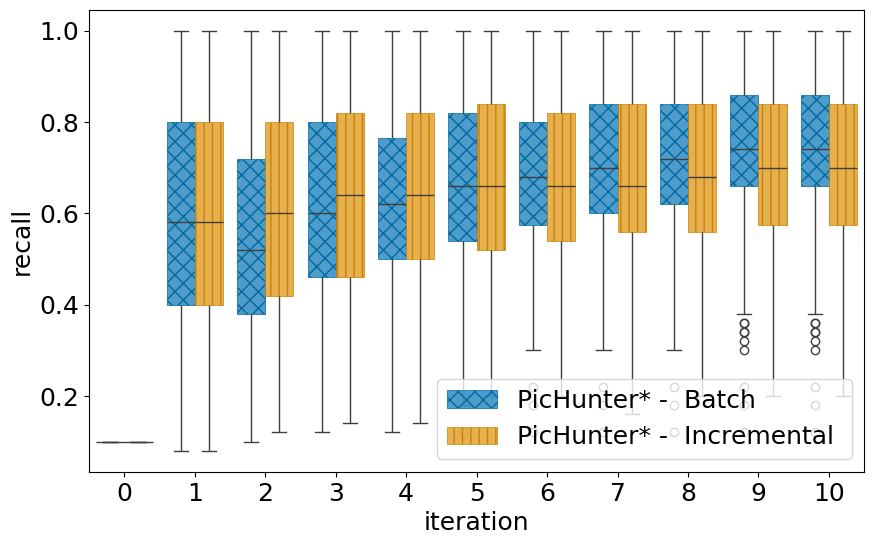

*****
**** Performing statistical tests for k_pos=3,, k_neg=0 ***
 	 k_pos=3, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
	 k_pos=3, k_neg=0, it=2 There are statistically significant differences between the methods (ANOVA result: F=24.79801608148251, p=7.055592281886067e-07).
               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1                 group2           meandiff p-adj lower upper  reject
---------------------------------------------------------------------------------
PicHunter* -  Batch PicHunter* -  Incremental    0.0577   0.0 0.035 0.0804   True
---------------------------------------------------------------------------------
 	 k_pos=3, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=1.719835764361562, p=0.18990257838942048)
 	 k_pos=3, k_neg=0 it=4, There are NO statistically significant differences between 

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
       group1                 group2           meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------------------
PicHunter* -  Batch PicHunter* -  Incremental   -0.0304 0.0007 -0.0481 -0.0128   True
-------------------------------------------------------------------------------------
	 k_pos=3, k_neg=0, it=8 There are statistically significant differences between the methods (ANOVA result: F=16.979766912680002, p=3.971604627727788e-05).
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
       group1                 group2           meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------------------
PicHunter* -  Batch PicHunter* -  Incremental   -0.0359   0.0 -0.0531 -0.0188   True
--------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


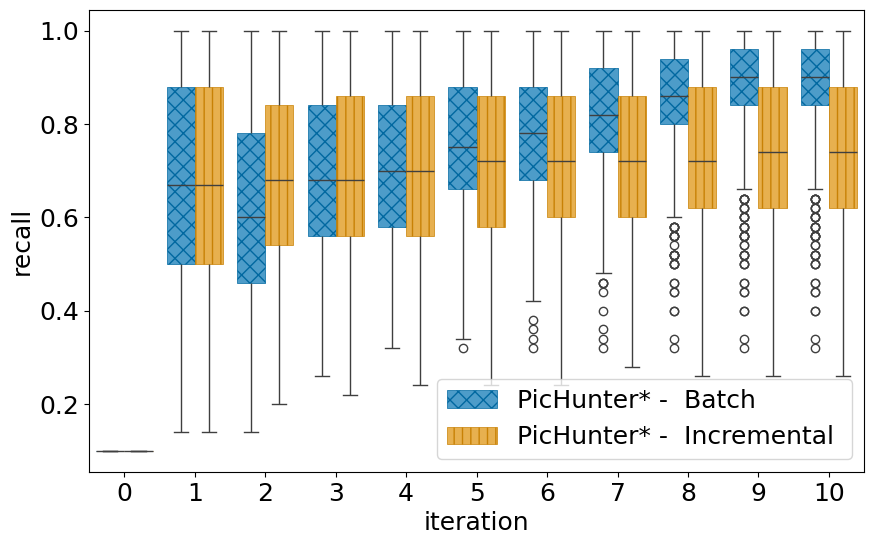

*****
**** Performing statistical tests for k_pos=5,, k_neg=0 ***
 	 k_pos=5, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
	 k_pos=5, k_neg=0, it=2 There are statistically significant differences between the methods (ANOVA result: F=29.262546398677486, p=7.279845351814054e-08).
              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1                 group2           meandiff p-adj lower upper reject
--------------------------------------------------------------------------------
PicHunter* -  Batch PicHunter* -  Incremental    0.0565   0.0 0.036 0.077   True
--------------------------------------------------------------------------------
 	 k_pos=5, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.010392384587573392, p=0.9188146720020199)
 	 k_pos=5, k_neg=0 it=4, There are NO statistically significant differences between th

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
       group1                 group2           meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------------------
PicHunter* -  Batch PicHunter* -  Incremental   -0.0403   0.0 -0.0568 -0.0237   True
------------------------------------------------------------------------------------
	 k_pos=5, k_neg=0, it=6 There are statistically significant differences between the methods (ANOVA result: F=47.23909197321325, p=8.977639645704081e-12).
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
       group1                 group2           meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------------------
PicHunter* -  Batch PicHunter* -  Incremental   -0.0547   0.0 -0.0703 -0.0391   True
--------------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


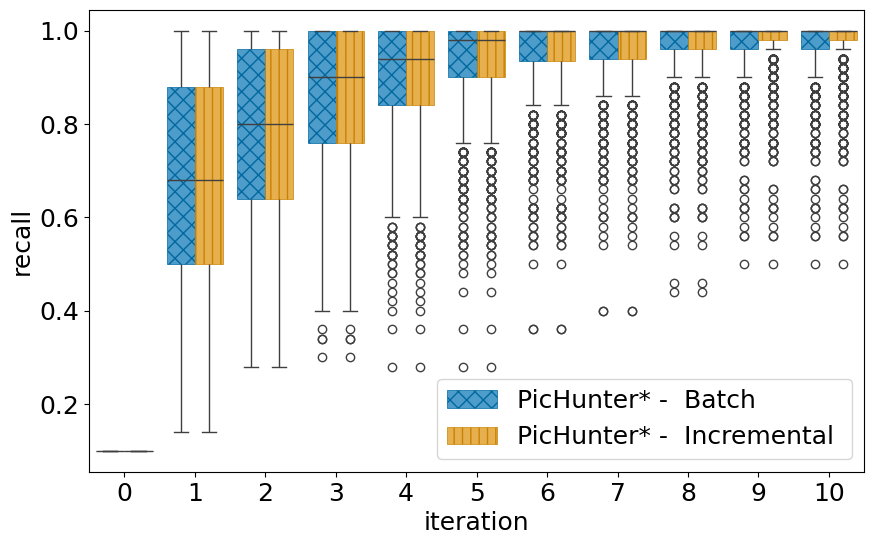

*****
**** Performing statistical tests for k_pos=-1,, k_neg=-1 ***
 	 k_pos=-1, k_neg=-1 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=-1, k_neg=-1 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=-1, k_neg=-1 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=1.0458048520030586e-05, p=0.9974201367448838)
 	 k_pos=-1, k_neg=-1 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=5.9188914086771434e-05, p=0.9938625492922535)
 	 k_pos=-1, k_neg=-1 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0012671628002870637, p=0.9716079627829777)
 	 k_pos=-1, k_neg=-1 it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.005831154482308171, p=0.939140662673758)
 	 k_pos=-1, k_neg=-1 it=7

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


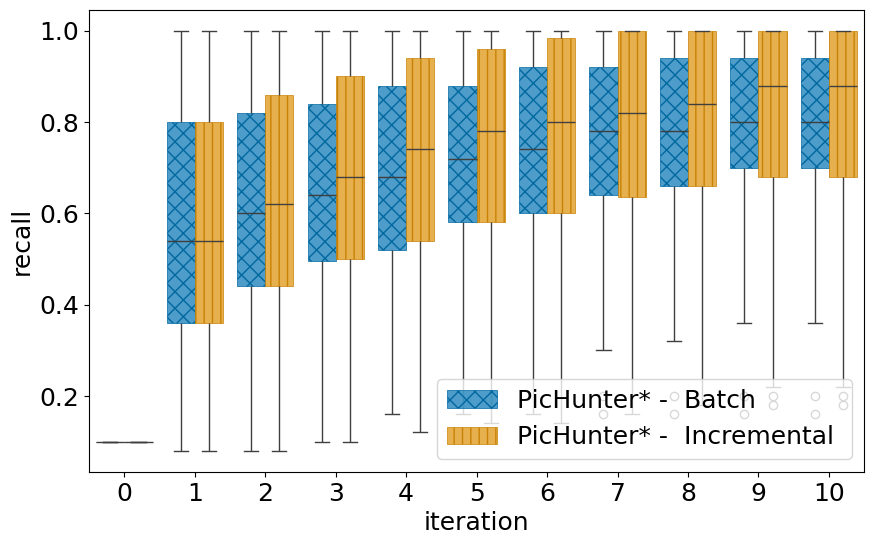

*****
**** Performing statistical tests for k_pos=3,, k_neg=3 ***
 	 k_pos=3, k_neg=3 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=3, k_neg=3 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=1.1344837911879335, p=0.2869818619179212)
 	 k_pos=3, k_neg=3 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=2.222096762793379, p=0.13624553528536879)
 	 k_pos=3, k_neg=3 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=2.7453148818296462, p=0.09773616419442638)
 	 k_pos=3, k_neg=3 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=3.395874151559369, p=0.06554483440340673)
 	 k_pos=3, k_neg=3 it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=2.651946351696687, p=0.103620310041758)
	 k_pos=3, k_neg=3, it=

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=5,, k_neg=5 ***
 	 k_pos=5, k_neg=5 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
	 k_pos=5, k_neg=5, it=2 There are statistically significant differences between the methods (ANOVA result: F=4.905680612246192, p=0.026909095860964592).
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
       group1                 group2           meandiff p-adj  lower  upper  reject
-----------------------------------------------------------------------------------
PicHunter* -  Batch PicHunter* -  Incremental     0.024 0.0269 0.0027 0.0452   True
-----------------------------------------------------------------------------------
 	 k_pos=5, k_neg=5 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=3.401317597563658, p=0.06532936126298591)
 	 k_pos=5, k_neg=5 it=4, There are NO statistically significant differences

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
       group1                 group2           meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------------------
PicHunter* -  Batch PicHunter* -  Incremental   -0.0167 0.0152 -0.0302 -0.0032   True
-------------------------------------------------------------------------------------
	 k_pos=5, k_neg=5, it=9 There are statistically significant differences between the methods (ANOVA result: F=19.20413941066535, p=1.2510915056990503e-05).
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
       group1                 group2           meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------------------
PicHunter* -  Batch PicHunter* -  Incremental   -0.0284   0.0 -0.0412 -0.0157   True
--------------------------------------------------------------------------

In [11]:
plot_and_statistical_test_varying_update(df_Pic[df_Pic['method']=='PicHunter'], 'PicHunter', k_pos_neg_list=[(-1,0), (3,0), (5,0)],max_iter=10)

plot_and_statistical_test_varying_update(df_Pic[df_Pic['method']=='PicHunter*'], 'PicHunter*', k_pos_neg_list=[(-1,0), (3,0), (5,0),(-1,-1), (3,3), (5,5)],max_iter=10)

#-> batch may have better results in teh last iterations but sometimes worse in the first iterations.so we used teh traditional incremental update 

# Poly

In [12]:
methods=['Polyquery', 'Polyquery_msed_logscale']
method="PolyadicSearch"
df_method=select_and_save_method_df(df.copy(), methods, data_preprocessing=['logistic_L1_normalized','softmax', 'L2_normalized'])
print(df_method['method'].unique())
print(df_method['fun_name'].unique())
print(df_method['data_preprocessing'].unique())
df_method.loc[:,'method']=method
print(df_method['method'].unique())
print(df_method['fun_name'].unique())
print(df_method['data_preprocessing'].unique())
df_method.head()

(316800, 18)
['Polyquery' 'Polyquery_msed_logscale']
['triangular' 'sed' 'msed']
['softmax']
['PolyadicSearch']
['triangular' 'sed' 'msed']
['softmax']


iteration  recall      ndcg       map  max_iter  n_display  k_pos  \
633600          0     0.1  0.228603  0.321587        10         50     -1   
633601          1     1.0  1.000000  1.000000        10         50     -1   
633602          2     1.0  1.000000  1.000000        10         50     -1   
633603          3     1.0  1.000000  1.000000        10         50     -1   
633604          4     1.0  1.000000  1.000000        10         50     -1   

        k_neg          method    fun_name data_preprocessing  use_batch  \
633600      0  PolyadicSearch  triangular            softmax       True   
633601      0  PolyadicSearch  triangular            softmax       True   
633602      0  PolyadicSearch  triangular            softmax       True   
633603      0  PolyadicSearch  triangular            softmax       True   
633604      0  PolyadicSearch  triangular            softmax       True   

        gamma  alpha  beta  temperature  norm_multiplier    to_sort  
633600    0.0   0.75  0.25          NaN              NaN  df_160800  
633601    0.0   0.75  0.25          NaN              NaN  df_160801  
633602    0.0   0.75  0.25          NaN              NaN  df_160802  
633603    0.0   0.75  0.25          NaN              NaN  df_160803  
633604    0.0   0.75  0.25          NaN              NaN  df_160804

^^^^^^^^^^^^^^^^^
USE BATCH------> False
^^^^^^^^^^^^^^^^^
(316800, 18)
^^^^  k_pos=-1, k_neg=0, use_batch=False ^^^
                        Method  Count
0  PolyadicSearch - triangular   8800
1         PolyadicSearch - sed   8800
2        PolyadicSearch - msed   8800


/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=-1, k_neg=0, use_batch=False ***
 	 k_pos=-1, k_neg=0,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00019743465272477822, p=0.9998025848523682)
 	 k_pos=-1, k_neg=0,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.008353907621492573, p=0.9916809181729007)
 	 k_pos=-1, k_neg=0,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.006885951917397343, p=0.9931377215710134)
 	 k_pos=-1, k_neg=0,it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0011315417683859805, p=0.9988690987170427)
 	 k_pos=-1, k_neg=0,it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.009606570924384043, p=0.9904394629055864)
 	 k_pos=-1, k_neg=0,it=6, There are NO statistically significant differences between the methods. (ANOVA result: 

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=-1, k_neg=-1, use_batch=False ***
	 k_pos=-1, k_neg=-1, it=1 There are statistically significant differences between the methods (ANOVA result: F=14.14382897842587, p=7.823041663767825e-07).
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
        group1                   group2           meandiff p-adj  lower  upper  reject
--------------------------------------------------------------------------------------
PolyadicSearch - msed        PolyadicSearch - sed   0.0523   0.0  0.0257 0.0789   True
PolyadicSearch - msed PolyadicSearch - triangular   0.0523   0.0  0.0257 0.0789   True
 PolyadicSearch - sed PolyadicSearch - triangular      0.0   1.0 -0.0266 0.0266  False
--------------------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=2 There are statistically significant differences between the methods (ANOVA result: F=105.5917679716608, p=1.124260813877493

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                   group2           meandiff p-adj lower  upper  reject
-------------------------------------------------------------------------------------
PolyadicSearch - msed        PolyadicSearch - sed   0.1283   0.0 0.1044 0.1521   True
PolyadicSearch - msed PolyadicSearch - triangular   0.1282   0.0 0.1043 0.1521   True
 PolyadicSearch - sed PolyadicSearch - triangular  -0.0001   1.0 -0.024 0.0238  False
-------------------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=3 There are statistically significant differences between the methods (ANOVA result: F=191.73523610895185, p=5.706520631003222e-78).
                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
        group1                   group2           meandiff p-adj   lower  upper  reject
----------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=3, k_neg=0, use_batch=False ***
 	 k_pos=3, k_neg=0,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00022945359055690515, p=0.9997705727539493)
 	 k_pos=3, k_neg=0,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.07658641096297987, p=0.9262751372031485)
 	 k_pos=3, k_neg=0,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.05188549306067463, p=0.9494386441064413)
 	 k_pos=3, k_neg=0,it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.027476561915885392, p=0.9728977915594561)
 	 k_pos=3, k_neg=0,it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.04336857136032232, p=0.9575591477597264)
 	 k_pos=3, k_neg=0,it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0976404

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=3, k_neg=3, use_batch=False ***
 	 k_pos=3, k_neg=3,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00018956327840763748, p=0.9998104547025619)
 	 k_pos=3, k_neg=3,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0005425302203785975, p=0.9994576170452214)
 	 k_pos=3, k_neg=3,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.26741644260527, p=0.7653771093111759)
 	 k_pos=3, k_neg=3,it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.31317335165866594, p=0.7311530707855913)
 	 k_pos=3, k_neg=3,it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.2700272833242417, p=0.7633818846883504)
 	 k_pos=3, k_neg=3,it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.4629916883

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=5, k_neg=0, use_batch=False ***
 	 k_pos=5, k_neg=0,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00019743465272477822, p=0.9998025848523682)
 	 k_pos=5, k_neg=0,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.02332657543640969, p=0.9769436077262068)
 	 k_pos=5, k_neg=0,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.09454914227074024, p=0.9097864175604098)
 	 k_pos=5, k_neg=0,it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.04664886149280361, p=0.9544233396908429)
 	 k_pos=5, k_neg=0,it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.05550349151219411, p=0.9460099364426717)
 	 k_pos=5, k_neg=0,it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.09173161

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


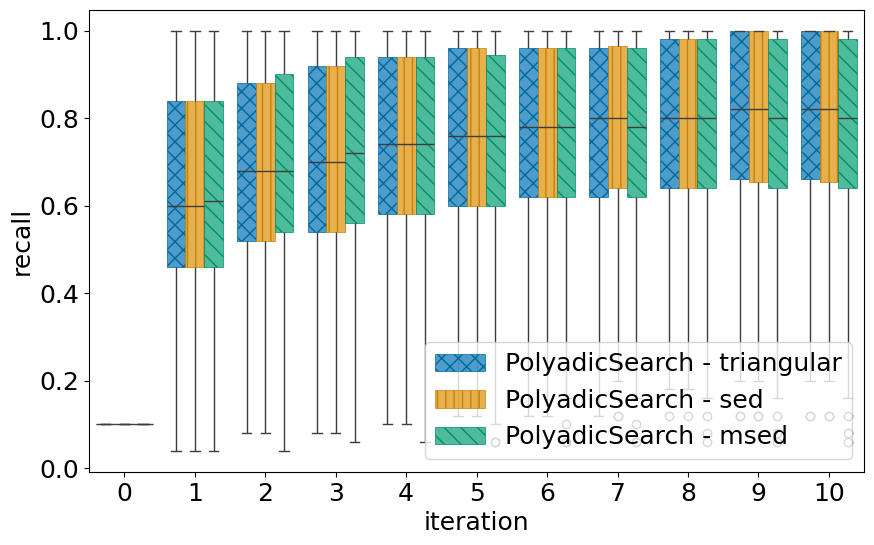

*****
**** Performing statistical tests for k_pos=5, k_neg=5, use_batch=False ***
 	 k_pos=5, k_neg=5,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=3.0818931050269725e-06, p=0.9999969181117441)
 	 k_pos=5, k_neg=5,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.2945579609713246, p=0.7448877300899682)
 	 k_pos=5, k_neg=5,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.4108713419548059, p=0.6631189253343435)
 	 k_pos=5, k_neg=5,it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0010906084701753443, p=0.9989099865228083)
 	 k_pos=5, k_neg=5,it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.05901687997153881, p=0.942692226173269)
 	 k_pos=5, k_neg=5,it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.182008861

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


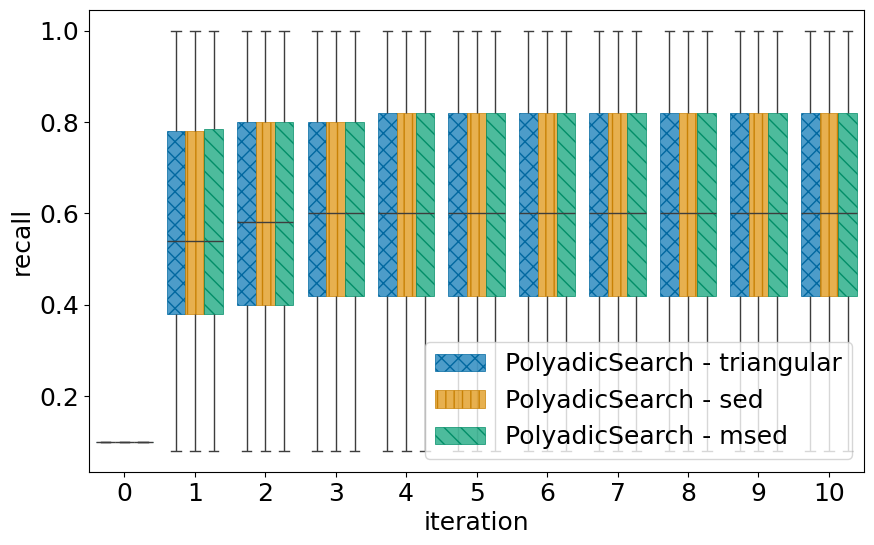

*****
**** Performing statistical tests for k_pos=-1, k_neg=0, use_batch=True ***
 	 k_pos=-1, k_neg=0,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00019743465272477822, p=0.9998025848523682)
 	 k_pos=-1, k_neg=0,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0008786086412836044, p=0.9991217775440904)
 	 k_pos=-1, k_neg=0,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00010541730572588761, p=0.9998945882550266)
 	 k_pos=-1, k_neg=0,it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.000583275698092864, p=0.9994168945160079)
 	 k_pos=-1, k_neg=0,it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0007496857997572375, p=0.9992505953787192)
 	 k_pos=-1, k_neg=0,it=6, There are NO statistically significant differences between the methods. (ANOVA result

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


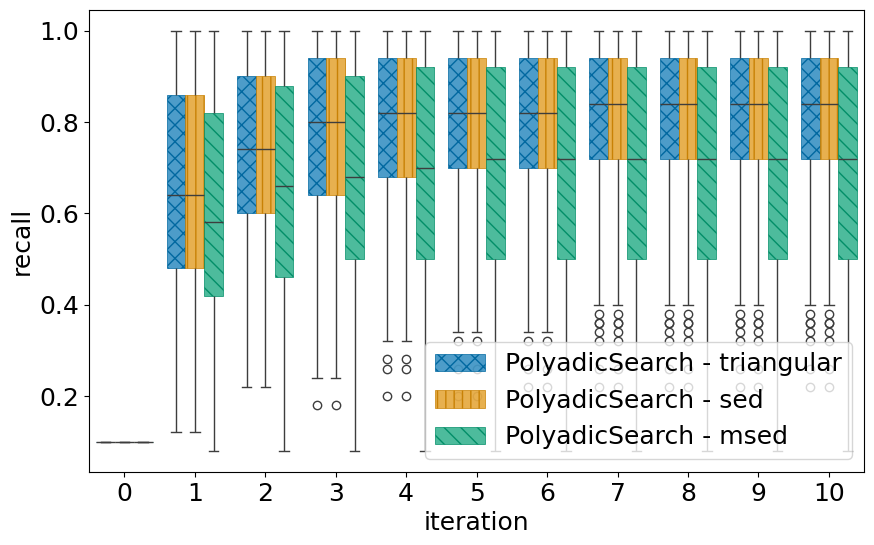

*****
**** Performing statistical tests for k_pos=-1, k_neg=-1, use_batch=True ***
	 k_pos=-1, k_neg=-1, it=1 There are statistically significant differences between the methods (ANOVA result: F=14.14382897842587, p=7.823041663767825e-07).
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
        group1                   group2           meandiff p-adj  lower  upper  reject
--------------------------------------------------------------------------------------
PolyadicSearch - msed        PolyadicSearch - sed   0.0523   0.0  0.0257 0.0789   True
PolyadicSearch - msed PolyadicSearch - triangular   0.0523   0.0  0.0257 0.0789   True
 PolyadicSearch - sed PolyadicSearch - triangular      0.0   1.0 -0.0266 0.0266  False
--------------------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=2 There are statistically significant differences between the methods (ANOVA result: F=34.409866332411184, p=1.847108240098107

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
        group1                   group2           meandiff p-adj  lower  upper  reject
--------------------------------------------------------------------------------------
PolyadicSearch - msed        PolyadicSearch - sed   0.0747   0.0  0.0503  0.099   True
PolyadicSearch - msed PolyadicSearch - triangular   0.0746   0.0  0.0502 0.0989   True
 PolyadicSearch - sed PolyadicSearch - triangular  -0.0001   1.0 -0.0244 0.0243  False
--------------------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=3 There are statistically significant differences between the methods (ANOVA result: F=56.93535957003841, p=6.96069740803207e-25).
                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
        group1                   group2           meandiff p-adj   lower  upper  reject
-----------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


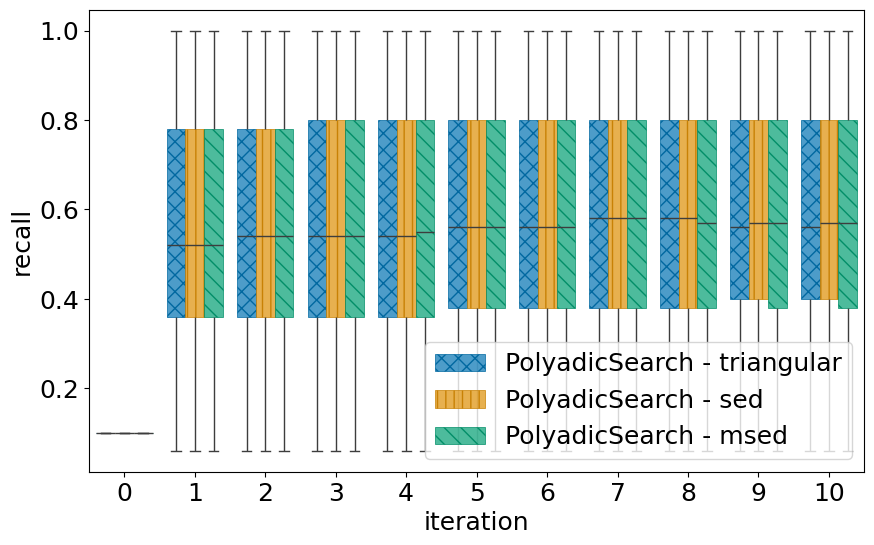

*****
**** Performing statistical tests for k_pos=3, k_neg=0, use_batch=True ***
 	 k_pos=3, k_neg=0,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00022945359055690515, p=0.9997705727539493)
 	 k_pos=3, k_neg=0,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0038238012835293263, p=0.9961835062118674)
 	 k_pos=3, k_neg=0,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0014392927887613377, p=0.9985617433593815)
 	 k_pos=3, k_neg=0,it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0011605465026553572, p=0.9988401272322612)
 	 k_pos=3, k_neg=0,it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0008008892769342098, p=0.9991994316167723)
 	 k_pos=3, k_neg=0,it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


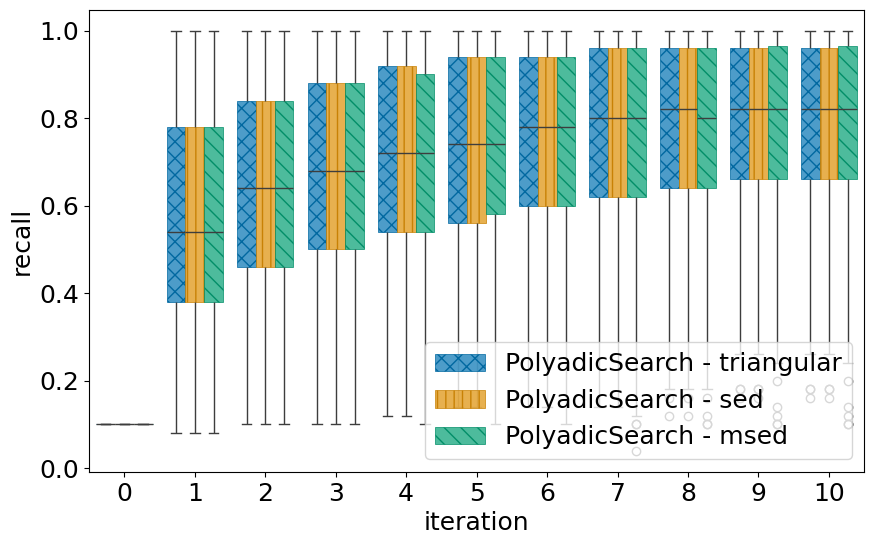

*****
**** Performing statistical tests for k_pos=3, k_neg=3, use_batch=True ***
 	 k_pos=3, k_neg=3,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00018956327840763748, p=0.9998104547025619)
 	 k_pos=3, k_neg=3,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00246246986451237, p=0.9975405620509195)
 	 k_pos=3, k_neg=3,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0057300726836533745, p=0.9942863264904954)
 	 k_pos=3, k_neg=3,it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00854850684994777, p=0.9914879579674298)
 	 k_pos=3, k_neg=3,it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.001651764210784634, p=0.9983496003373763)
 	 k_pos=3, k_neg=3,it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.000660

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


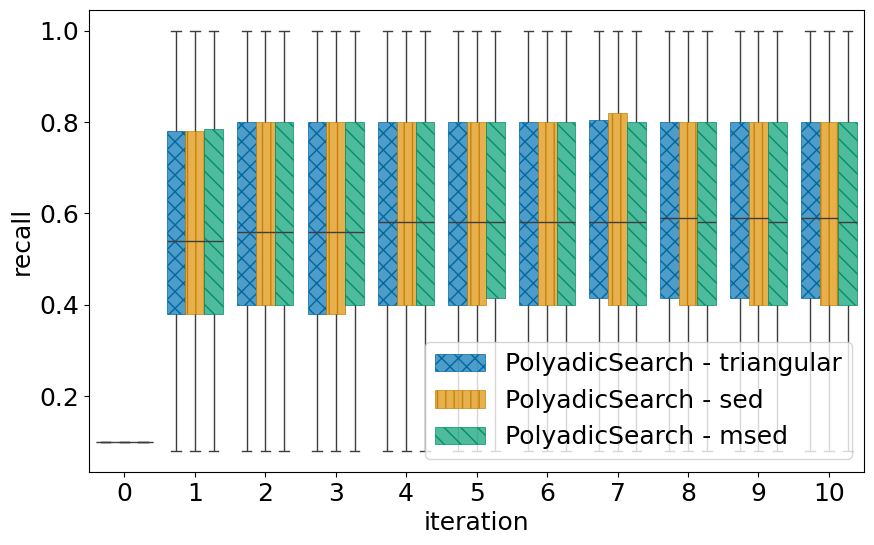

*****
**** Performing statistical tests for k_pos=5, k_neg=0, use_batch=True ***
 	 k_pos=5, k_neg=0,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00019743465272477822, p=0.9998025848523682)
 	 k_pos=5, k_neg=0,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.003208709370396808, p=0.9967964373173278)
 	 k_pos=5, k_neg=0,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.002300506476105445, p=0.9977021398637552)
 	 k_pos=5, k_neg=0,it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0010019824342840356, p=0.9989985198009753)
 	 k_pos=5, k_neg=0,it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0010377201663850466, p=0.9989628185277988)
 	 k_pos=5, k_neg=0,it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=2.398

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


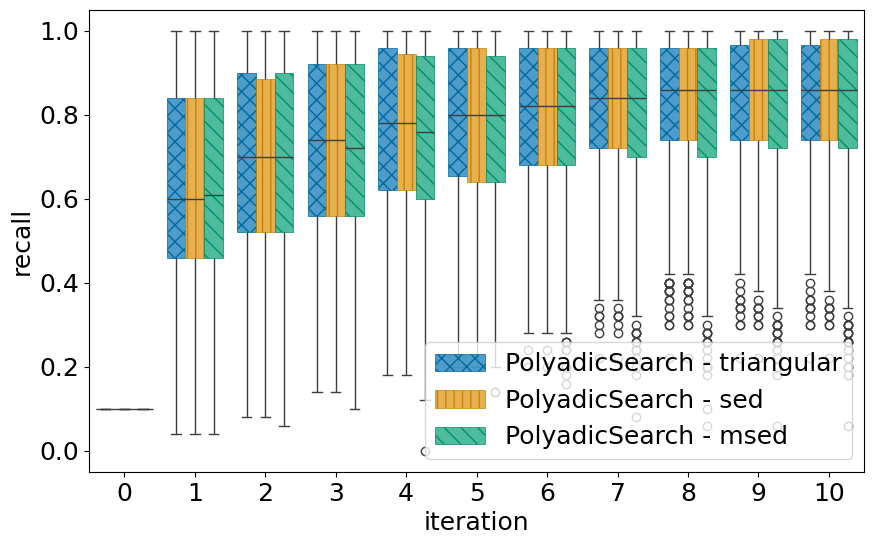

*****
**** Performing statistical tests for k_pos=5, k_neg=5, use_batch=True ***
 	 k_pos=5, k_neg=5,it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=3.0818931050269725e-06, p=0.9999969181117441)
 	 k_pos=5, k_neg=5,it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.011355642448845729, p=0.9887086426862616)
 	 k_pos=5, k_neg=5,it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.02827018727632408, p=0.9721259994458353)
 	 k_pos=5, k_neg=5,it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.8143047321862759, p=0.4430696830537092)
 	 k_pos=5, k_neg=5,it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.4975667914138043, p=0.6080710558994431)
 	 k_pos=5, k_neg=5,it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.6682177150

/tmp/ipykernel_776128/3096688082.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


In [13]:
use_batch = False
print("^^^^^^^^^^^^^^^^^")
print ("USE BATCH------>", use_batch)  
print("^^^^^^^^^^^^^^^^^")

method='PolyadicSearch'

##testing fun_name

data_preprocessing='softmax'
df_temp=df_method[(df_method['method']==method) & (df_method['data_preprocessing']==data_preprocessing)]
print(df_temp.shape)
plot_and_statistical_test_varying_fun(df_temp, method+'_'+data_preprocessing,use_batch,print_fun_name=True,print_temperature=False,print_data_preprocessing=False,print_k_pos_k_neg=False)

use_batch = True
print("^^^^^^^^^^^^^^^^^")
print ("USE BATCH------>", use_batch)  
print("^^^^^^^^^^^^^^^^^")

method='PolyadicSearch'

##testing fun_name

data_preprocessing='softmax'
df_temp=df_method[(df_method['method']==method) & (df_method['data_preprocessing']==data_preprocessing)]
print(df_temp.shape)
plot_and_statistical_test_varying_fun(df_temp, method+'_'+data_preprocessing,use_batch,print_fun_name=True,print_temperature=False,print_data_preprocessing=False,print_k_pos_k_neg=False)


^^^^^^^^^^^^^^^^^
USE BATCH------> False
^^^^^^^^^^^^^^^^^
(211200, 18)
^^^^  k_pos=3, use_batch=False ^^^
                                           Method  Count
0   PolyadicSearch - sed with $k^+$=3 and $k^-$=0   8800
1   PolyadicSearch - sed with $k^+$=3 and $k^-$=3   8800
2  PolyadicSearch - msed with $k^+$=3 and $k^-$=0   8800
3  PolyadicSearch - msed with $k^+$=3 and $k^-$=3   8800


/tmp/ipykernel_776128/3096688082.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=3,, use_batch=False ***
 	 k_pos=3, it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=1.3729825639161042, p=0.2491104923687257)
	 k_pos=3, it=2 There are statistically significant differences between the methods (ANOVA result: F=15.327126848279962, p=6.695680061907082e-10).


/tmp/ipykernel_776128/3096688082.py:260: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                                         
                    group1                                         group2                     meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------------------------
PolyadicSearch - msed with $k^+$=3 and $k^-$=0 PolyadicSearch - msed with $k^+$=3 and $k^-$=3   0.0582    0.0  0.0258  0.0905   True
PolyadicSearch - msed with $k^+$=3 and $k^-$=0  PolyadicSearch - sed with $k^+$=3 and $k^-$=0  -0.0044 0.9853 -0.0367  0.0279  False
PolyadicSearch - msed with $k^+$=3 and $k^-$=0  PolyadicSearch - sed with $k^+$=3 and $k^-$=3   0.0579    0.0  0.0256  0.0902   True
PolyadicSearch - msed with $k^+$=3 and $k^-$=3  PolyadicSearch - sed with $k^+$=3 and $k^-$=0  -0.0626    0.0 -0.0949 -0.0302   True
PolyadicSearch - msed with $k^+$=3 and $k^-$=3  PolyadicSearch - sed 

/tmp/ipykernel_776128/3096688082.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


                                           Method  Count
0   PolyadicSearch - sed with $k^+$=5 and $k^-$=0   8800
1   PolyadicSearch - sed with $k^+$=5 and $k^-$=5   8800
2  PolyadicSearch - msed with $k^+$=5 and $k^-$=0   8800
3  PolyadicSearch - msed with $k^+$=5 and $k^-$=5   8800


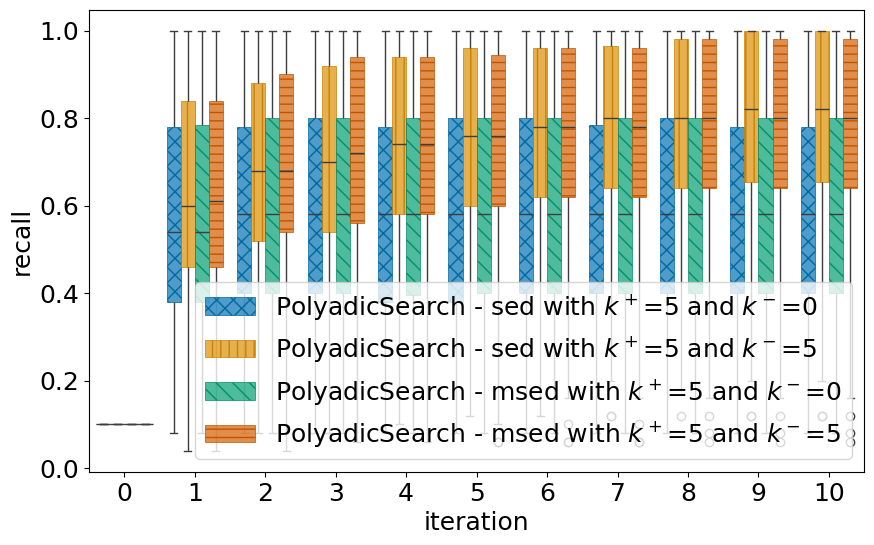

*****
**** Performing statistical tests for k_pos=5,, use_batch=False ***
	 k_pos=5, it=1 There are statistically significant differences between the methods (ANOVA result: F=14.658339278713994, p=1.7630935878870437e-09).
                                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                                        
                    group1                                         group2                     meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------------------------------------------------------------------
PolyadicSearch - msed with $k^+$=5 and $k^-$=0 PolyadicSearch - msed with $k^+$=5 and $k^-$=5   0.0563   0.0  0.0254  0.0872   True
PolyadicSearch - msed with $k^+$=5 and $k^-$=0  PolyadicSearch - sed with $k^+$=5 and $k^-$=0  -0.0002   1.0 -0.0311  0.0307  False
PolyadicSearch - msed with $k^+$=5 and $k^-$=0  PolyadicSearch - sed with $k^+$=5 and $k^-$=5   0.0563   0.0  0.0254  

/tmp/ipykernel_776128/3096688082.py:260: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


	 k_pos=5, it=2 There are statistically significant differences between the methods (ANOVA result: F=45.34400360883051, p=1.084778998736599e-28).
                                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                                         
                    group1                                         group2                     meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------------------------
PolyadicSearch - msed with $k^+$=5 and $k^-$=0 PolyadicSearch - msed with $k^+$=5 and $k^-$=5   0.0995    0.0  0.0692  0.1298   True
PolyadicSearch - msed with $k^+$=5 and $k^-$=0  PolyadicSearch - sed with $k^+$=5 and $k^-$=0  -0.0024 0.9971 -0.0327  0.0279  False
PolyadicSearch - msed with $k^+$=5 and $k^-$=0  PolyadicSearch - sed with $k^+$=5 and $k^-$=5   0.0925    0.0  0.0621  0.1228   True
PolyadicSearch - msed with $k^+$=5 and $k^-$=5  Polyadic

/tmp/ipykernel_776128/3096688082.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


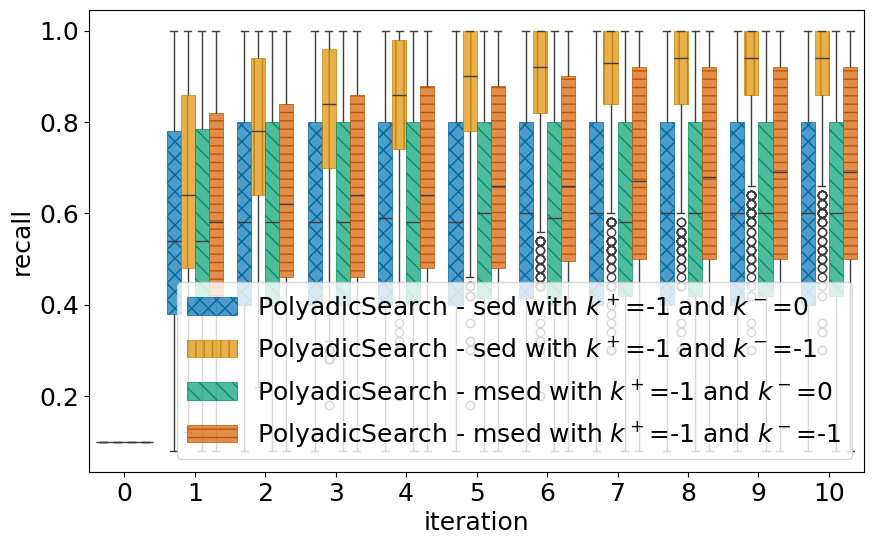

*****
**** Performing statistical tests for k_pos=-1,, use_batch=False ***
	 k_pos=-1, it=1 There are statistically significant differences between the methods (ANOVA result: F=20.031629041058753, p=7.348448816061172e-13).


/tmp/ipykernel_776128/3096688082.py:260: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                     group1                                           group2                     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------------------------------------------------
PolyadicSearch - msed with $k^+$=-1 and $k^-$=-1 PolyadicSearch - msed with $k^+$=-1 and $k^-$=0   -0.028 0.0901 -0.0588  0.0028  False
PolyadicSearch - msed with $k^+$=-1 and $k^-$=-1 PolyadicSearch - sed with $k^+$=-1 and $k^-$=-1   0.0523 0.0001  0.0215  0.0831   True
PolyadicSearch - msed with $k^+$=-1 and $k^-$=-1  PolyadicSearch - sed with $k^+$=-1 and $k^-$=0  -0.0282 0.0866  -0.059  0.0026  False
 PolyadicSearch - msed with $k^+$=-1 and $k^-$=0 PolyadicSearch - sed with $k^+$=-1 and $k^-$=-1   0.0803    0.0  0.0495  0.1111   True
 PolyadicSearch - msed with $k^+$=-1 and $k^-$=0

/tmp/ipykernel_776128/3096688082.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


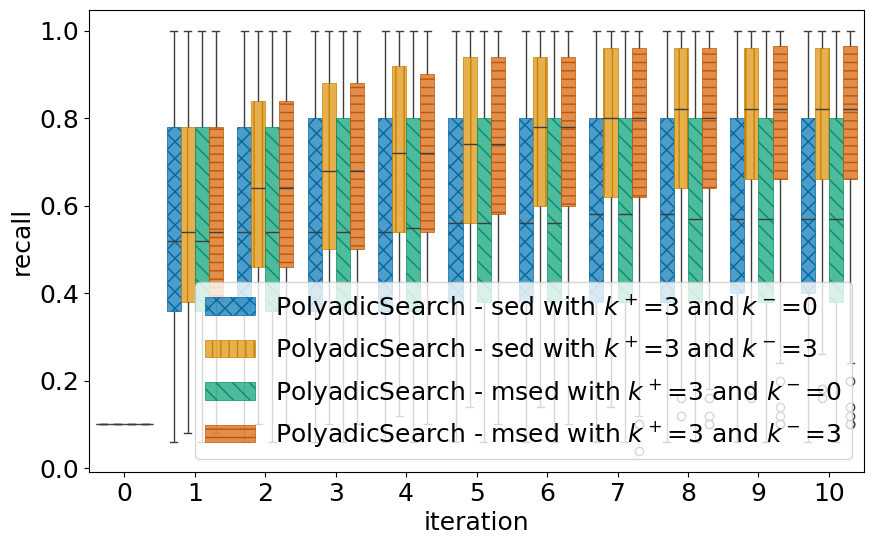

*****
**** Performing statistical tests for k_pos=3,, use_batch=True ***
 	 k_pos=3, it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=1.3729825639161042, p=0.2491104923687257)
	 k_pos=3, it=2 There are statistically significant differences between the methods (ANOVA result: F=23.53640138669812, p=4.592745523988424e-15).


/tmp/ipykernel_776128/3096688082.py:260: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                                         
                    group1                                         group2                     meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------------------------
PolyadicSearch - msed with $k^+$=3 and $k^-$=0 PolyadicSearch - msed with $k^+$=3 and $k^-$=3   0.0732    0.0  0.0415  0.1048   True
PolyadicSearch - msed with $k^+$=3 and $k^-$=0  PolyadicSearch - sed with $k^+$=3 and $k^-$=0   -0.001 0.9998 -0.0327  0.0307  False
PolyadicSearch - msed with $k^+$=3 and $k^-$=0  PolyadicSearch - sed with $k^+$=3 and $k^-$=3   0.0723    0.0  0.0406   0.104   True
PolyadicSearch - msed with $k^+$=3 and $k^-$=3  PolyadicSearch - sed with $k^+$=3 and $k^-$=0  -0.0742    0.0 -0.1059 -0.0425   True
PolyadicSearch - msed with $k^+$=3 and $k^-$=3  PolyadicSearch - sed 

/tmp/ipykernel_776128/3096688082.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


                                           Method  Count
0   PolyadicSearch - sed with $k^+$=5 and $k^-$=0   8800
1   PolyadicSearch - sed with $k^+$=5 and $k^-$=5   8800
2  PolyadicSearch - msed with $k^+$=5 and $k^-$=0   8800
3  PolyadicSearch - msed with $k^+$=5 and $k^-$=5   8800


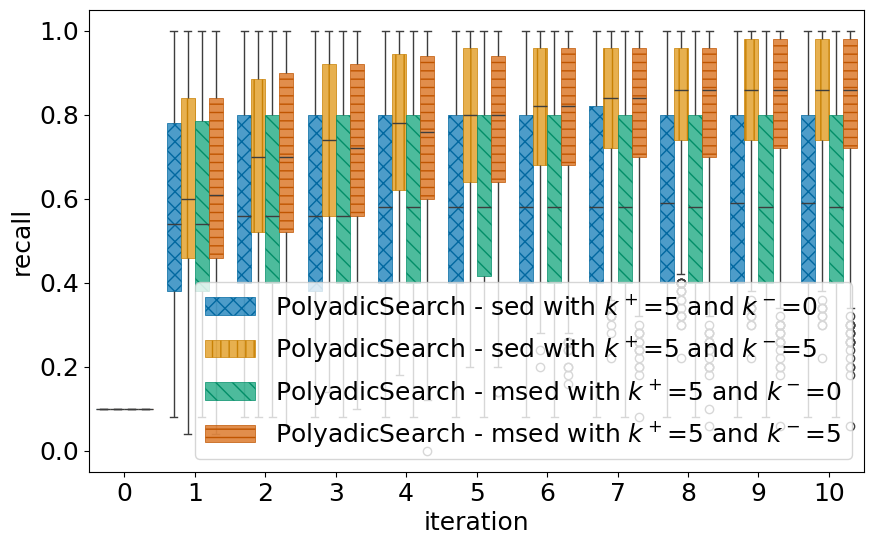

*****
**** Performing statistical tests for k_pos=5,, use_batch=True ***
	 k_pos=5, it=1 There are statistically significant differences between the methods (ANOVA result: F=14.658339278713994, p=1.7630935878870437e-09).
                                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                                        
                    group1                                         group2                     meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------------------------------------------------------------------
PolyadicSearch - msed with $k^+$=5 and $k^-$=0 PolyadicSearch - msed with $k^+$=5 and $k^-$=5   0.0563   0.0  0.0254  0.0872   True
PolyadicSearch - msed with $k^+$=5 and $k^-$=0  PolyadicSearch - sed with $k^+$=5 and $k^-$=0  -0.0002   1.0 -0.0311  0.0307  False
PolyadicSearch - msed with $k^+$=5 and $k^-$=0  PolyadicSearch - sed with $k^+$=5 and $k^-$=5   0.0563   0.0  0.0254  0

/tmp/ipykernel_776128/3096688082.py:260: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


	 k_pos=5, it=2 There are statistically significant differences between the methods (ANOVA result: F=51.745493285021176, p=1.1855473209184721e-32).
                                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                                         
                    group1                                         group2                     meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------------------------
PolyadicSearch - msed with $k^+$=5 and $k^-$=0 PolyadicSearch - msed with $k^+$=5 and $k^-$=5    0.103    0.0  0.0726  0.1334   True
PolyadicSearch - msed with $k^+$=5 and $k^-$=0  PolyadicSearch - sed with $k^+$=5 and $k^-$=0  -0.0009 0.9999 -0.0313  0.0295  False
PolyadicSearch - msed with $k^+$=5 and $k^-$=0  PolyadicSearch - sed with $k^+$=5 and $k^-$=5   0.1045    0.0  0.0741  0.1349   True
PolyadicSearch - msed with $k^+$=5 and $k^-$=5  Polyad

/tmp/ipykernel_776128/3096688082.py:200: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


                                             Method  Count
0    PolyadicSearch - sed with $k^+$=-1 and $k^-$=0   8800
1   PolyadicSearch - sed with $k^+$=-1 and $k^-$=-1   8800
2   PolyadicSearch - msed with $k^+$=-1 and $k^-$=0   8800
3  PolyadicSearch - msed with $k^+$=-1 and $k^-$=-1   8800


*****
**** Performing statistical tests for k_pos=-1,, use_batch=True ***
	 k_pos=-1, it=1 There are statistically significant differences between the methods (ANOVA result: F=20.031629041058753, p=7.348448816061172e-13).


/tmp/ipykernel_776128/3096688082.py:260: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                     group1                                           group2                     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------------------------------------------------
PolyadicSearch - msed with $k^+$=-1 and $k^-$=-1 PolyadicSearch - msed with $k^+$=-1 and $k^-$=0   -0.028 0.0901 -0.0588  0.0028  False
PolyadicSearch - msed with $k^+$=-1 and $k^-$=-1 PolyadicSearch - sed with $k^+$=-1 and $k^-$=-1   0.0523 0.0001  0.0215  0.0831   True
PolyadicSearch - msed with $k^+$=-1 and $k^-$=-1  PolyadicSearch - sed with $k^+$=-1 and $k^-$=0  -0.0282 0.0866  -0.059  0.0026  False
 PolyadicSearch - msed with $k^+$=-1 and $k^-$=0 PolyadicSearch - sed with $k^+$=-1 and $k^-$=-1   0.0803    0.0  0.0495  0.1111   True
 PolyadicSearch - msed with $k^+$=-1 and $k^-$=0

In [14]:
use_batch = False
print("^^^^^^^^^^^^^^^^^")
print ("USE BATCH------>", use_batch)  
print("^^^^^^^^^^^^^^^^^")

method='PolyadicSearch'



data_preprocessing='softmax'
df_Poly=df_method.copy()
df_Poly=df_Poly[(df_Poly['method']==method) & (df_Poly['data_preprocessing']==data_preprocessing) &((df_Poly['fun_name']=='msed')|(df_Poly['fun_name']=='sed'))]
print(df_Poly.shape)
# plot_and_statistical_test_varying_fun(df_Poly, method+'_'+data_preprocessing+'jsdVSmsed',use_batch,print_fun_name=True,print_temperature=False,print_data_preprocessing=False,print_k_pos_k_neg=False)

plot_and_statistical_test_varying_k(df_Poly,  method+'_'+data_preprocessing+'sedVSmsed',use_batch,print_fun_name=True,print_temperature=False,print_data_preprocessing=False,
                                           print_k_pos_k_neg=True)

use_batch = True
print("^^^^^^^^^^^^^^^^^")
print ("USE BATCH------>", use_batch)  
print("^^^^^^^^^^^^^^^^^")

method='PolyadicSearch'



data_preprocessing='softmax'
df_Poly=df_method.copy()
df_Poly=df_Poly[(df_Poly['method']==method) & (df_Poly['data_preprocessing']==data_preprocessing) &((df_Poly['fun_name']=='msed')|(df_Poly['fun_name']=='sed'))]
print(df_Poly.shape)
# plot_and_statistical_test_varying_fun(df_Poly, method+'_'+data_preprocessing+'jsdVSmsed',use_batch,print_fun_name=True,print_temperature=False,print_data_preprocessing=False,print_k_pos_k_neg=False)

plot_and_statistical_test_varying_k(df_Poly,  method+'_'+data_preprocessing+'sedVSmsed',use_batch,print_fun_name=True,print_temperature=False,print_data_preprocessing=False,
                                           print_k_pos_k_neg=True)



^^^^  k_pos=-1, k_neg=0 ^^^
                                 Method  Count
0         PolyadicSearch -  Batch - sed   8800
1  PolyadicSearch -  Incremental  - sed   8800


/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


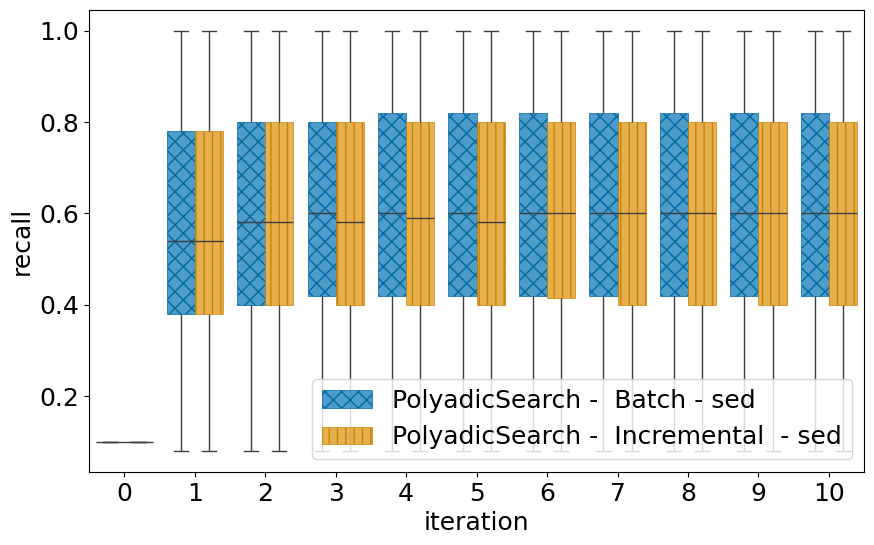

*****
**** Performing statistical tests for k_pos=-1,, k_neg=0 ***
 	 k_pos=-1, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=-1, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0032024840498487096, p=0.9548784814937157)
 	 k_pos=-1, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00826652337123539, p=0.9275672168740785)
 	 k_pos=-1, k_neg=0 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.06162643241676889, p=0.8039754188865873)
 	 k_pos=-1, k_neg=0 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.03922834629020678, p=0.8430221612266184)
 	 k_pos=-1, k_neg=0 it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.055728836325033476, p=0.8134089477365835)
 	 k_po

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


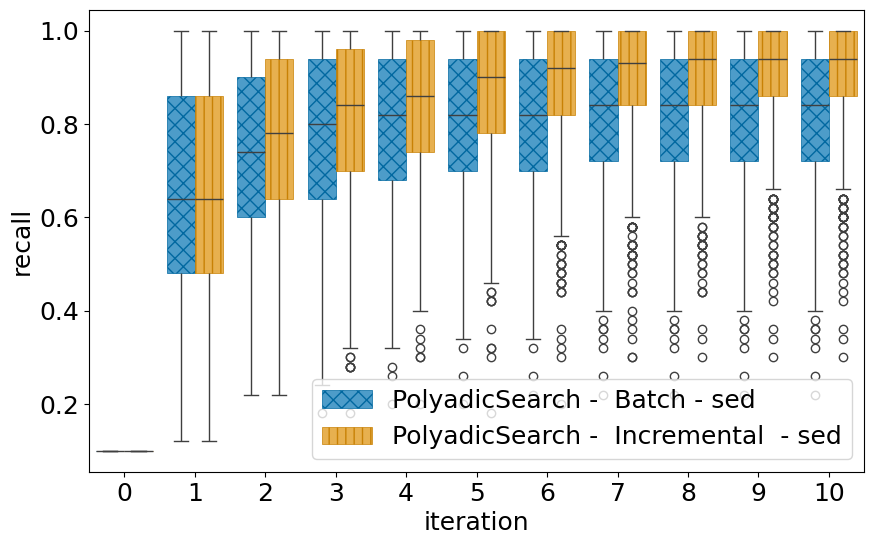

*****
**** Performing statistical tests for k_pos=-1,, k_neg=-1 ***
 	 k_pos=-1, k_neg=-1 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
	 k_pos=-1, k_neg=-1, it=2 There are statistically significant differences between the methods (ANOVA result: F=8.094351495204984, p=0.004496947081108114).
                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                          
            group1                           group2                meandiff p-adj  lower  upper  reject
-------------------------------------------------------------------------------------------------------
PolyadicSearch -  Batch - sed PolyadicSearch -  Incremental  - sed   0.0267 0.0045 0.0083 0.0451   True
-------------------------------------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=3 There are statistically significant differences between the methods (ANOVA result: F=20.760947354241

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
            group1                           group2                meandiff p-adj lower upper  reject
-----------------------------------------------------------------------------------------------------
PolyadicSearch -  Batch - sed PolyadicSearch -  Incremental  - sed   0.0386   0.0 0.022 0.0553   True
-----------------------------------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=4 There are statistically significant differences between the methods (ANOVA result: F=39.005416403564155, p=5.40581063239865e-10).
                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                          
            group1                           group2                meandiff p-adj lower  upper  reject
------------------------------------------------------------------------------------------------------
PolyadicSearch -  Batch 

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=3,, k_neg=0 ***
 	 k_pos=3, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=3, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.010997208344753555, p=0.916494048739503)
 	 k_pos=3, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.10906283876947537, p=0.7412569023469955)
 	 k_pos=3, k_neg=0 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.22770216918666453, p=0.6332981465322809)
 	 k_pos=3, k_neg=0 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.38751555379221303, p=0.533697047335363)
 	 k_pos=3, k_neg=0 it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.714845846738758, p=0.39796636181095646)
 	 k_pos=3, k_neg=0

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


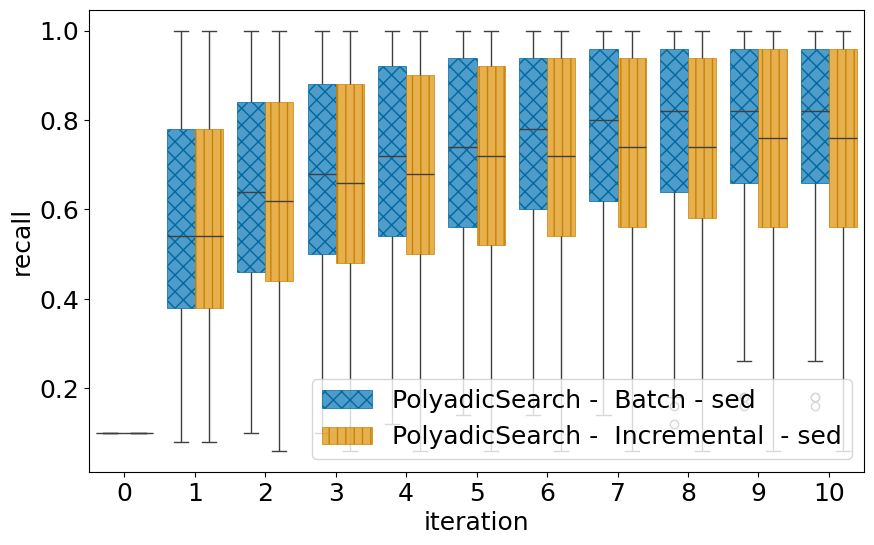

*****
**** Performing statistical tests for k_pos=3,, k_neg=3 ***
 	 k_pos=3, k_neg=3 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=3, k_neg=3 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=1.0565843531149033, p=0.30415106972440004)
 	 k_pos=3, k_neg=3 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=1.9041471628772837, p=0.16780788323789683)
	 k_pos=3, k_neg=3, it=4 There are statistically significant differences between the methods (ANOVA result: F=4.539610571968244, p=0.03327144461146372).
                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
            group1                           group2                meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------------------
PolyadicSearch -  Ba

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
            group1                           group2                meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------------------
PolyadicSearch -  Batch - sed PolyadicSearch -  Incremental  - sed  -0.0312 0.0048 -0.0529 -0.0095   True
---------------------------------------------------------------------------------------------------------
	 k_pos=3, k_neg=3, it=6 There are statistically significant differences between the methods (ANOVA result: F=12.110079634045402, p=0.0005149729108327542).
                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
            group1                           group2                meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


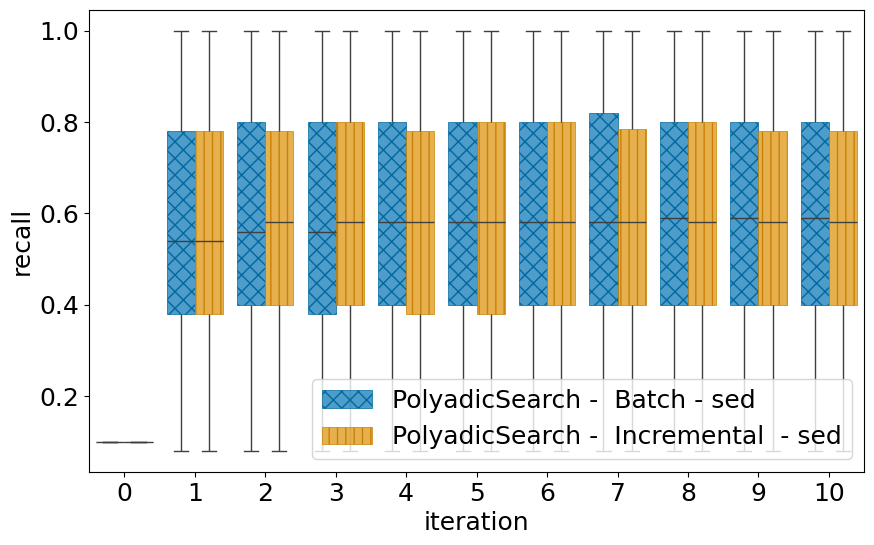

*****
**** Performing statistical tests for k_pos=5,, k_neg=0 ***
 	 k_pos=5, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=5, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.00483568777348262, p=0.9445692034514799)
 	 k_pos=5, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.1790549520530344, p=0.6722435997768506)
 	 k_pos=5, k_neg=0 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.47699232069798014, p=0.4898881413145876)
 	 k_pos=5, k_neg=0 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.6185583929174676, p=0.4317001142046736)
 	 k_pos=5, k_neg=0 it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.8603309085256914, p=0.353786175205292)
 	 k_pos=5, k_neg=0 i

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


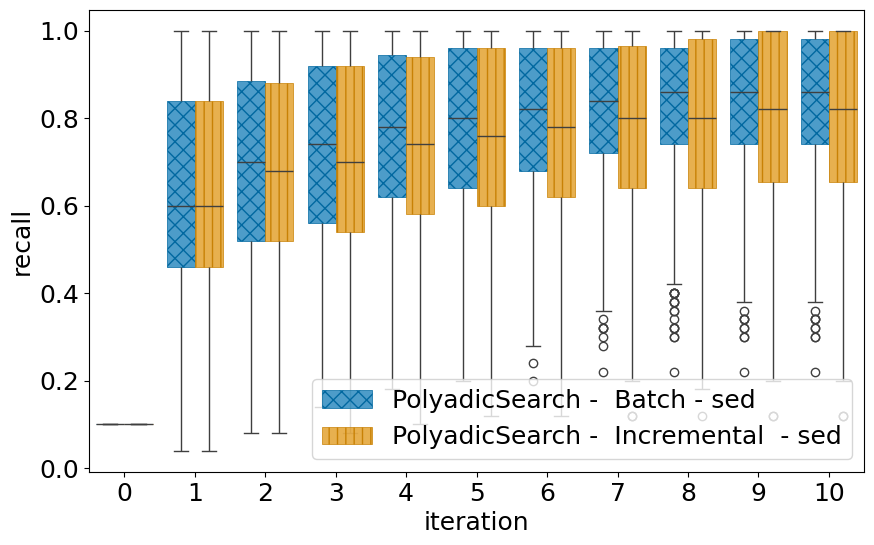

*****
**** Performing statistical tests for k_pos=5,, k_neg=5 ***
 	 k_pos=5, k_neg=5 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=5, k_neg=5 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=1.0746769424394864, p=0.30004826091878356)
 	 k_pos=5, k_neg=5 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=2.9241725278306654, p=0.08745607131850792)
	 k_pos=5, k_neg=5, it=4 There are statistically significant differences between the methods (ANOVA result: F=6.434994965655855, p=0.011283805238576762).
                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
            group1                           group2                meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------------------
PolyadicSearch -  B

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
            group1                           group2                meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------------------
PolyadicSearch -  Batch - sed PolyadicSearch -  Incremental  - sed   -0.029 0.0029 -0.0481 -0.0099   True
---------------------------------------------------------------------------------------------------------
	 k_pos=5, k_neg=5, it=6 There are statistically significant differences between the methods (ANOVA result: F=14.34885895436067, p=0.0001575000543005801).
                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
            group1                           group2                meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


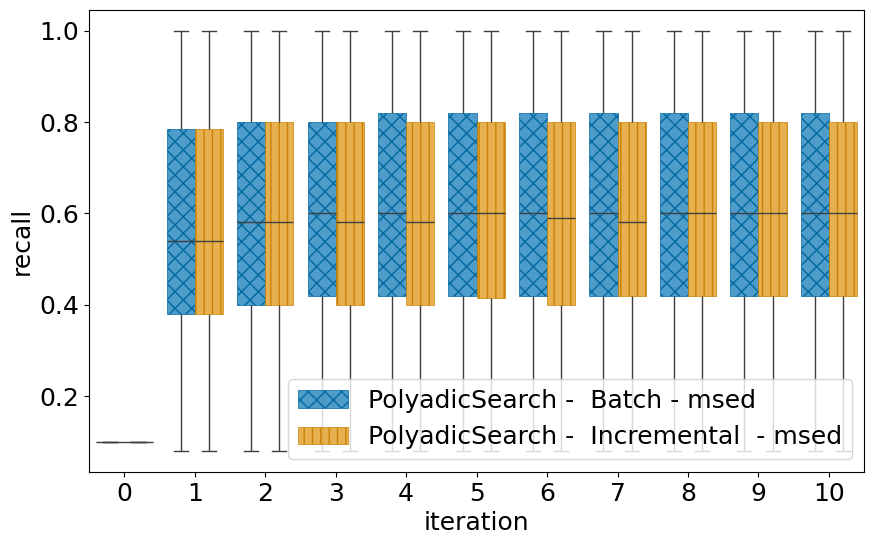

*****
**** Performing statistical tests for k_pos=-1,, k_neg=0 ***
 	 k_pos=-1, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=-1, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.008649090537502487, p=0.9259148323133136)
 	 k_pos=-1, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.04187063208064147, p=0.8378926279667042)
 	 k_pos=-1, k_neg=0 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.10048549811710247, p=0.7512892012514267)
 	 k_pos=-1, k_neg=0 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.12346311150148453, p=0.7253547222294986)
 	 k_pos=-1, k_neg=0 it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.14123938737568975, p=0.7071018719205677)
 	 k_pos=

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


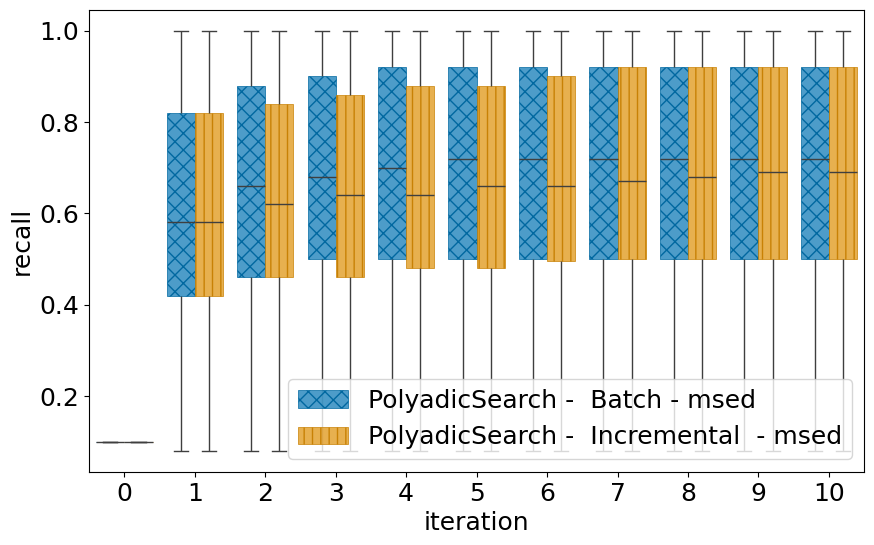

*****
**** Performing statistical tests for k_pos=-1,, k_neg=-1 ***
 	 k_pos=-1, k_neg=-1 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
	 k_pos=-1, k_neg=-1, it=2 There are statistically significant differences between the methods (ANOVA result: F=5.1234099625091645, p=0.023738814846994246).
                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                            
            group1                             group2                meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------------------------------------------
PolyadicSearch -  Batch - msed PolyadicSearch -  Incremental  - msed  -0.0269 0.0237 -0.0502 -0.0036   True
-----------------------------------------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=3 There are statistically significant differences between the methods (ANOVA resu

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                            
            group1                             group2                meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------------------------------------------
PolyadicSearch -  Batch - msed PolyadicSearch -  Incremental  - msed  -0.0325 0.0063 -0.0558 -0.0092   True
-----------------------------------------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=4 There are statistically significant differences between the methods (ANOVA result: F=7.855947250718418, p=0.0051265439694907836).
                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
            group1                             group2                meandiff p-adj   lower  upper reject
-------------------------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


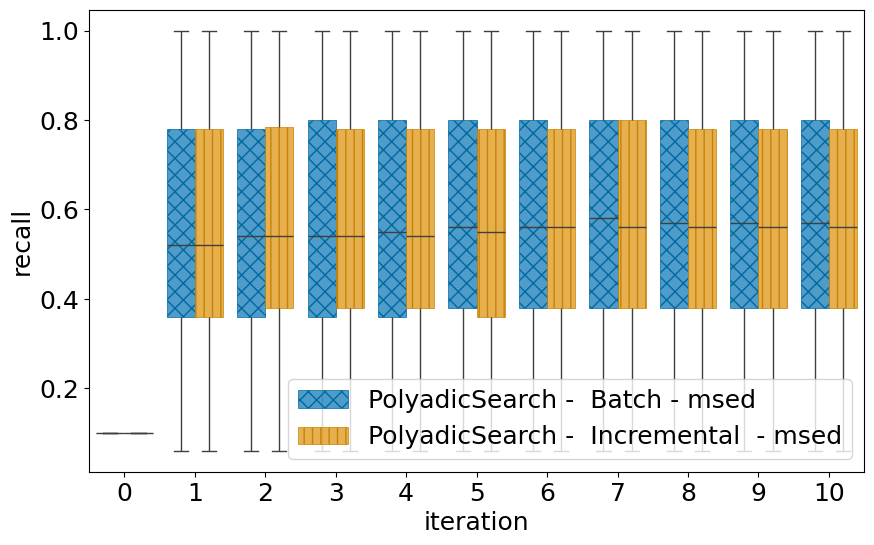

*****
**** Performing statistical tests for k_pos=3,, k_neg=0 ***
 	 k_pos=3, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=3, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.025016113350372154, p=0.8743469004686184)
 	 k_pos=3, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.007351563772795, p=0.9316828426230566)
 	 k_pos=3, k_neg=0 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.11201183374335993, p=0.7379091370592131)
 	 k_pos=3, k_neg=0 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.17022030006992694, p=0.6799714387529301)
 	 k_pos=3, k_neg=0 it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.22221780391087514, p=0.6374195838621388)
 	 k_pos=3, k_neg=

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


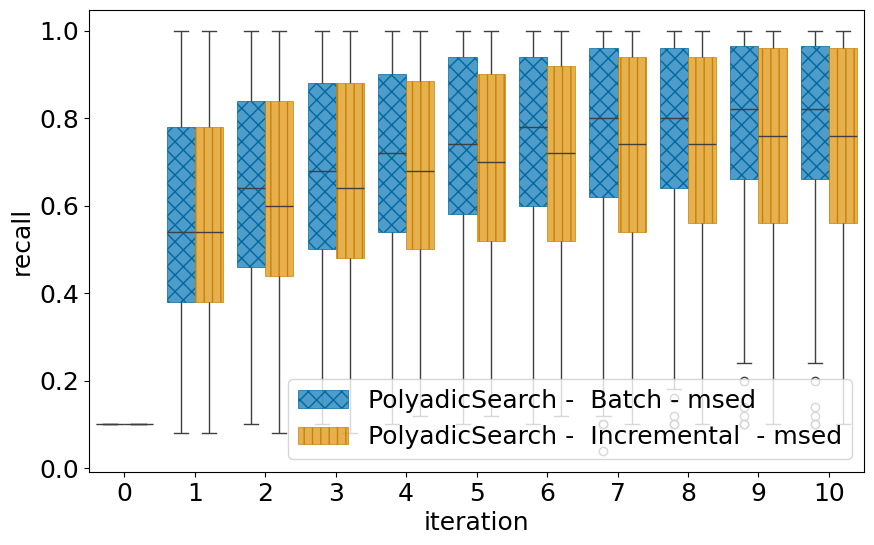

*****
**** Performing statistical tests for k_pos=3,, k_neg=3 ***
 	 k_pos=3, k_neg=3 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=3, k_neg=3 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=1.1593856827949678, p=0.28175550544483285)
	 k_pos=3, k_neg=3, it=3 There are statistically significant differences between the methods (ANOVA result: F=4.6175453808565035, p=0.031796328041497554).
                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                            
            group1                             group2                meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------------------------------------------
PolyadicSearch -  Batch - msed PolyadicSearch -  Incremental  - msed  -0.0252 0.0318 -0.0483 -0.0022   True
--------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                            
            group1                             group2                meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------------------------------------------
PolyadicSearch -  Batch - msed PolyadicSearch -  Incremental  - msed  -0.0335 0.0033 -0.0559 -0.0112   True
-----------------------------------------------------------------------------------------------------------
	 k_pos=3, k_neg=3, it=5 There are statistically significant differences between the methods (ANOVA result: F=11.820856276180729, p=0.0006007450338743928).
                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                            
            group1                             group2                meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


*****
**** Performing statistical tests for k_pos=5,, k_neg=0 ***
 	 k_pos=5, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=5, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0024985218382066175, p=0.9601404160807165)
 	 k_pos=5, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.01157935678589562, p=0.9143206192381175)
 	 k_pos=5, k_neg=0 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.21125617330692303, p=0.6458471264855044)
 	 k_pos=5, k_neg=0 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.29391099964164763, p=0.587800689097259)
 	 k_pos=5, k_neg=0 it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.30223481561707394, p=0.5825615953566887)
 	 k_pos=5, k_ne

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


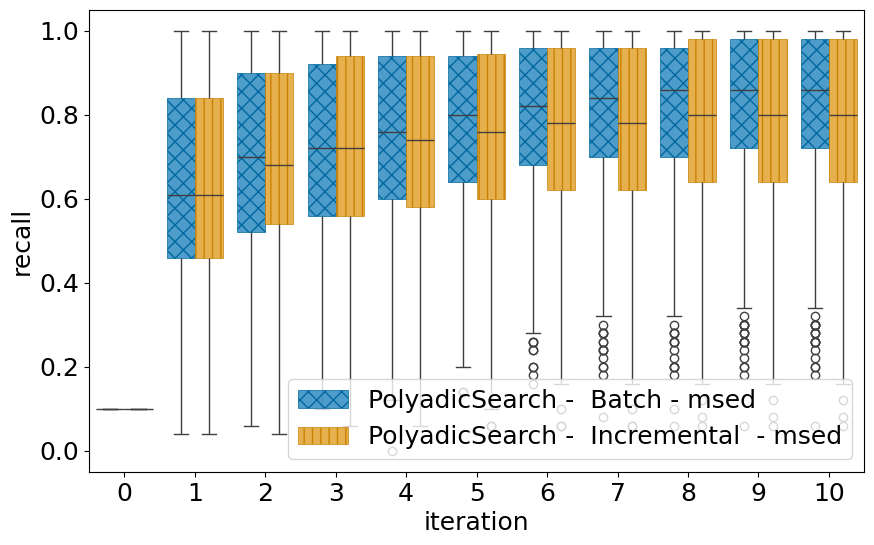

*****
**** Performing statistical tests for k_pos=5,, k_neg=5 ***
 	 k_pos=5, k_neg=5 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=5, k_neg=5 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.06922824483315675, p=0.7924977052439777)
 	 k_pos=5, k_neg=5 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.4615270219507809, p=0.49700956818281095)
 	 k_pos=5, k_neg=5 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=2.0484583092364024, p=0.15255593700415532)
	 k_pos=5, k_neg=5, it=5 There are statistically significant differences between the methods (ANOVA result: F=6.218493215147381, p=0.012742708175520626).
                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                            
            group1                             group2                me

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                            
            group1                             group2                meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------------------------------------------
PolyadicSearch -  Batch - msed PolyadicSearch -  Incremental  - msed  -0.0333 0.0007 -0.0524 -0.0141   True
-----------------------------------------------------------------------------------------------------------
	 k_pos=5, k_neg=5, it=7 There are statistically significant differences between the methods (ANOVA result: F=16.28749704503997, p=5.699451078228378e-05).
                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
            group1                             group2                meandiff p-adj   lower  upper reject
---------------------------------------------------------------------------------------------

In [15]:
plot_and_statistical_test_varying_update(df_Poly[df_Poly['fun_name']=='sed'], 'Poly',max_iter=10, print_fun_name=True)

plot_and_statistical_test_varying_update(df_Poly[df_Poly['fun_name']=='msed'], 'Poly',max_iter=10, print_fun_name=True)

# Rocchio

In [16]:
methods=['Rocchio']
method="Rocchio"
df_method=select_and_save_method_df(df.copy(), methods, data_preprocessing=['L2_normalized'])
print(df_method['method'].unique())
print(df_method['fun_name'].unique())
print(df_method['data_preprocessing'].unique())
df_method.loc[:,'method']=method
df_method.loc[:,'fun_name']=' '
print(" -->")
print(df_method['method'].unique())
print(df_method['fun_name'].unique())
print(df_method['data_preprocessing'].unique())
df_method.head()

(105600, 18)
['Rocchio']
['euclidean']
['L2_normalized']
 -->
['Rocchio']
[' ']
['L2_normalized']


iteration  recall      ndcg       map  max_iter  n_display  k_pos  \
105600          0     0.1  0.228603  0.321587        10         50     -1   
105601          1     1.0  1.000000  1.000000        10         50     -1   
105602          2     1.0  1.000000  1.000000        10         50     -1   
105603          3     1.0  1.000000  1.000000        10         50     -1   
105604          4     1.0  1.000000  1.000000        10         50     -1   

        k_neg   method fun_name data_preprocessing  use_batch  gamma  alpha  \
105600      0  Rocchio               L2_normalized       True    0.0   0.75   
105601      0  Rocchio               L2_normalized       True    0.0   0.75   
105602      0  Rocchio               L2_normalized       True    0.0   0.75   
105603      0  Rocchio               L2_normalized       True    0.0   0.75   
105604      0  Rocchio               L2_normalized       True    0.0   0.75   

        beta  temperature  norm_multiplier    to_sort  
105600  0.25          NaN              NaN  df_160800  
105601  0.25          NaN              NaN  df_160801  
105602  0.25          NaN              NaN  df_160802  
105603  0.25          NaN              NaN  df_160803  
105604  0.25          NaN              NaN  df_160804

In [17]:
df_Rocchio=df_method.copy()

use_batch = False
print("^^^^^^^^^^^^^^^^^")
print ("USE BATCH------>", use_batch)  
print("^^^^^^^^^^^^^^^^^")

#plot_and_statistical_test_varying_k(df_Rocchio,  method,use_batch,print_fun_name=False,print_temperature=False,print_data_preprocessing=False, print_k_pos_k_neg=True)


use_batch = True
print("^^^^^^^^^^^^^^^^^")
print ("USE BATCH------>", use_batch)  
print("^^^^^^^^^^^^^^^^^")

#plot_and_statistical_test_varying_k(df_Rocchio,  method,use_batch,print_fun_name=False,print_temperature=False,print_data_preprocessing=False, print_k_pos_k_neg=True)

^^^^^^^^^^^^^^^^^
USE BATCH------> False
^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^
USE BATCH------> True
^^^^^^^^^^^^^^^^^


^^^^  k_pos=-1, k_neg=0 ^^^
                     Method  Count
0         Rocchio -  Batch    8800
1  Rocchio -  Incremental     8800


/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


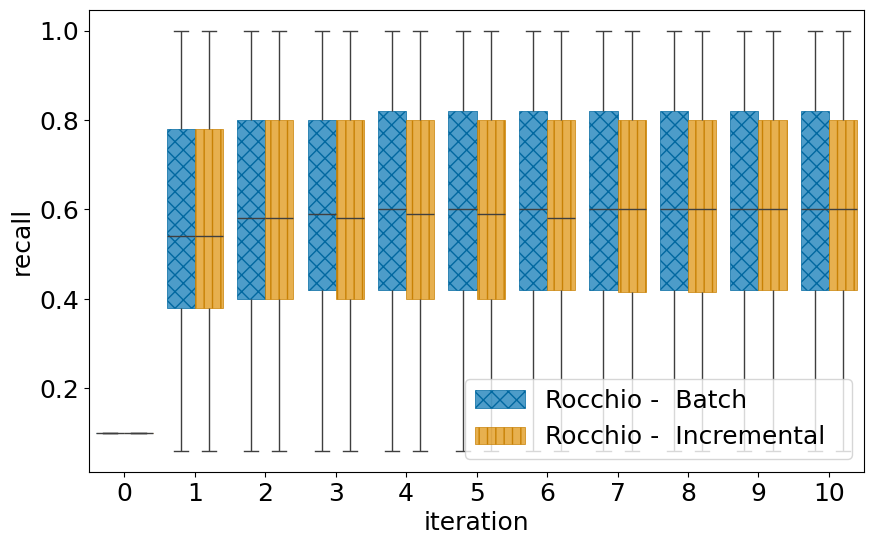

*****
**** Performing statistical tests for k_pos=-1,, k_neg=0 ***
 	 k_pos=-1, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=-1, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=4.054945084445149e-06, p=0.9983935607362029)
 	 k_pos=-1, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.03742029431026841, p=0.846636423594402)
 	 k_pos=-1, k_neg=0 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.08159158982652881, p=0.7751890329897632)
 	 k_pos=-1, k_neg=0 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.041282183257147775, p=0.8390200756572556)
 	 k_pos=-1, k_neg=0 it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.06010139662999228, p=0.8063672287071467)
 	 k_pos

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


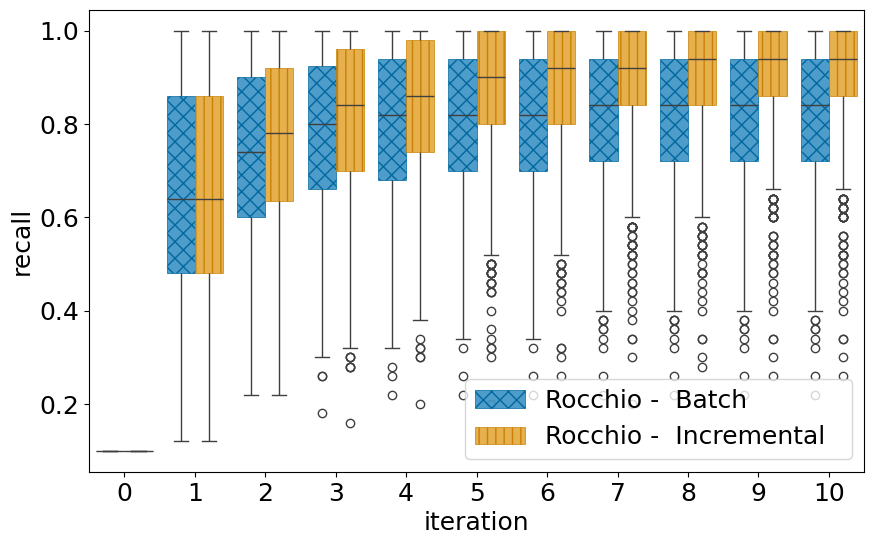

*****
**** Performing statistical tests for k_pos=-1,, k_neg=-1 ***
 	 k_pos=-1, k_neg=-1 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
	 k_pos=-1, k_neg=-1, it=2 There are statistically significant differences between the methods (ANOVA result: F=7.779583025824874, p=0.005346683547833727).
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1               group2          meandiff p-adj  lower  upper  reject
-------------------------------------------------------------------------------
Rocchio -  Batch  Rocchio -  Incremental     0.0261 0.0053 0.0078 0.0445   True
-------------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=3 There are statistically significant differences between the methods (ANOVA result: F=21.040514713913467, p=4.8473690980132034e-06).


/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1               group2          meandiff p-adj lower  upper  reject
------------------------------------------------------------------------------
Rocchio -  Batch  Rocchio -  Incremental     0.0389   0.0 0.0223 0.0556   True
------------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=4 There are statistically significant differences between the methods (ANOVA result: F=36.765100409436556, p=1.6596552194636667e-09).
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1               group2          meandiff p-adj lower  upper  reject
------------------------------------------------------------------------------
Rocchio -  Batch  Rocchio -  Incremental     0.0485   0.0 0.0328 0.0643   True
------------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=5 There are statistically 

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


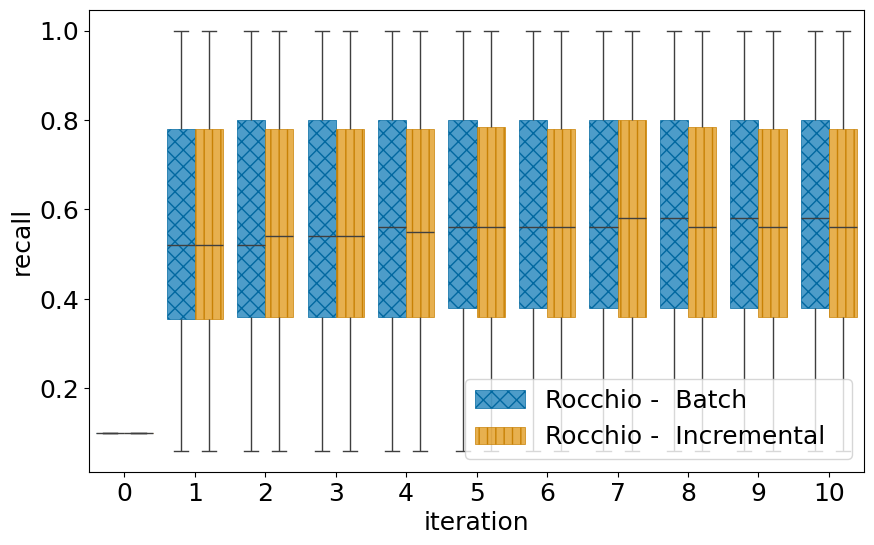

*****
**** Performing statistical tests for k_pos=3,, k_neg=0 ***
 	 k_pos=3, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=3, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0317017476159242, p=0.858706397090792)
 	 k_pos=3, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.039713384927430796, p=0.8420673753433261)
 	 k_pos=3, k_neg=0 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.24824284902217192, p=0.6183836315885908)
 	 k_pos=3, k_neg=0 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.2859393071704501, p=0.5929089387486564)
 	 k_pos=3, k_neg=0 it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.27164265028266904, p=0.6023042079656271)
 	 k_pos=3, k_neg=0

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


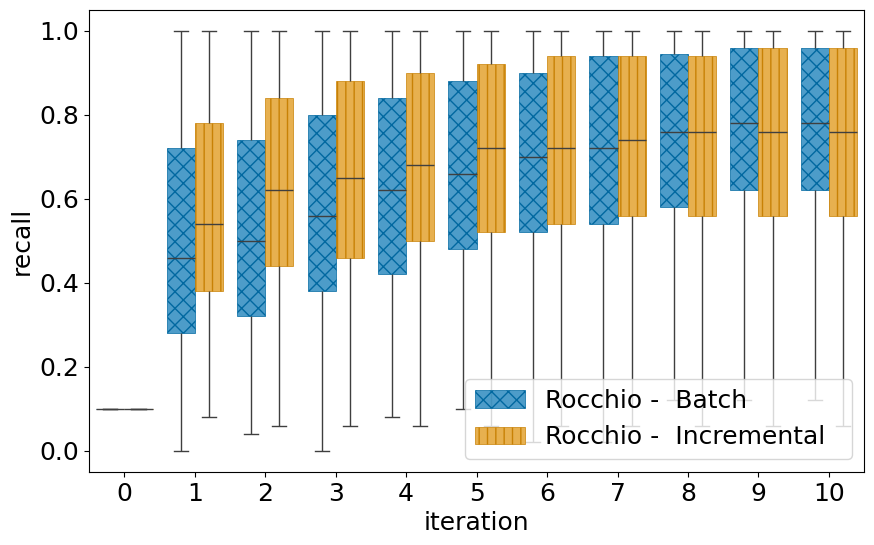

*****
**** Performing statistical tests for k_pos=3,, k_neg=3 ***
	 k_pos=3, k_neg=3, it=1 There are statistically significant differences between the methods (ANOVA result: F=31.425602882317623, p=2.4370236669914376e-08).
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1               group2          meandiff p-adj lower  upper  reject
------------------------------------------------------------------------------
Rocchio -  Batch  Rocchio -  Incremental     0.0743   0.0 0.0483 0.1003   True
------------------------------------------------------------------------------
	 k_pos=3, k_neg=3, it=2 There are statistically significant differences between the methods (ANOVA result: F=56.37573746585915, p=9.899884905707312e-14).


/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1               group2          meandiff p-adj lower upper  reject
-----------------------------------------------------------------------------
Rocchio -  Batch  Rocchio -  Incremental     0.0961   0.0 0.071 0.1212   True
-----------------------------------------------------------------------------
	 k_pos=3, k_neg=3, it=3 There are statistically significant differences between the methods (ANOVA result: F=35.51951442842476, p=3.1007322176746384e-09).
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1               group2          meandiff p-adj lower  upper reject
-----------------------------------------------------------------------------
Rocchio -  Batch  Rocchio -  Incremental     0.0753   0.0 0.0505   0.1   True
-----------------------------------------------------------------------------
	 k_pos=3, k_neg=3, it=4 There are statistically significant dif

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


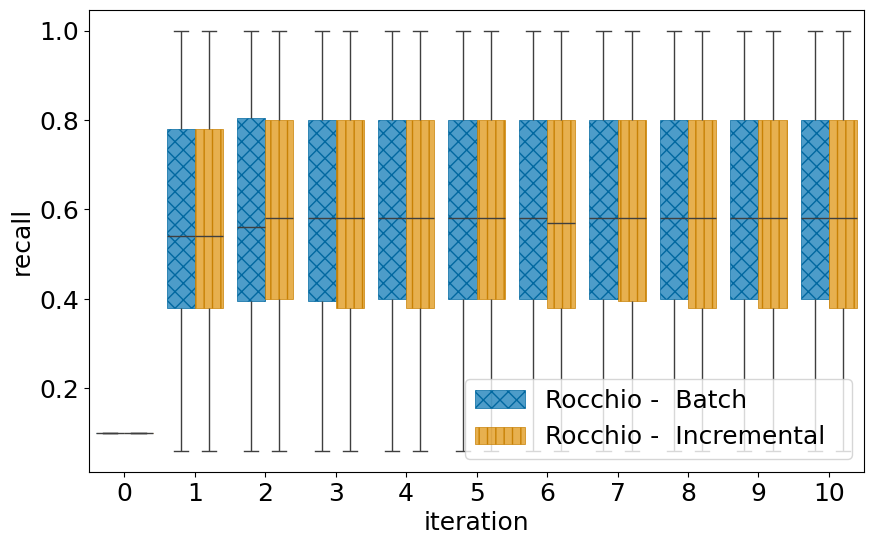

*****
**** Performing statistical tests for k_pos=5,, k_neg=0 ***
 	 k_pos=5, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=5, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.027061904359852583, p=0.8693543936207131)
 	 k_pos=5, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=0.035810187309434624, p=0.8499320428483378)
 	 k_pos=5, k_neg=0 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=0.07782747901370225, p=0.7802995192650264)
 	 k_pos=5, k_neg=0 it=5, There are NO statistically significant differences between the methods. (ANOVA result: F=0.3128250964348535, p=0.576030122148721)
 	 k_pos=5, k_neg=0 it=6, There are NO statistically significant differences between the methods. (ANOVA result: F=0.5067970107810861, p=0.47663261642640253)
 	 k_pos=5, k_neg

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


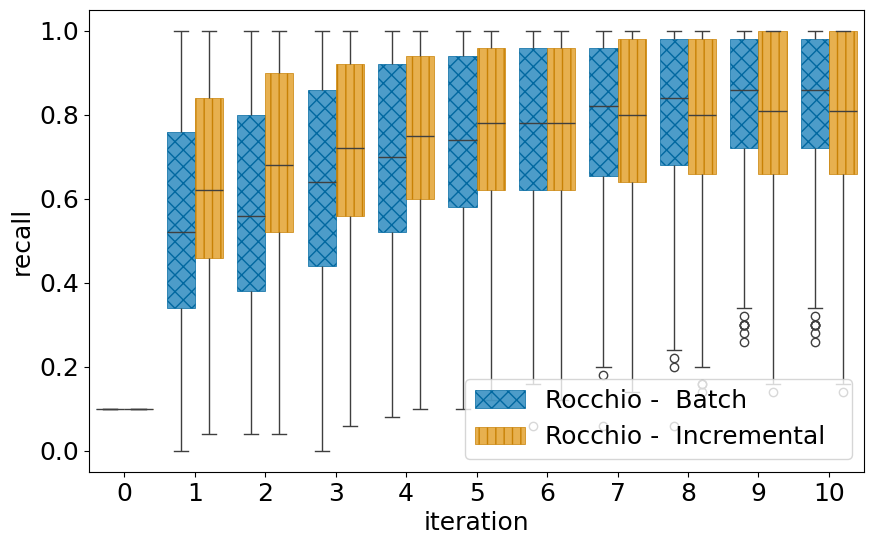

*****
**** Performing statistical tests for k_pos=5,, k_neg=5 ***
	 k_pos=5, k_neg=5, it=1 There are statistically significant differences between the methods (ANOVA result: F=49.765867390251685, p=2.5709011120497832e-12).
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1               group2          meandiff p-adj lower upper  reject
-----------------------------------------------------------------------------
Rocchio -  Batch  Rocchio -  Incremental     0.0873   0.0 0.063 0.1115   True
-----------------------------------------------------------------------------
	 k_pos=5, k_neg=5, it=2 There are statistically significant differences between the methods (ANOVA result: F=65.28707292560034, p=1.2641164570188666e-15).


/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1               group2          meandiff p-adj lower  upper  reject
------------------------------------------------------------------------------
Rocchio -  Batch  Rocchio -  Incremental     0.0969   0.0 0.0734 0.1204   True
------------------------------------------------------------------------------
	 k_pos=5, k_neg=5, it=3 There are statistically significant differences between the methods (ANOVA result: F=37.47294154849738, p=1.163997622504707e-09).
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1               group2          meandiff p-adj lower  upper  reject
------------------------------------------------------------------------------
Rocchio -  Batch  Rocchio -  Incremental     0.0707   0.0 0.0481 0.0934   True
------------------------------------------------------------------------------
	 k_pos=5, k_neg=5, it=4 There are statistically signif

In [18]:
plot_and_statistical_test_varying_update(df_Rocchio ,'Rocchio',max_iter=10, print_fun_name=True)

# SVM

In [19]:
methods=['SVM']
method="SVM"
df_method=select_and_save_method_df(df.copy(), methods, data_preprocessing=['L2_normalized'])
print(df_method['method'].unique())
print(df_method['fun_name'].unique())
print(df_method['data_preprocessing'].unique())
df_method.loc[:,'method']=method
print(df_method['method'].unique())
print(df_method['fun_name'].unique())
print(df_method['data_preprocessing'].unique())
df_method.head()

(105600, 18)
['SVM']
[' ']
['L2_normalized']
['SVM']
[' ']
['L2_normalized']


iteration  recall      ndcg       map  max_iter  n_display  k_pos  k_neg  \
0          0     0.1  0.228603  0.321587        10         50     -1      0   
1          1     1.0  1.000000  1.000000        10         50     -1      0   
2          2     1.0  1.000000  1.000000        10         50     -1      0   
3          3     1.0  1.000000  1.000000        10         50     -1      0   
4          4     1.0  1.000000  1.000000        10         50     -1      0   

  method fun_name data_preprocessing  use_batch  gamma  alpha  beta  \
0    SVM               L2_normalized       True    0.0    0.0   1.0   
1    SVM               L2_normalized       True    0.0    0.0   1.0   
2    SVM               L2_normalized       True    0.0    0.0   1.0   
3    SVM               L2_normalized       True    0.0    0.0   1.0   
4    SVM               L2_normalized       True    0.0    0.0   1.0   

   temperature  norm_multiplier    to_sort  
0          NaN              NaN  df_160800  
1          NaN              NaN  df_160801  
2          NaN              NaN  df_160802  
3          NaN              NaN  df_160803  
4          NaN              NaN  df_160804

In [20]:
df_svm=df_method.copy()

# use_batch = False
# print("^^^^^^^^^^^^^^^^^")
# print ("USE BATCH------>", use_batch)  
# print("^^^^^^^^^^^^^^^^^")

# plot_and_statistical_test_varying_k(df_svm,  method,use_batch,print_fun_name=False,print_temperature=False,print_data_preprocessing=False,
#                                            print_k_pos_k_neg=True)


# use_batch = True
# print("^^^^^^^^^^^^^^^^^")
# print ("USE BATCH------>", use_batch)  
# print("^^^^^^^^^^^^^^^^^")

# plot_and_statistical_test_varying_k(df_svm,  method,use_batch,print_fun_name=False,print_temperature=False,print_data_preprocessing=False,
#                                            print_k_pos_k_neg=True)

^^^^  k_pos=-1, k_neg=0 ^^^
                 Method  Count
0         SVM -  Batch    8800
1  SVM -  Incremental     8800


/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


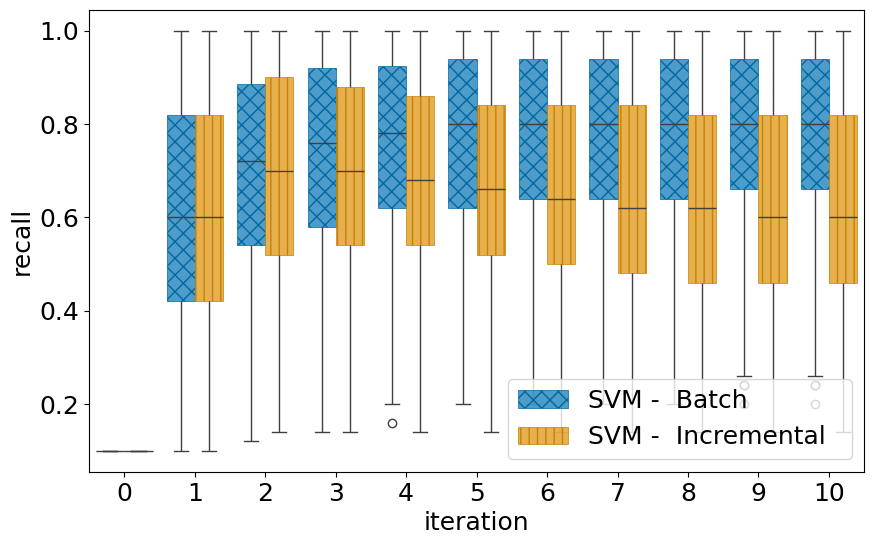

*****
**** Performing statistical tests for k_pos=-1,, k_neg=0 ***
 	 k_pos=-1, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=-1, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=1.2654210164574882, p=0.2607963880920851)
	 k_pos=-1, k_neg=0, it=3 There are statistically significant differences between the methods (ANOVA result: F=12.487379713517985, p=0.0004213729279824762).
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0366 0.0004 -0.0569 -0.0163   True
-------------------------------------------------------------------------
	 k_pos=-1, k_neg=0, it=4 There are statistically significant differences between the methods (ANOVA result: F=41.083982

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0657   0.0 -0.0857 -0.0456   True
------------------------------------------------------------------------
	 k_pos=-1, k_neg=0, it=5 There are statistically significant differences between the methods (ANOVA result: F=80.85773584561814, p=6.687469747032616e-19).
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1           group2        meandiff p-adj  lower  upper  reject
-----------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0921   0.0 -0.1122 -0.072   True
-----------------------------------------------------------------------
	 k_pos=-1, k_neg=0, it=6 There are statistically significant differences between the methods (ANOVA result: F=112.4585

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


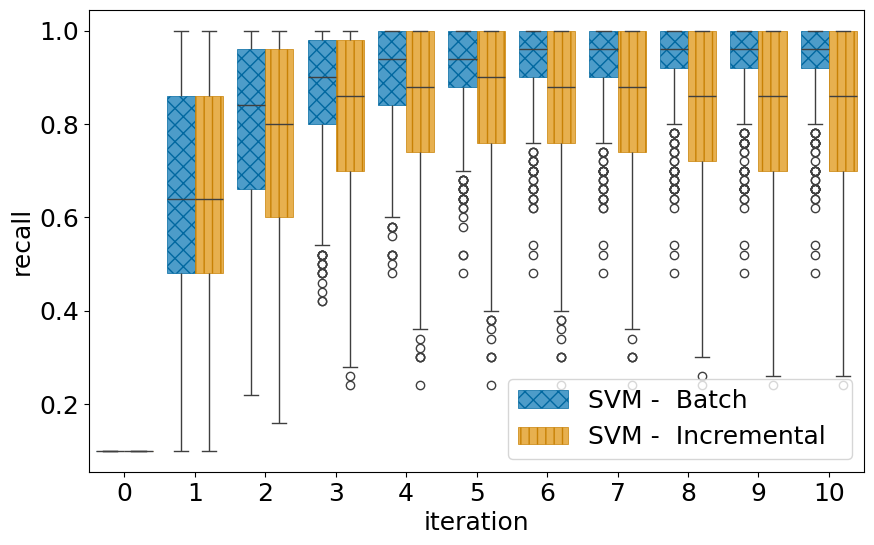

*****
**** Performing statistical tests for k_pos=-1,, k_neg=-1 ***
 	 k_pos=-1, k_neg=-1 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
	 k_pos=-1, k_neg=-1, it=2 There are statistically significant differences between the methods (ANOVA result: F=12.023357146537645, p=0.0005393047219053249).
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0343 0.0005 -0.0537 -0.0149   True
-------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=3 There are statistically significant differences between the methods (ANOVA result: F=46.07544964481475, p=1.598554824645629e-11).


/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental     -0.053   0.0 -0.0683 -0.0376   True
------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=4 There are statistically significant differences between the methods (ANOVA result: F=80.6380826048424, p=7.433839618822932e-19).
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0605   0.0 -0.0737 -0.0473   True
------------------------------------------------------------------------
	 k_pos=-1, k_neg=-1, it=5 There are statistically significant differences between the methods (ANOVA result: F=11

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


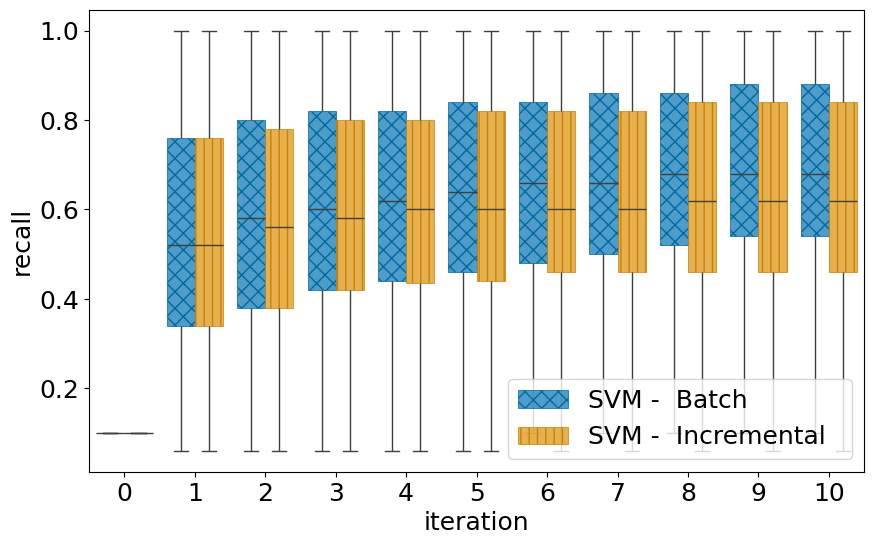

*****
**** Performing statistical tests for k_pos=3,, k_neg=0 ***
 	 k_pos=3, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=3, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.06859268311676246, p=0.7934307139914637)
 	 k_pos=3, k_neg=0 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=1.4603136097315232, p=0.22705901769091136)
 	 k_pos=3, k_neg=0 it=4, There are NO statistically significant differences between the methods. (ANOVA result: F=2.505352770302501, p=0.11365795450998847)
	 k_pos=3, k_neg=0, it=5 There are statistically significant differences between the methods (ANOVA result: F=5.297568148020742, p=0.021483321652379594).
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj   lower   upper  reject
--------------------------------

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0324 0.0043 -0.0547 -0.0102   True
-------------------------------------------------------------------------
	 k_pos=3, k_neg=0, it=7 There are statistically significant differences between the methods (ANOVA result: F=12.16866241233725, p=0.0004991669853874837).
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0392 0.0005 -0.0612 -0.0171   True
-------------------------------------------------------------------------
	 k_pos=3, k_neg=0, it=8 There are statistically significant differences between the methods (ANOVA resul

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


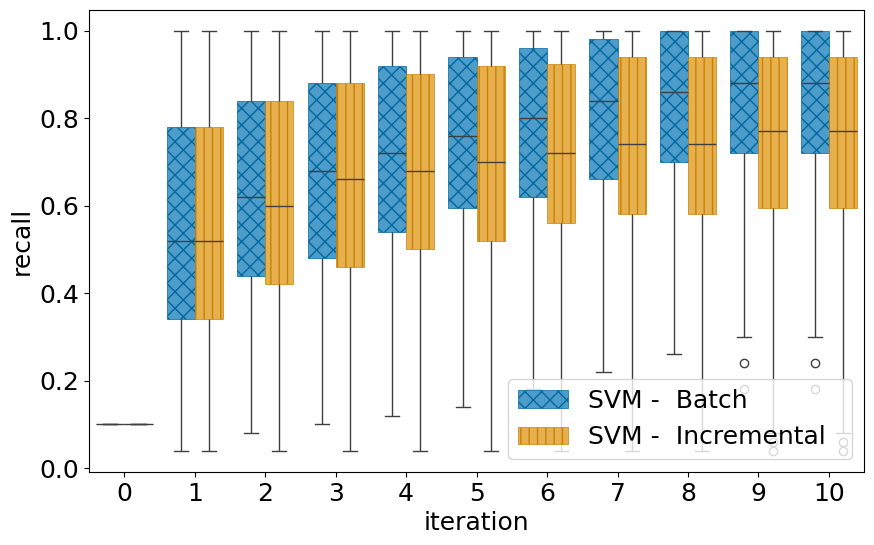

*****
**** Performing statistical tests for k_pos=3,, k_neg=3 ***
 	 k_pos=3, k_neg=3 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=3, k_neg=3 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.551240096216754, p=0.45792055232475914)
 	 k_pos=3, k_neg=3 it=3, There are NO statistically significant differences between the methods. (ANOVA result: F=2.5526804949222446, p=0.11030500880398637)
	 k_pos=3, k_neg=3, it=4 There are statistically significant differences between the methods (ANOVA result: F=7.832787759581633, p=0.005192312239681974).
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0318 0.0052 -0.054 -0.0095   True
----------------------------------------------

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0373 0.0007 -0.0587 -0.0158   True
-------------------------------------------------------------------------
	 k_pos=3, k_neg=3, it=6 There are statistically significant differences between the methods (ANOVA result: F=26.320479095291553, p=3.2453453557160324e-07).
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0541   0.0 -0.0747 -0.0334   True
------------------------------------------------------------------------
	 k_pos=3, k_neg=3, it=7 There are statistically significant differences between the methods (ANOVA result: 

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


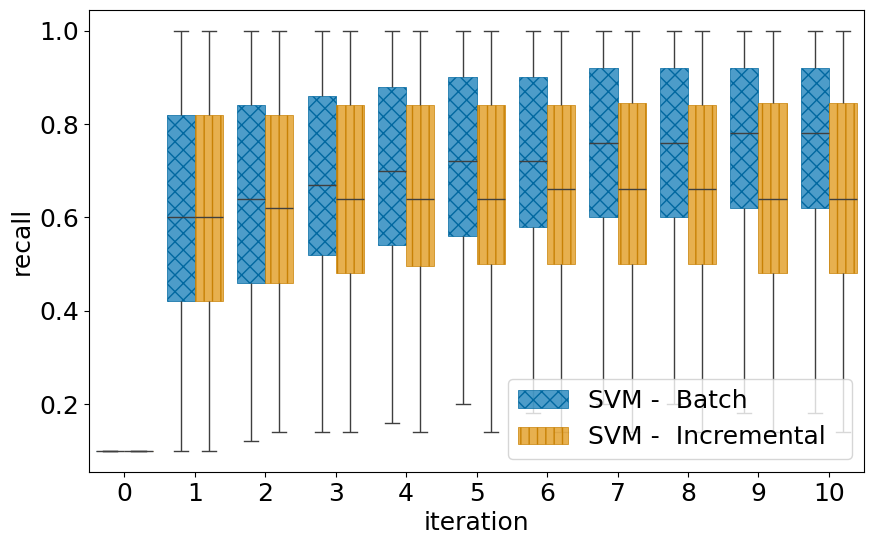

*****
**** Performing statistical tests for k_pos=5,, k_neg=0 ***
 	 k_pos=5, k_neg=0 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=5, k_neg=0 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=0.9611318504954234, p=0.32705027131768427)
	 k_pos=5, k_neg=0, it=3 There are statistically significant differences between the methods (ANOVA result: F=6.067165616703217, p=0.013876534695739157).
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0271 0.0139 -0.0487 -0.0055   True
-------------------------------------------------------------------------
	 k_pos=5, k_neg=0, it=4 There are statistically significant differences between the methods (ANOVA result: F=11.891196685415

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj   lower  upper  reject
------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0371 0.0006 -0.0582 -0.016   True
------------------------------------------------------------------------
	 k_pos=5, k_neg=0, it=5 There are statistically significant differences between the methods (ANOVA result: F=23.437288747179586, p=1.4152686800278758e-06).
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1           group2        meandiff p-adj lower   upper  reject
-----------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0513   0.0 -0.072 -0.0305   True
-----------------------------------------------------------------------
	 k_pos=5, k_neg=0, it=6 There are statistically significant differences between the methods (ANOVA result: F=31.72871

/tmp/ipykernel_776128/3096688082.py:346: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_counts = df_temp.groupby('Method').size().reset_index(name='Count')


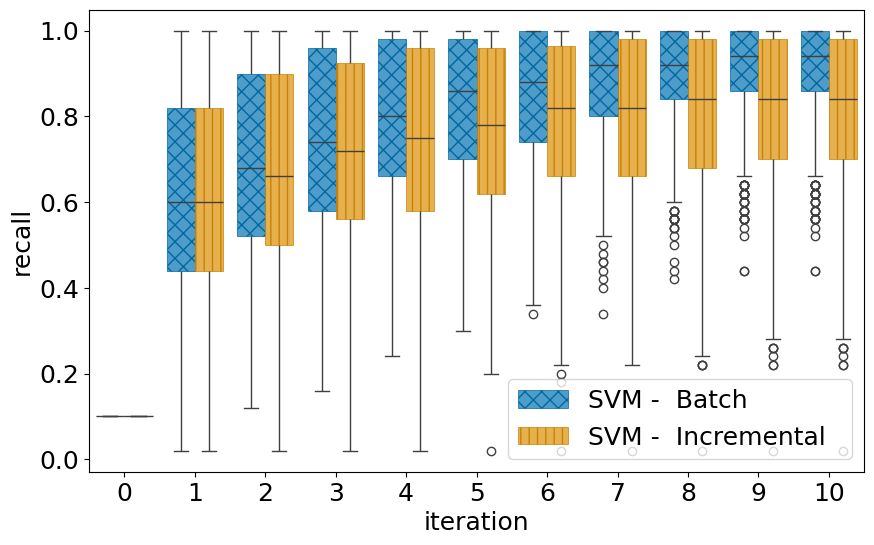

*****
**** Performing statistical tests for k_pos=5,, k_neg=5 ***
 	 k_pos=5, k_neg=5 it=1, There are NO statistically significant differences between the methods. (ANOVA result: F=0.0, p=1.0)
 	 k_pos=5, k_neg=5 it=2, There are NO statistically significant differences between the methods. (ANOVA result: F=1.6614736128547325, p=0.19759103592771735)
	 k_pos=5, k_neg=5, it=3 There are statistically significant differences between the methods (ANOVA result: F=7.102333739676085, p=0.007775867523864485).
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0279 0.0078 -0.0484 -0.0074   True
-------------------------------------------------------------------------
	 k_pos=5, k_neg=5, it=4 There are statistically significant differences between the methods (ANOVA result: F=22.920721824017

/tmp/ipykernel_776128/3096688082.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]


          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0464   0.0 -0.0654 -0.0274   True
------------------------------------------------------------------------
	 k_pos=5, k_neg=5, it=5 There are statistically significant differences between the methods (ANOVA result: F=32.988309891989886, p=1.1078140503961232e-08).
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1           group2        meandiff p-adj  lower   upper  reject
------------------------------------------------------------------------
SVM -  Batch  SVM -  Incremental    -0.0522   0.0 -0.0701 -0.0344   True
------------------------------------------------------------------------
	 k_pos=5, k_neg=5, it=6 There are statistically significant differences between the methods (ANOVA result: F=57.

In [21]:
plot_and_statistical_test_varying_update(df_svm ,'svm',max_iter=10, print_fun_name=True)

# Final comparisons.

Dataframe to be used :
- df_Pic : PicHunter and PicHunter*(softmax, temperature 10 \eta)
- df_Poly : Poly msed and jsd
- df_Rocchio : Rocchio
- df_svm: SVM

['PicHunter*' 'PicHunter' 'PolyadicSearch' 'Rocchio' 'SVM']
[' ' 'sed' 'msed']
['L2_normalized' 'softmax']
(316800, 18)
final Methods
['PicHunter*' 'PicHunter' 'PolyadicSearch  - sed' 'PolyadicSearch  - msed'
 'Rocchio' 'SVM']
^^^^  k_pos=-1, k_neg=0 ^^^
methods_to_plot: ['PolyadicSearch  - msed', 'PolyadicSearch  - sed', 'Rocchio', 'PicHunter', 'PicHunter*', 'SVM']


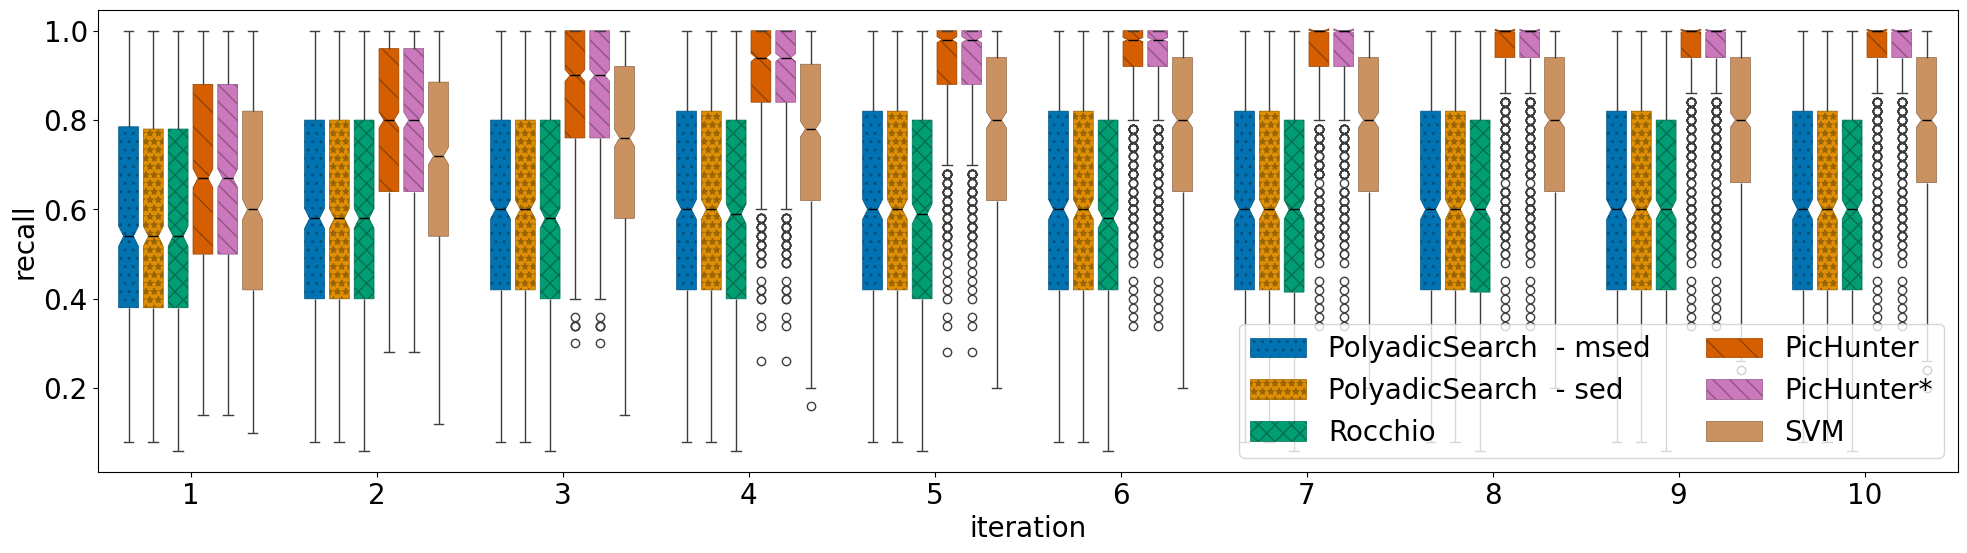

/tmp/ipykernel_776128/2265662504.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/2265662504.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_temp_it.groupby('Method')['recall'].mean())
/tmp/ipykernel_776128/2265662504.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_temp_it.groupby('Method')['rec

k_pos=-1, k_neg=0, it=1, mean
Method
PolyadicSearch  - msed    0.582575
PolyadicSearch  - sed     0.582375
Rocchio                   0.580525
PicHunter                 0.678650
PicHunter*                0.678650
SVM                       0.614975
Name: recall, dtype: float64
k_pos=-1,  k_neg=0, it=1, median
Method
PolyadicSearch  - msed    0.54
PolyadicSearch  - sed     0.54
Rocchio                   0.54
PicHunter                 0.67
PicHunter*                0.67
SVM                       0.60
Name: recall, dtype: float64
	 k_pos=-1, it=1 There are statistically significant differences between the methods (ANOVA result: F=32.28724526274532, p=1.759987536801839e-32).
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
             PicHunter             PicHunter*      0.0    1.0 -0.03

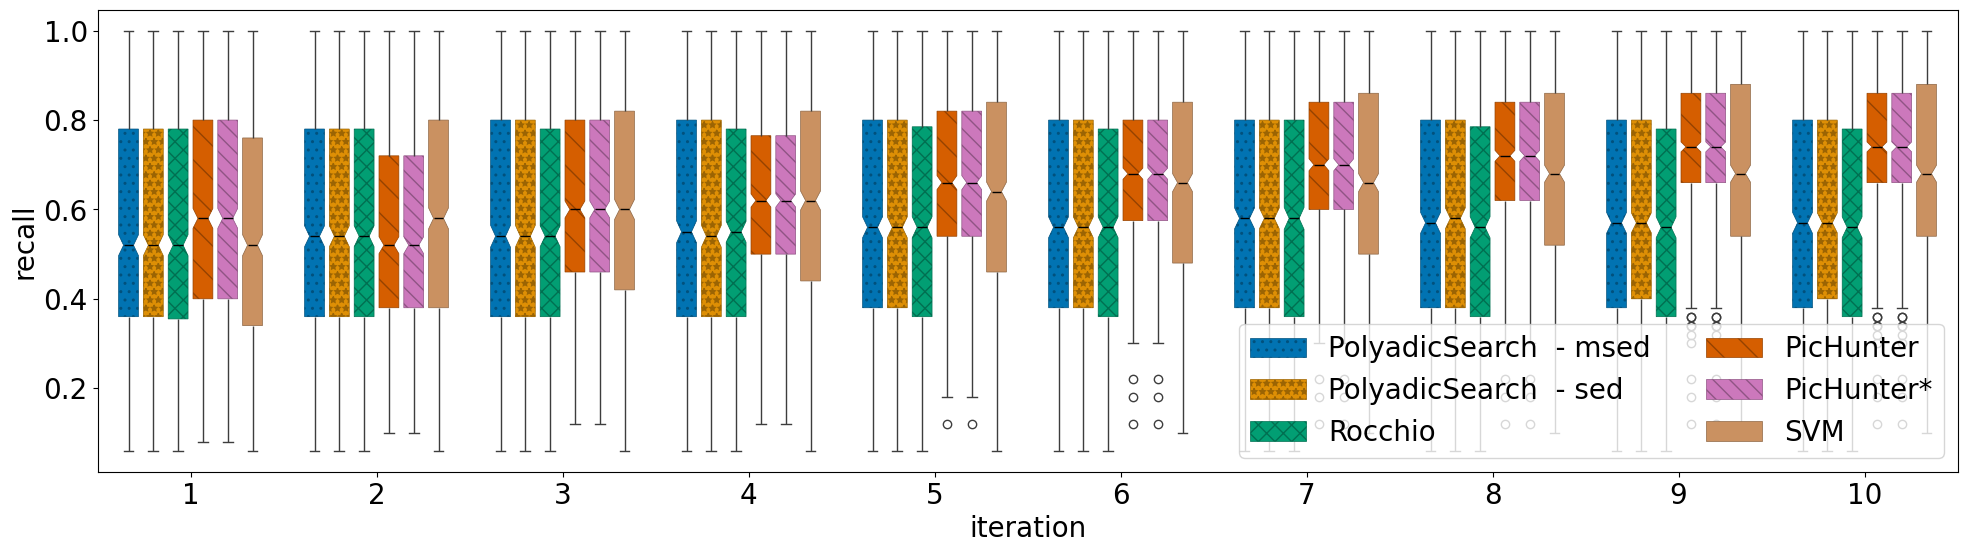

/tmp/ipykernel_776128/2265662504.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/2265662504.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_temp_it.groupby('Method')['recall'].mean())
/tmp/ipykernel_776128/2265662504.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_temp_it.groupby('Method')['rec

k_pos=3, k_neg=0, it=1, mean
Method
PolyadicSearch  - msed    0.558025
PolyadicSearch  - sed     0.557800
Rocchio                   0.556825
PicHunter                 0.599700
PicHunter*                0.599700
SVM                       0.549450
Name: recall, dtype: float64
k_pos=3,  k_neg=0, it=1, median
Method
PolyadicSearch  - msed    0.52
PolyadicSearch  - sed     0.52
Rocchio                   0.52
PicHunter                 0.58
PicHunter*                0.58
SVM                       0.52
Name: recall, dtype: float64
	 k_pos=3, it=1 There are statistically significant differences between the methods (ANOVA result: F=6.5520099869175645, p=4.398421951111549e-06).
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
             PicHunter             PicHunter*      0.0    1.0 -0.0363

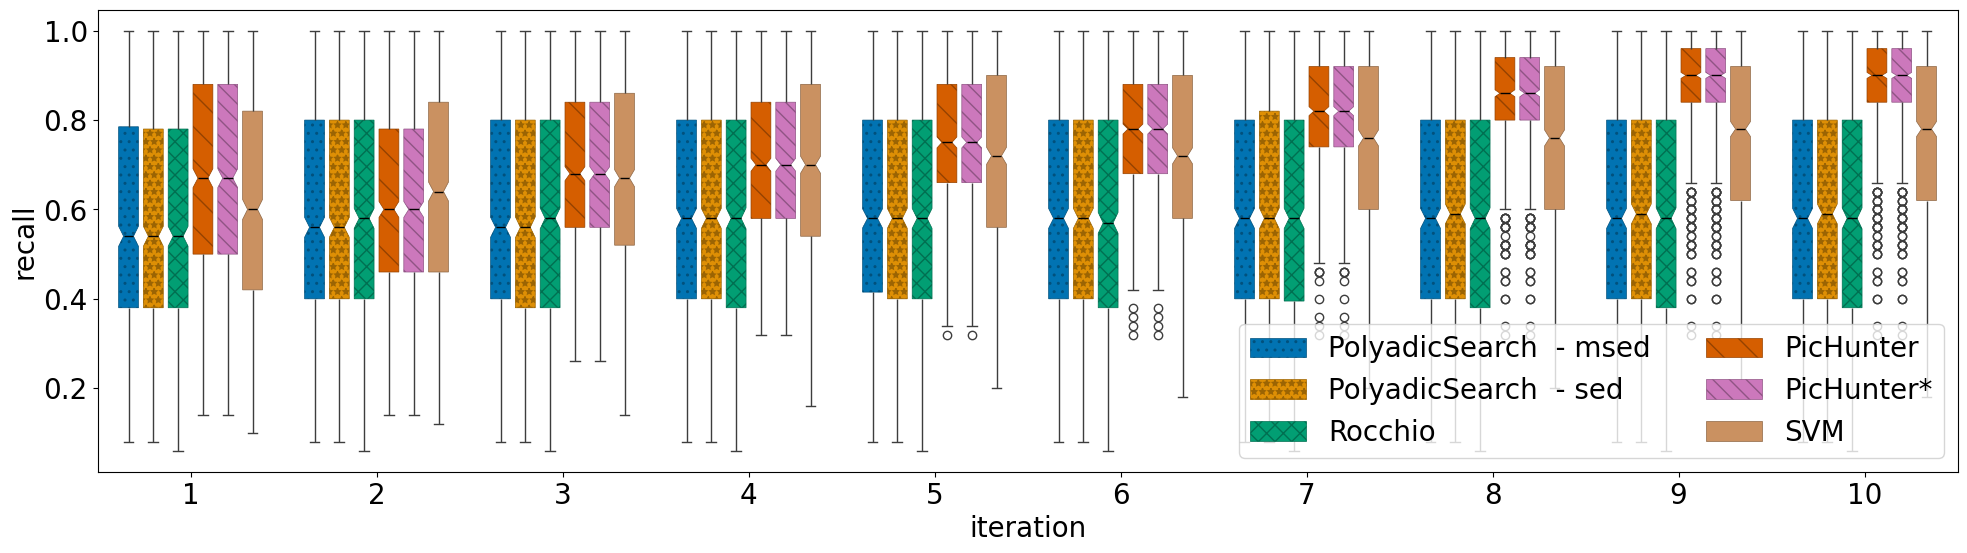

/tmp/ipykernel_776128/2265662504.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/2265662504.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_temp_it.groupby('Method')['recall'].mean())
/tmp/ipykernel_776128/2265662504.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_temp_it.groupby('Method')['rec

k_pos=5, k_neg=0, it=1, mean
Method
PolyadicSearch  - msed    0.582575
PolyadicSearch  - sed     0.582375
Rocchio                   0.580525
PicHunter                 0.678650
PicHunter*                0.678650
SVM                       0.614975
Name: recall, dtype: float64
k_pos=5,  k_neg=0, it=1, median
Method
PolyadicSearch  - msed    0.54
PolyadicSearch  - sed     0.54
Rocchio                   0.54
PicHunter                 0.67
PicHunter*                0.67
SVM                       0.60
Name: recall, dtype: float64
	 k_pos=5, it=1 There are statistically significant differences between the methods (ANOVA result: F=32.28724526274532, p=1.759987536801839e-32).
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
             PicHunter             PicHunter*      0.0    1.0 -0.0337 

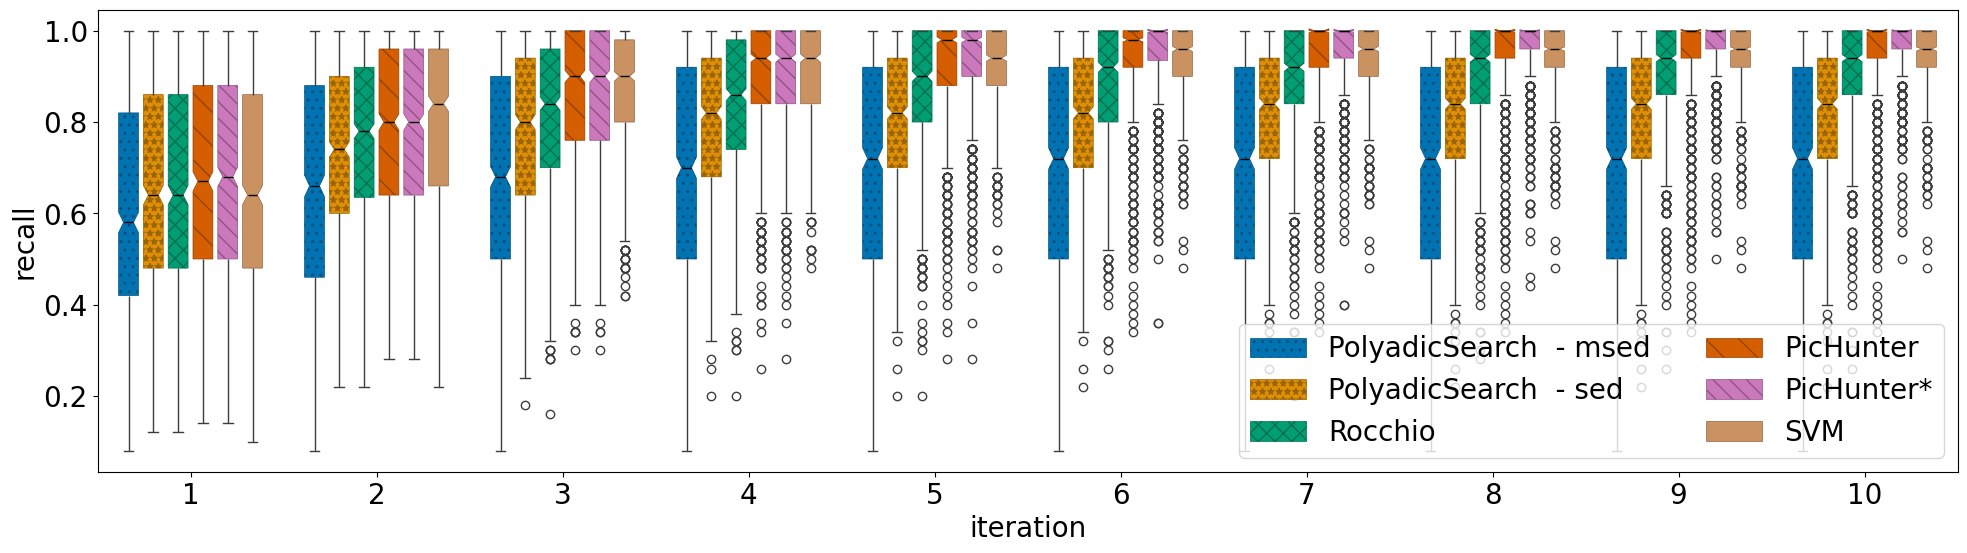

/tmp/ipykernel_776128/2265662504.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/2265662504.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_temp_it.groupby('Method')['recall'].mean())
/tmp/ipykernel_776128/2265662504.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_temp_it.groupby('Method')['rec

k_pos=-1, k_neg=-1, it=1, mean
Method
PolyadicSearch  - msed    0.610550
PolyadicSearch  - sed     0.662850
Rocchio                   0.662650
PicHunter                 0.678650
PicHunter*                0.678675
SVM                       0.660175
Name: recall, dtype: float64
k_pos=-1,  k_neg=-1, it=1, median
Method
PolyadicSearch  - msed    0.58
PolyadicSearch  - sed     0.64
Rocchio                   0.64
PicHunter                 0.67
PicHunter*                0.68
SVM                       0.64
Name: recall, dtype: float64
	 k_pos=-1, it=1 There are statistically significant differences between the methods (ANOVA result: F=10.060047159945686, p=1.3510930853861266e-09).
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
             PicHunter             PicHunter*      0.0    1.0 -

/tmp/ipykernel_776128/2265662504.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/2265662504.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_temp_it.groupby('Method')['recall'].mean())
/tmp/ipykernel_776128/2265662504.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_temp_it.groupby('Method')['rec

k_pos=3, k_neg=3, it=1, mean
Method
PolyadicSearch  - msed    0.576125
PolyadicSearch  - sed     0.576325
Rocchio                   0.576225
PicHunter                 0.599700
PicHunter*                0.572675
SVM                       0.554300
Name: recall, dtype: float64
k_pos=3,  k_neg=3, it=1, median
Method
PolyadicSearch  - msed    0.54
PolyadicSearch  - sed     0.54
Rocchio                   0.54
PicHunter                 0.58
PicHunter*                0.54
SVM                       0.52
Name: recall, dtype: float64
	 k_pos=3, it=1 There are statistically significant differences between the methods (ANOVA result: F=2.564849783907071, p=0.025214430664983065).
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                 group2         meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------
             PicHunter             PicHunter*   -0.027 0.2779 -0.0634 0.00

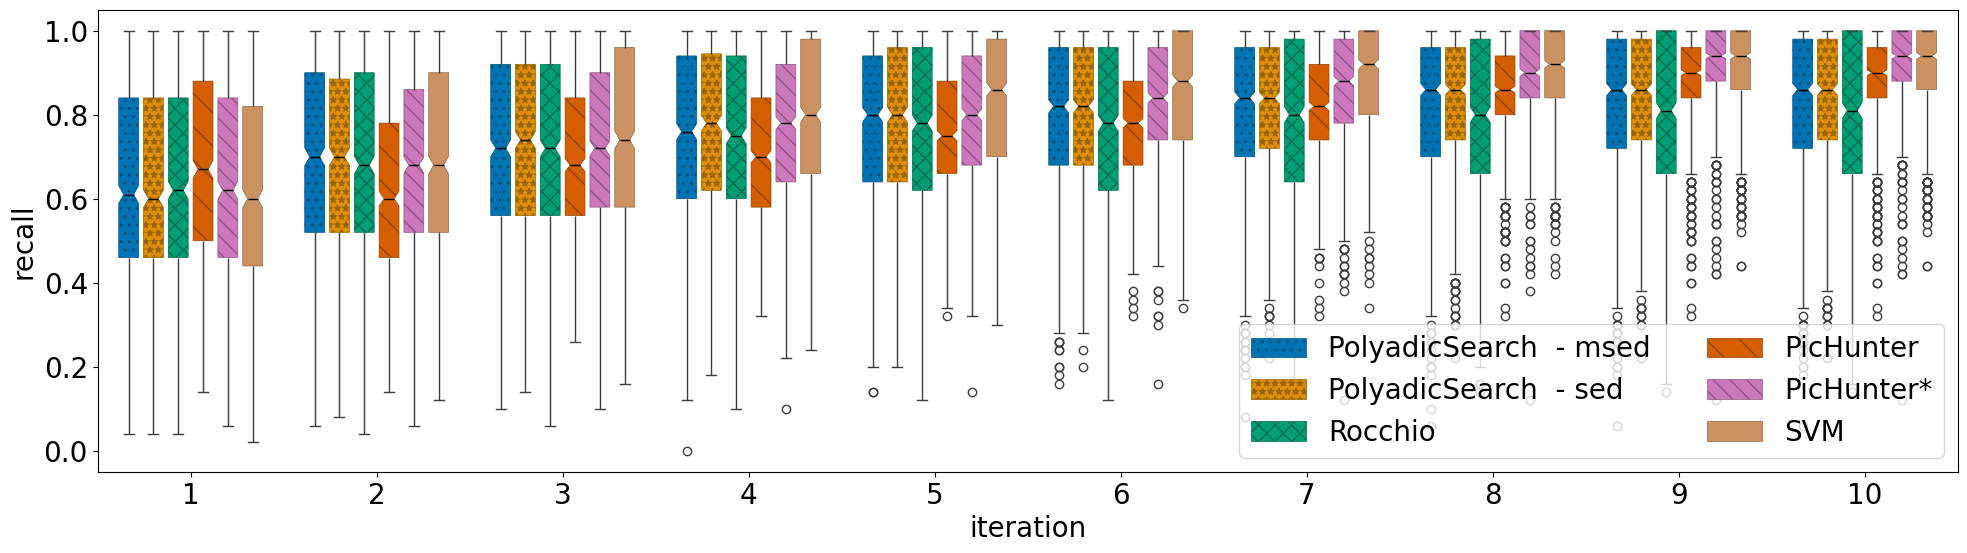

/tmp/ipykernel_776128/2265662504.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
/tmp/ipykernel_776128/2265662504.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_temp_it.groupby('Method')['recall'].mean())
/tmp/ipykernel_776128/2265662504.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_temp_it.groupby('Method')['rec

k_pos=5, k_neg=5, it=1, mean
Method
PolyadicSearch  - msed    0.638875
PolyadicSearch  - sed     0.638850
Rocchio                   0.638900
PicHunter                 0.678650
PicHunter*                0.645625
SVM                       0.620625
Name: recall, dtype: float64
k_pos=5,  k_neg=5, it=1, median
Method
PolyadicSearch  - msed    0.61
PolyadicSearch  - sed     0.60
Rocchio                   0.62
PicHunter                 0.67
PicHunter*                0.62
SVM                       0.60
Name: recall, dtype: float64
	 k_pos=5, it=1 There are statistically significant differences between the methods (ANOVA result: F=5.45339038733579, p=5.218983271762095e-05).
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
             PicHunter             PicHunter*   -0.033 0.0498  -0.066  

In [33]:
def plot_final_comparison(df_copy, prefixplot,methods,
                                          k_pos_neg_list = [(-1,0),(-1,-1), (3,0), (3,3), (5,0), (5,5)],
                                          max_iter=10,
                                          out_res_path=res_path,
                                          figsize=(10, 6),
                                          use_wilcoxon=False,
                                          ):
                                          
    plt.rcParams.update({'font.size': 20})
    hatches = [ '..', '**','xx','\\','\\\\',None, '..','||', '--',  '++', 'oo', 'xx', '//', '..', 'xx']
    for k_pos, k_neg in k_pos_neg_list:
        print(f"^^^^  k_pos={k_pos}, k_neg={k_neg} ^^^")
        df_temp = df_copy.copy()
        df_temp=df_temp[(df_temp['k_pos'] == k_pos) & (df_temp['k_neg'] == k_neg)]
        #df_temp = df_temp[df_temp['Method'].isin(methods)]
        #remove from methods the ones that are not emplty in df_temp
        methods_to_plot = []
        for method in methods:
            if df_temp[df_temp['Method']==method].shape[0]>0:
                methods_to_plot.append(method)
        print(f"methods_to_plot: {methods_to_plot}")
        
        # Reorder the 'Method' column based on methods_to_plot
        df_temp['Method'] = pd.Categorical(df_temp['Method'], categories=methods_to_plot, ordered=True)
        number_iterations=len(df_temp['iteration'].unique())
        number_of_methods=len(df_temp['Method'].unique())
       
        
        plt.figure(figsize=figsize)
        
        ax = sns.boxplot(x='iteration', y='recall', hue='Method', data=df_temp, gap=0.2,notch=True, medianprops={"color": "k", "linewidth": 1})
       
       
        # Get unique methods to map hatch patterns to them
        
        colors = sns.color_palette("colorblind") #sns.color_palette('deep', len(methods_to_plot))
        hatch_map = {method: (hatches[i % len(hatches)], colors[i]) for i, method in enumerate(methods_to_plot)}

        for i, patch in enumerate(ax.patches):
            method_index  = (i // number_iterations) # Determine the method for the current patch
            iteration_index= i % number_iterations
            # print(f"i {i} -> method_index:{method_index},      iteration_index:{iteration_index},    patch:{patch}")
            if(i>=number_iterations*number_of_methods):
                method = methods_to_plot[iteration_index]
            else:
                method = methods_to_plot[method_index]
            hatch, color = hatch_map[method]
            face_color_with_alpha = color #+ (0.9,)  # Adding alpha value (0.7)
           
            edge_color_with_alpha = [max(0, c * 0.7) for c in color] #[min(1, c + (1.0 - c) * 0.3)  for c in color]# 
            patch.set_hatch(hatch)
            patch.set_edgecolor(edge_color_with_alpha) #make it a little bit darker then color
            patch.set_linewidth(0.5)
            patch.set_facecolor(face_color_with_alpha)  # Ensure face color is set to correct color

        #handles, labels = ax.get_legend_handles_labels()
        plt.legend( loc='lower right', ncols=2)  
        #plt.title(f"Recall by iteration for each method (k_pos={k_pos}, k_neg={k_neg})")
        save_path = f"{out_res_path}/plots/recall_{prefixplot}_k_{k_pos}_{k_neg}.png"
        plt.savefig(save_path)
        plt.show()
        df_temp.sort_values(by=['to_sort'], inplace=True)   
        for it in range(1, max_iter+1):
            #select df_temp['iteration']==it
            df_temp_it = df_temp[df_temp['iteration']==it]
            # Perform ANOVA
        
            anova_result = stats.f_oneway(
                *[group['recall'].values for name, group in df_temp_it.groupby('Method')]
            )
          
            print(f'k_pos={k_pos}, k_neg={k_neg}, it={it}, mean')
            print(df_temp_it.groupby('Method')['recall'].mean())
            print(f'k_pos={k_pos},  k_neg={k_neg}, it={it}, median')
            print(df_temp_it.groupby('Method')['recall'].median())
            if anova_result.pvalue < 0.05:
                print(f"\t k_pos={k_pos}, it={it} There are statistically significant differences between the methods (ANOVA result: F={anova_result.statistic}, p={anova_result.pvalue}).") 
                
                if use_wilcoxon:
                    wilcoxon_results = {}

                    # Get unique methods
                    methods = df_temp_it['Method'].unique()

                    # Perform pairwise Wilcoxon tests
                    for method1, method2 in itertools.combinations(methods, 2):
                        group1 = df_temp_it[df_temp_it['Method'] == method1]['recall']
                        group2 = df_temp_it[df_temp_it['Method'] == method2]['recall']
                        if len(group1) != len(group2):
                                    print(f"Skipping Wilcoxon test for {method1} vs {method2} due to unequal sample sizes.")
                                    continue
                                
                        stat, pvalue = wilcoxon(group1, group2)
                        wilcoxon_results[(method1, method2)] = pvalue
                        if pvalue<0.05:
                            # differences = np.array(group1) - np.array(group2)
                            # abs_diff = np.abs(differences)
                            # ranks = np.argsort(np.argsort(abs_diff)) + 1
                            # signed_ranks = ranks * np.sign(differences)

                            # # Sum of ranks for positive and negative differences
                            # W_plus = np.sum(signed_ranks[signed_ranks > 0])
                            # W_minus = np.sum(-signed_ranks[signed_ranks < 0])
                            # print(f"k_pos={k_pos}, it={it},\t\t\t! Wilcoxon test between {method1} and {method2}: \t stat={stat}, p-value = {pvalue}, W+ minus W-: {W_plus-W_minus}")
                            g2_minus_g1 = (np.array(group2) - np.array(group1)).mean()
                            print(f"k_pos={k_pos}, it={it},\t\t\t! Wilcoxon test between m1={method1} and m2={method2}: \t stat={stat}, p-value = {pvalue}, mean m2-m1: {g2_minus_g1}")
                        #else: 
                            #print(f" \t\t\tWilcoxon test between {method1} and {method2} has pvalue>0.05")
                    print("")        
                else:                
                            # Perform pairwise t-tests using Tukey's HSD (Honestly Significant Difference)
                            tukey_result = pairwise_tukeyhsd(
                                endog=df_temp_it['recall'],
                                groups=df_temp_it['Method'],
                                alpha=0.05
                            ) #meandiff is mean group 2 - mean group1

                            #diff=df_temp_it[df_temp_it['method_fun']== "Pichunter - l1_normalized_cosine"]['recall'].mean()-df_temp_it[df_temp_it['method_fun']== "Pichunter - softmin"]['recall'].mean()
                            print(tukey_result)

                        # # Plot the result
                        # tukey_result.plot_simultaneous()
                        # plt.title('Tukey HSD Pairwise Comparisons')
                        # plt.show()
            else:
                print(f" \t k_pos={k_pos}, it={it}, There are NO statistically significant differences between the methods. (ANOVA result: F={anova_result.statistic}, p={anova_result.pvalue})")


methods_to_plot=['PolyadicSearch  - msed','PolyadicSearch  - sed','Rocchio','PicHunter', 'PicHunter*','SVM']
df_to_concat=[df_Pic[df_Pic['use_batch']==True],df_Poly[df_Poly['use_batch']==True],df_Rocchio[df_Rocchio['use_batch']==False],df_svm[df_svm['use_batch']==True]]
#methods_to_plot=['PicHunter', 'PicHunter*','SVM']
#df_to_concat=[df_Pic[df_Pic['use_batch']==True],df_svm[df_svm['use_batch']==True]]
df_final= pd.concat(df_to_concat, ignore_index=True)
print(df_final['method'].unique())
print(df_final['fun_name'].unique())
print(df_final['data_preprocessing'].unique())
print(df_final.shape)
# df_final.loc[df_final['method']=='PicHunter','method']='PicHunter (only pos)'

df_final['Method']= df_final['method']+df_final['fun_name'].apply(lambda x: '  - '+x if x!=' ' else '')  
print ("final Methods")
print(df_final['Method'].unique())       
        



#&(df_final['iteration']<7)
plot_final_comparison(df_final[(df_final['iteration']>0)&(df_final['iteration']<11)], "final",methods_to_plot,k_pos_neg_list = [(-1,0), (3,0), (5,0)],
                                          figsize=(24, 6), use_wilcoxon=False
                                         )


plot_final_comparison(df_final[(df_final['iteration']>0)&(df_final['iteration']<11)], "final",methods_to_plot,k_pos_neg_list = [(-1,-1),  (3,3),  (5,5)],
                                          figsize=(24, 6)

                                         )

#methods_to_plot=['PolyadicSearch  - msed','PolyadicSearch  - jsd','Rocchio ', 'SVM ','PicHunter/PicHunter* ', 'PicHunter* ']
# prefixplot='comparison'
# use_batch = False
# print("^^^^^^^^^^^^^^^^^")
# print ("USE BATCH------>", use_batch)  
# print("^^^^^^^^^^^^^^^^^")



# plot_final_comparison(df_final[(df_final['iteration']>0)&(df_final['iteration']<7)], prefixplot,methods_to_plot,
#                                           use_batch,k_pos_neg_list = [(-1,0),(-1,-1), (3,0), (3,3), (5,0), (5,5)],
#                                           figsize=(10, 7)
#                                           )


# use_batch = True
# print("^^^^^^^^^^^^^^^^^")
# print ("USE BATCH------>", use_batch)  
# print("^^^^^^^^^^^^^^^^^")



# plot_final_comparison(df_final[(df_final['iteration']>0)&(df_final['iteration']<7)], prefixplot,methods_to_plot,
#                                           use_batch,k_pos_neg_list = [(-1,0),(-1,-1), (3,0), (3,3), (5,0), (5,5)],
#                                           figsize=(10, 7)
#                                           )